## Introduction

This project applies statistical time series forecasting techniques to real-world datasets from diverse domains with a focus on financial data, macroeconomic indicators and socioeconomic trends. 

The core aims are to:

* Assess how time series models handle diverse statistical properties, such as trend, volatility and non-stationarity.
* Evaluate model limitations in real-world forecasting contexts.
* Simulate forecasts and quantify uncertainty using Monte Carlo methods and kernel density estimation (KDE).
* Compare model performance across domains and time resolutions.
* Extend the analysis with more advanced modeling techniques.

### Research Questions

The main research question is the following:

* How do statistical time series models perform across financial, macroeconomic and socioeconomic datasets, and what are their limitations when forecasting real-world data?

The sub-research questions include:

1. Are statistical models robust to the noise and trend structures typical in financial and economic data?
2. Do high-frequency datasets require domain-specific modeling strategies or parameter tuning?
3. Which models generalize well across domains and under what conditions do they fail?
4. Can simulation-based techniques (e.g., Monte Carlo forecasting) and kernel density estimation (KDE) provide meaningful uncertainty estimates?

### Notebook Structure

This notebook is organized as follows:

* **Part 1**: includes core methods such as stationarity testing, classical forecasting methods, AR modeling and Monte Carlo simulations with KDE.
* **Part 2**: fits AR(p) models and simulates forward paths to estimate uncertainty using higher-frequency data.
* **Part 3**: includes advanced exploration by applying additional methods like ARIMA and ARCH/GARCH.
  
Lastly, a final reflection synthesizes results, highlights limitations and suggests directions for future work.

### Experimental Settings

All experiments are conducted using Python on a Mac equipped with Apple M4 hardware. The forecasting tasks leverage the `StatsForecast` library [@garza2022statsforecast], in combination with widely used Python packages such as `pandas`, `statsmodels` and others for data manipulation and statistical analysis. The full codebase is made available to ensure transparency and reproducibility.

### Forecasting Horizons

Forecasts are evaluated at a one-step-ahead horizon, classifying them as short-term forecasts. Although it would have been possible to consider longer horizons, the decision to focus on a single-step forecast was made to ensure consistency in analysis and comparison. This choice is particularly important given that some of the time series are low-frequency and relatively short in length, which makes forecasting over longer horizons more challenging. Additionally, Monte Carlo simulations are used to generate multi-step forecast paths, typically over a 15-step horizon, to assess uncertainty and potential future scenarios.

## Part 1 {#sec-part-1}

### Data Collection and Visualization

#### Dataset Overview

The dataset (see @tbl-metadata) is composed of a diverse portfolio of time series, both short and long, sourced from Alpha Vantage, Federal Reserve Economic Data (FRED) and the World Bank, covering the financial, macroeconomic and socioeconomic domains. This variety allows for a comprehensive evaluation of classical time series models across different structural and statistical properties.

In [1]:
# Import required libraries
from alpha_vantage.timeseries import TimeSeries
from fredapi import Fred
import wbdata
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#| label: tbl-metadata
#| tbl-cap: Structured Metadata of Selected Time Series

# Import library for displaying HTML table
from IPython.display import HTML

# Dataset metadata
data = [
    ["SPY", "SPDR S&P 500 ETF Trust", "Finance", "Price", 
     "Daily closing price (USD) of SPY, an ETF that seeks to provide investment results that correspond to the S&P 500 Index", 
     "Alpha Vantage", "Daily", "1999-11-01", "2025-06-04"],
    
    ["EWJ", "iShares MSCI Japan ETF", "Finance", "Price", 
     "Daily closing price (USD) of EWJ, an ETF that seeks to track the performance of Japanese equities", 
     "Alpha Vantage", "Daily", "1999-11-01", "2025-06-04"],
    
    ["AAPL", "Apple Inc. Stock", "Finance", "Price", 
     "Intraday 1-minute closing prices (USD) for Apple Inc. stock, a leading consumer electronics and software company", 
     "Alpha Vantage", "Intraday (1-min)", "2025-06-13 18:19:00", "2025-06-13 19:59:00"],
    
    ["MSFT", "Microsoft Corporation Stock", "Finance", "Price", 
     "Intraday 1-minute closing prices (USD) for Microsoft Corporation stock, a major software and services provider", 
     "Alpha Vantage", "Intraday (1-min)", "2025-06-13 18:19:00", "2025-06-13 19:59:00"],
    
    ["US GDP", "Gross Domestic Product (GDP)", "Macroeconomics", "Value", 
     "Real GDP in billions of chained dollars (seasonally adjusted annual rate)"
     "Reflects the market value of all goods and services produced in the US, adjusted for inflation and seasonal effects",
     "FRED, U.S. Bureau of Economic Analysis", "Quarterly", "1946-01-01", "2025-01-01"],
    
    ["US CPI", "Consumer Price Index (CPI)", "Macroeconomics", "Index", 
     "Consumer Price Index for All Urban Consumers: All Items (CPIAUCSL), measured as an index with base 1982–1984 = 100, seasonally adjusted"
     "Reflects changes in the price level of a representative basket of goods and services paid by urban consumers"
     "Percent changes in the index measure inflation rates over time",
     "FRED, U.S. Bureau of Labor Statistics", "Monthly", "1947-01-01", "2025-04-01"],
    
    ["TH Unemployment", "Thailand Unemployment Rate", "Labor", "Rate", 
     "Unemployment rate (% of labor force), modeled ILO estimate", 
     "World Bank", "Annual", "2010-01-01", "2024-01-01"],
    
    ["TH Labour Force", "Thailand Labour Force Participation", "Labor", "Rate", 
     "Labor force participation rate (% of population ages 15+), ILO estimate", 
     "World Bank", "Annual", "2010-01-01", "2024-01-01"]
]

# Create DataFrame
df_meta = pd.DataFrame(data, columns=[
    "Code", "Name", "Domain", "Data Type", "Description", "Source",
    "Frequency", "Start Date", "End Date"
])

# Display as HTML
HTML(df_meta.to_html(index=False))

Code,Name,Domain,Data Type,Description,Source,Frequency,Start Date,End Date
SPY,SPDR S&P 500 ETF Trust,Finance,Price,"Daily closing price (USD) of SPY, an ETF that seeks to provide investment results that correspond to the S&P 500 Index",Alpha Vantage,Daily,1999-11-01,2025-06-04
EWJ,iShares MSCI Japan ETF,Finance,Price,"Daily closing price (USD) of EWJ, an ETF that seeks to track the performance of Japanese equities",Alpha Vantage,Daily,1999-11-01,2025-06-04
AAPL,Apple Inc. Stock,Finance,Price,"Intraday 1-minute closing prices (USD) for Apple Inc. stock, a leading consumer electronics and software company",Alpha Vantage,Intraday (1-min),2025-06-13 18:19:00,2025-06-13 19:59:00
MSFT,Microsoft Corporation Stock,Finance,Price,"Intraday 1-minute closing prices (USD) for Microsoft Corporation stock, a major software and services provider",Alpha Vantage,Intraday (1-min),2025-06-13 18:19:00,2025-06-13 19:59:00
US GDP,Gross Domestic Product (GDP),Macroeconomics,Value,"Real GDP in billions of chained dollars (seasonally adjusted annual rate)Reflects the market value of all goods and services produced in the US, adjusted for inflation and seasonal effects","FRED, U.S. Bureau of Economic Analysis",Quarterly,1946-01-01,2025-01-01
US CPI,Consumer Price Index (CPI),Macroeconomics,Index,"Consumer Price Index for All Urban Consumers: All Items (CPIAUCSL), measured as an index with base 1982–1984 = 100, seasonally adjustedReflects changes in the price level of a representative basket of goods and services paid by urban consumersPercent changes in the index measure inflation rates over time","FRED, U.S. Bureau of Labor Statistics",Monthly,1947-01-01,2025-04-01
TH Unemployment,Thailand Unemployment Rate,Labor,Rate,"Unemployment rate (% of labor force), modeled ILO estimate",World Bank,Annual,2010-01-01,2024-01-01
TH Labour Force,Thailand Labour Force Participation,Labor,Rate,"Labor force participation rate (% of population ages 15+), ILO estimate",World Bank,Annual,2010-01-01,2024-01-01


#### Data Loading and Preprocessing

The time series are retrieved using their respective APIs and libraries, then preprocessed and formatted into consistent, time-indexed structures suitable for analysis and modeling. In the case of U.S. GDP, missing values prior to 1947 are removed, as their exclusion does not affect the analysis. For datasets obtained from Alpha Vantage and FRED, the inability to specify predefined time windows requires exporting the data to CSV files and subsequently reloading them to ensure reproducibility.

With regard to intraday data, missing values are handled using simple imputation techniques. For Apple, the first data point in the series is missing and is imputed using backward fill. In contrast, the Microsoft series contains a missing value within the body of the data, which is imputed using forward fill. While these methods are relatively straightforward, they are effective for initial analysis. More sophisticated techniques such as the Kalman filter or ARIMA-based imputation could be implemented in future work to enhance accuracy and robustness.

In [3]:
# --- Fetch Financial Data from Alpha Vantage API

# API key for Alpha Vantage service
alphav_api_key = 'insert-your-api-key-here'

# Initialize the Alpha Vantage TimeSeries client with the API key
# and set output format to pandas DataFrame for easier data manipulation
ts = TimeSeries(key=alphav_api_key, output_format='pandas')

def fetch_alpha_vantage(symbol, label, interval="daily", outputsize="full"):
    """
    Retrieve time series financial data from Alpha Vantage.

    Supports both daily and intraday data retrieval.

    Parameters:
    - symbol (str): The ticker symbol for the financial instrument (e.g., "SPY", "AAPL").
    - label (str): Descriptive label used for logging and error messages.
    - interval (str): Data frequency interval; "daily" for daily data or
                      intraday intervals such as "1min", "5min". Defaults to "daily".
    - outputsize (str): The amount of data to retrieve; either "compact" (latest 100 points)
                        or "full" (complete available history). Defaults to "full".

    Returns:
    - pandas.DataFrame: A DataFrame indexed by datetime with OHLCV columns if successful.
    - None: Returns None if the data fetching fails.
    """
    try:
        if interval == "daily":
            # Fetch daily time series data
            data, _ = ts.get_daily(symbol=symbol, outputsize=outputsize)
        else:
            # Fetch intraday time series data with specified interval
            data, _ = ts.get_intraday(symbol=symbol, interval=interval, 
                                      outputsize=outputsize)
        
        # Convert the index to datetime objects for consistency
        data.index = pd.to_datetime(data.index)
        
        return data
    except Exception as e:
        # Print an error message if fetching data fails
        print(f"Failed to fetch {label}: {e}")
        return None

In [4]:
# Get SPY, an ETF proxy for the S&P 500 index
spy = fetch_alpha_vantage("SPY", "sp500")
# Extract the 'Close' price series from SPY data
spy = spy["4. close"].copy()

# Get EWJ, an ETF proxy for the Japanese equity market
ewj = fetch_alpha_vantage("EWJ", "nikkei")
# Extract the 'Close' price series from EWJ data
ewj = ewj["4. close"].copy().sort_index()

# Get 1-minute intraday data for Apple (AAPL)
aapl_intraday = fetch_alpha_vantage("AAPL", "apple_1min", interval="1min", 
                                    outputsize="compact")
# Extract the 'Close' price series from AAPL data
aapl_intraday = aapl_intraday["4. close"].copy()

# Get 1-minute intraday data for Microsoft (MSFT)
msft_intraday = fetch_alpha_vantage("MSFT", "microsoft_1min", interval="1min", 
                                    outputsize="compact")
# Extract the 'Close' price series from MSFT data
msft_intraday = msft_intraday["4. close"].copy()

In [5]:
# --- Export Alpha vantage series

# To execute this, uncomment

# Daily series
#daily_df = pd.concat([
#    spy.rename("SPY"),
#    ewj.rename("EWJ")
#], axis=1)
#daily_df.index.name = "date"

# Intraday series
#intraday_df = pd.concat([
#    aapl_intraday.rename("AAPL_1min"),
#    msft_intraday.rename("MSFT_1min")
#], axis=1)
#intraday_df.index.name = "date"

#daily_df.to_csv("equity_prices_daily.csv")
#intraday_df.to_csv("equity_prices_intraday.csv")

In [6]:
# Load previously downloaded daily stock price data (Alpha Vantage)
daily_df = pd.read_csv("./equity_prices_daily.csv", parse_dates=["date"], 
                       index_col="date")
spy = daily_df['SPY']
ewj = daily_df['EWJ']

# Load previously downloaded intraday stock price data (Alpha Vantage)
intraday_df = pd.read_csv("./equity_prices_intraday.csv", parse_dates=["date"], 
                          index_col="date")
aapl_intraday = intraday_df['AAPL_1min'] 
msft_intraday = intraday_df['MSFT_1min']

# Impute missing values in intraday series
# For Apple (missing at the start), use backward fill
aapl_intraday = aapl_intraday.bfill()

# For Microsoft (missing within the series), use forward fill
msft_intraday = msft_intraday.ffill()

In [7]:
# Convert DataFrames to Series
aapl_intraday = aapl_intraday.squeeze()
msft_intraday = msft_intraday.squeeze()

In [8]:
# --- Fetch Economic Data from FRED (Federal Reserve Economic Data)

# API key for accessing FRED data
fred_api_key = "insert-your-api-key-here"

# Initialize the FRED client with the provided API key
fred = Fred(api_key=fred_api_key)

def fetch_fred_series(series_id, label):
    """
    Retrieve a time series dataset from FRED using a given series ID.

    Parameters:
    - series_id (str): Unique identifier for the economic data series on FRED 
                       (e.g., "GDP", "CPIAUCSL").
    - label (str): Descriptive label for logging purposes.

    Returns:
    - pandas.DataFrame: A DataFrame indexed by date, containing the series data
      with the column named after the series_id.
    - None: Returns None if the data retrieval fails.
    """
    try:
        # Fetch raw time series data from FRED
        data = fred.get_series(series_id)
        
        # Convert to DataFrame and assign the series_id as the column name
        df = pd.DataFrame(data, columns=[series_id])
        
        # Name the index "Date" for clarity and consistency
        df.index.name = "Date"
        
        return df
    except Exception as e:
        # Log the error with label and series_id for troubleshooting
        print(f"Failed to fetch {label} ({series_id}): {e}")
        return None


In [9]:
# To execute this, uncomment

# Fetch quarterly US GDP
#us_gdp = fetch_fred_series("GDP", "us_gdp_quarterly")
# Drop missing values
#us_gdp = us_gdp.dropna()
# Convert to series
#us_gdp = us_gdp['GDP']

# Fetch monthly US CPI
#us_cpi = fetch_fred_series("CPIAUCSL", "us_cpi_monthly")
# Convert to series
#us_cpi = us_cpi['CPIAUCSL']

In [10]:
# --- Export FRED series

# To execute this, uncomment

#us_gdp.to_csv("us_gdp_quarterly.csv")
#us_cpi.to_csv("us_cpi_monthly.csv")

In [11]:
# Load previously downloaded from FRED
us_gdp = pd.read_csv("us_gdp_quarterly.csv", parse_dates=["Date"], 
                          index_col="Date")
us_cpi = pd.read_csv("us_cpi_monthly.csv", parse_dates=["Date"], 
                          index_col="Date")

# Convert DataFrames to Series
us_gdp = us_gdp.squeeze()
us_cpi = us_cpi.squeeze()

In [12]:
# --- Get World Bank Labor Data

# Set country and indicators
country_code = 'TH'  # Thailand
indicators = {
    'SL.UEM.TOTL.ZS': 'Unemployment Rate',      
    'SL.TLF.CACT.ZS': 'Labor Force Participation Rate'
}

# Fetch data
wb_social_data = wbdata.get_dataframe(indicators, country=country_code).reset_index()

# Convert 'date' column to datetime
wb_social_data['date'] = pd.to_datetime(wb_social_data['date'])

# Filter by date range
start_date = '2010-01-01'
end_date = '2025-06-05'
mask = (wb_social_data['date'] >= start_date) & (wb_social_data['date'] <= end_date)
wb_social_data = wb_social_data.loc[mask].set_index('date')

# Split into separate Series
th_unemployment_rate = wb_social_data['Unemployment Rate']
th_labor_force_participation = wb_social_data['Labor Force Participation Rate']

#### Visualization and Summary Statistics

Prior to further preprocessing and modeling, each time series is visualized in @fig-1-time-series-plot to assess key characteristics such as trends, seasonality and volatility. Complementing this visual inspection, @tbl-summary-stats reports fundamental summary statistics, mean, standard deviation (volatility) and coefficient of variation for each series. These initial descriptive metrics provide a preliminary understanding of the data’s scale and variability, serving as a basis for subsequent analytical decisions.

In [13]:
# Define helper function to plot time series
def plot_time_series(all_series, y_axis_labels=None, nrows=4, ncols=2, figsize=(16, 12),
                     financial_indices=4):
    """Plots multiple time series in a grid layout.

    Displays a collection of labeled time series in a grid of subplots, 
    optionally customizing axis labels and highlighting specific financial series.

    Parameters:
        all_series (list of tuples): List of (label, series) pairs.
        y_axis_labels (dict, optional): Dictionary mapping labels to y-axis labels.
        nrows (int): Number of subplot rows in the grid.
        ncols (int): Number of subplot columns in the grid.
        figsize (tuple): Overall figure size (width, height).
        financial_indices (int): Number of series (from the top-left) 
                                to highlight as financial.

    Returns:
        None: Displays the time series plots.
    """

    # Create 4x2 grid of subplots
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    axs = axs.flatten()

    # Plot each time series with consistent style and formatting
    for i, (label, series) in enumerate(all_series):
        axs[i].plot(series.index, series.values, linewidth=1.5, color='tab:red')
        axs[i].set_title(label, fontsize=12, fontweight='bold', pad=12)
        axs[i].grid(visible=True, which='major', linestyle='--', alpha=0.6)
        axs[i].tick_params(axis='x', rotation=30)

        y_label = y_axis_labels.get(label, 'Value') if y_axis_labels else 'Value'
        if "intraday" in label.lower():
            axs[i].set_xlabel('Datetime', fontsize=10)
        else:
            axs[i].set_xlabel('Date', fontsize=10)
        axs[i].set_ylabel(y_label, fontsize=10)

    # Highlight financial series subplots with a light blue background
    for i in range(min(financial_indices, len(all_series))):
        axs[i].set_facecolor('#e6f2ff')

    # Remove any unused subplots
    for j in range(len(all_series), len(axs)):
        fig.delaxes(axs[j])

    
    # Adjust layout to prevent overlap, leaving space for the suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [14]:
# Get all series
all_series = [
    ('SPY', spy),
    ('EWJ', ewj),
    ('AAPL Intraday', aapl_intraday),
    ('MSFT Intraday', msft_intraday),
    ('US GDP', us_gdp),
    ('US CPI', us_cpi),
    ('TH Unemployment Rate', th_unemployment_rate),
    ('TH Labor Force Participation', th_labor_force_participation)
]

# Define y-axis labels specific to each series
y_axis_labels = {
    'SPY': 'Price (USD)',
    'EWJ': 'Price (USD)',
    'AAPL Intraday': 'Price (USD)',
    'MSFT Intraday': 'Price (USD)',
    'US GDP': 'Billions of Chained USD',
    'US CPI': 'Index (1982-1984=100)',
    'TH Unemployment Rate': 'Unemployment Rate (%)',
    'TH Labor Force Participation': 'Participation Rate (%)'
}

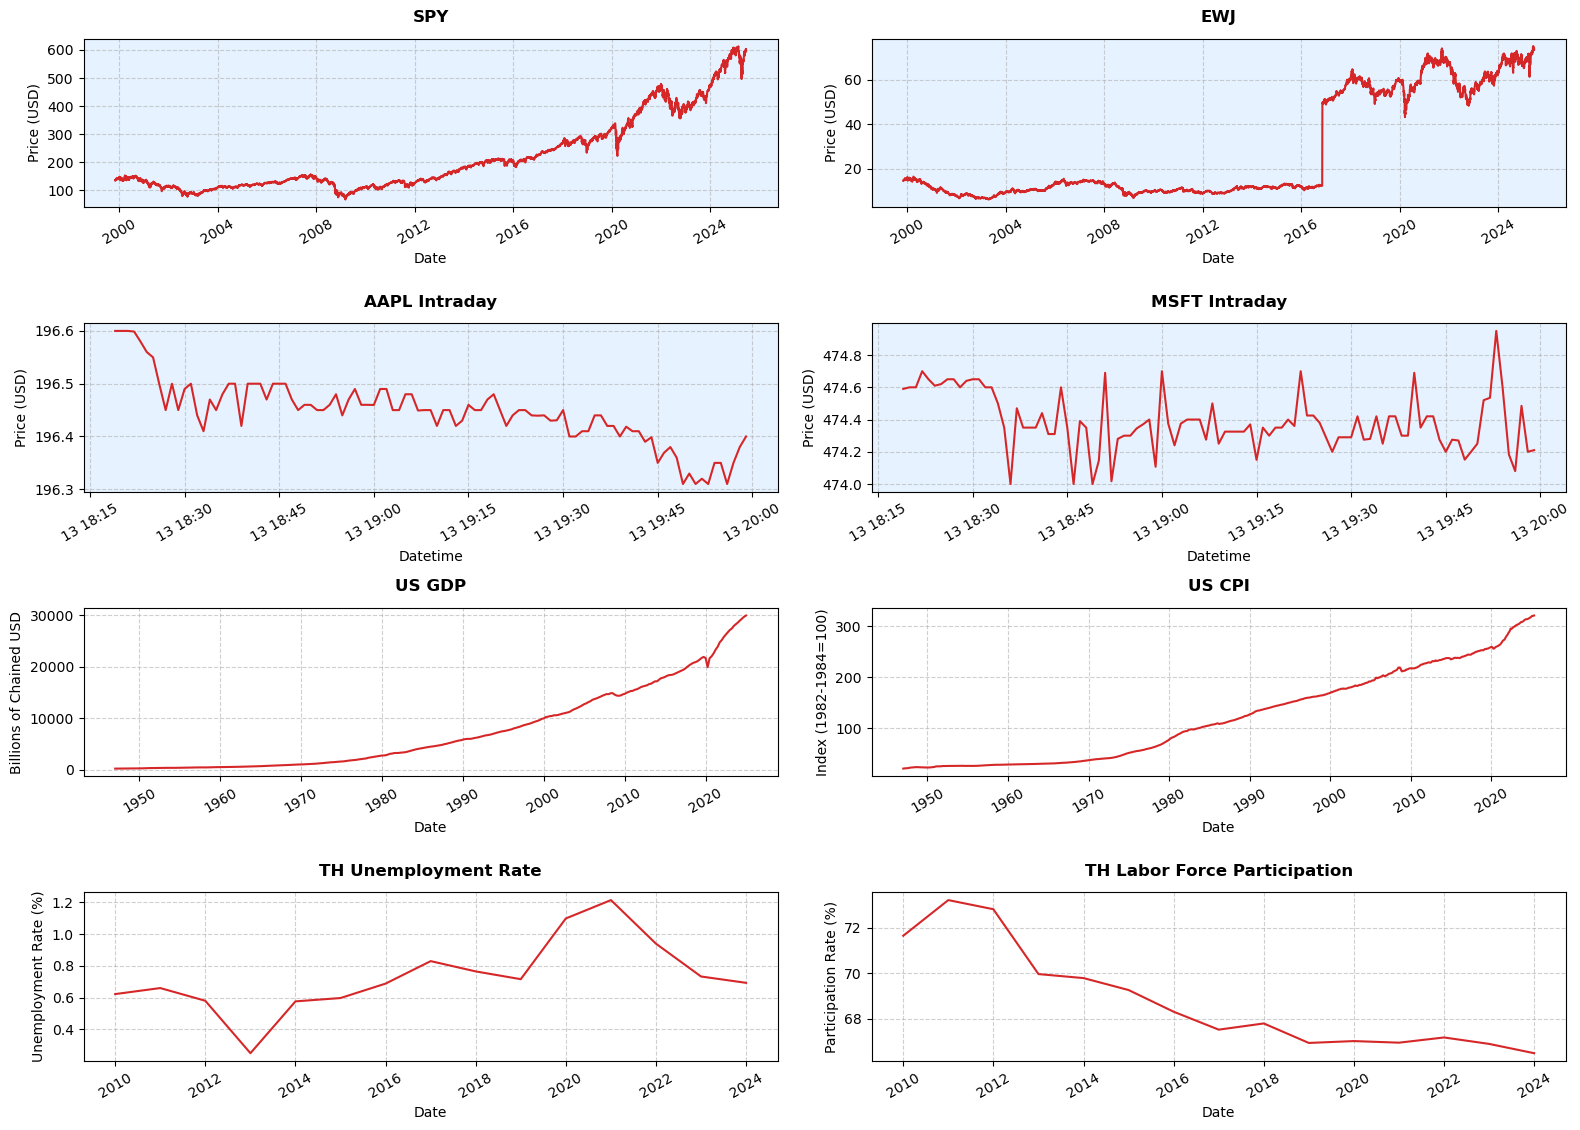

In [15]:
#| label: fig-1-time-series-plot
#| fig-cap: "Line plots illustrating the selected time series datasets used in the analysis"

# --- Plot Time Series
plot_time_series(all_series, y_axis_labels=y_axis_labels)

More detailed statistical analyses, including stationarity tests and assessments of seasonal and trend components, are presented in @sec-seadj-trans-stat. These diagnostics support the application of appropriate data transformations and scaling procedures critical for effective forecasting model development.

In [16]:
# Initialize a list to store summary statistics
summary_stats = []

# Loop through each time series
for label, series in all_series:
    values = series.values.flatten()  # Ensure 1D array
    mean_val = values.mean()
    std_val = values.std()
    cv_val = std_val / mean_val if mean_val != 0 else float('nan')  # Avoid division by zero

    summary_stats.append({
        'Series': label,
        'Mean': round(mean_val, 4),
        'Volatility (Std Dev)': round(std_val, 4),
        'Coefficient of Variation (CV)': round(cv_val, 4)
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_stats)

In [17]:
#| label: tbl-summary-stats
#| tbl-cap: Summary Statistics of the Selected Time Series

# Display as HTML
HTML(summary_df.to_html(index=False))

Series,Mean,Volatility (Std Dev),Coefficient of Variation (CV)
SPY,216.9960,131.5581,0.6063
EWJ,27.5043,23.6604,0.8602
AAPL Intraday,196.4459,0.0609,0.0003
MSFT Intraday,474.3858,0.1777,0.0004
US GDP,7523.4688,7855.7088,1.0442
US CPI,122.5739,88.0061,0.7180
TH Unemployment Rate,0.7309,0.2224,0.3043
TH Labor Force Participation,68.7907,2.1758,0.0316


@fig-1-time-series-plot and @tbl-summary-stats reveal substantial differences in scale, dispersion and underlying dynamics across the selected series:

* SPY and EWJ, two equity indices observed at daily frequency on trading days, exhibit large magnitudes and relatively high volatility. Notably, EWJ’s coefficient of variation (CV = 0.86) exceeds that of SPY (CV = 0.61), indicating greater proportional variability in the Japanese equity market. SPY shows a consistent upward trend, especially following the 2008 financial crisis, reflecting the sustained recovery of U.S. markets. In contrast, EWJ displays a structural break in November 2016, coinciding with a reverse stock split announced in October and implemented in early November 2016 [@marketbeat_ewj].
* AAPL and MSFT intraday prices, despite their high absolute levels, exhibit extremely low standard deviations and coefficients of variation (on the order of 0.0003–0.0004), as expected for high-frequency data sampled at 1-minute intervals. Price changes over such short horizons tend to be small and primarily driven by noise. However, visual inspection suggests that AAPL shows a mild downward trend over the sampled day, whereas MSFT displays more acute fluctuations and possible intraday seasonality. These patterns, while suggestive, should be interpreted cautiously given the limited time span, just a single trading day, which restricts the ability to generalize or robustly detect recurring intraday dynamics.
* U.S. GDP has the highest coefficient of variation (CV = 1.04), reflecting both its scale and structural changes over time. While GDP generally trends upward, two marked contractions are evident: during the 2008 financial crisis and the 2020 COVID-19 pandemic. As a quarterly, seasonally adjusted series, GDP shows pronounced trend and cyclical components linked to business cycles.
* U.S. CPI demonstrates moderate volatility with a CV of 0.72. The series displays a steady upward trajectory typical of price-level indices, with a notable acceleration post-2020, likely related to pandemic-driven inflationary pressures. The CPI data are generally seasonally adjusted, although some components may retain residual seasonal effects.
* Among socioeconomic indicators, the Thai Unemployment Rate exhibits moderate relative variability (CV = 0.30), with fluctuations plausibly driven by economic shocks such as the COVID-19 pandemic. Conversely, the Labor Force Participation Rate is highly stable (CV = 0.03) and shows a gradual downward trend, consistent with demographic factors including population aging and changing labor market structures.

Collectively, these preliminary insights guide subsequent preprocessing and model specification decisions. Typically, financial and macroeconomic series, characterized by nonstationarity and volatility, may require differencing, detrending or variance-stabilizing transformations (e.g., logarithmic). In contrast, more stable socioeconomic indicators may need minimal preprocessing, though their limited variability presents distinct modeling challenges. The next section introduces formal statistical assessments, including stationarity tests and seasonal decomposition, to inform appropriate data transformations.

### Seasonal Adjustment, Transformation and Stationarity {#sec-seadj-trans-stat}

Before applying transformations and ensuring stationarity for later modeling, all series are first examined for seasonality. Macroeconomic indicators are already seasonally adjusted. Socio-economic indicators, such as labor market statistics, are available only at annual frequency, making seasonality detection and adjustment impractical. Financial intraday series, while potentially affected by microstructure noise, are too short to exhibit meaningful seasonal patterns.

The focus is therefore placed on SPY and EWJ, which are available at daily frequency and have longer histories. Seasonal strength is assessed using STL decomposition [@cleveland1990stl], following the method proposed by Hyndman et al. [-@hyndman_athanasopoulos_2021] and measured using the @eq-seasonal-strength:

$$
F_S = \max\left(0, 1 - \frac{\text{Var}(S_t + R_t)}{\text{Var}(R_t)}\right)
$${#eq-seasonal-strength}

where $( S_t )$ is the seasonal component and $( R_t )$ is the remainder component from the STL decomposition. As shown in @tbl-seasonal-strength, both daily series exhibit seasonal strength values close to zero, indicating that seasonal adjustment is unnecessary.

In [18]:
# Import STL method from statsmodel
from statsmodels.tsa.seasonal import STL
import numpy as np

# Apply log transformation
spy_log = np.log(spy)
ewj_log = np.log(ewj)

# Apply STL decomposition with seasonal period = 252 (approx. trading days per year)
stl_spy = STL(spy_log, period=252, robust=True).fit()
stl_ewj = STL(ewj_log, period=252, robust=True).fit()

# Define helper function for computing strenght
def compute_strength(comp, resid):
    """Computes the strength of a component (e.g., seasonal or trend) 
    using Hyndman's method.

    This function estimates how strong a given time series component is 
    relative to the residual noise. A higher value indicates a stronger 
    identifiable structure.

    Parameters:
        comp (array-like): The STL-extracted component (e.g., seasonal or trend).
        resid (array-like): The residual component from STL decomposition.

    Returns:
        float: A value between 0 and 1 representing the strength of the component.
    """
    var_resid = np.var(resid)
    var_total = np.var(comp + resid)
    return max(0, 1 - var_resid / var_total) if var_total > 0 else 0


# Compute seasonal strength
spy_seasonal_strength = compute_strength(stl_spy.seasonal, stl_spy.resid)
ewj_seasonal_strength = compute_strength(stl_ewj.seasonal, stl_ewj.resid)

# Prepare summary table
stl_summary = pd.DataFrame({
    'Series': ['SPY', 'EWJ'],
    'Seasonal Strength': [spy_seasonal_strength, ewj_seasonal_strength]
})

In [19]:
#| label: tbl-seasonal-strength
#| tbl-cap: Seasonal Strength of SPY and EWJ Indices

# Display as HTML
HTML(stl_summary.to_html(index=False))

Series,Seasonal Strength
SPY,0.000000
EWJ,0.055631


Before proceeding with the preprocessing steps, the datasets are split into training and test sets, with the test sets corresponding to a forecasting horizon of one. This approach not only follows best practices in time series modeling but also helps prevent data leakage, which could otherwise lead to misleading model performance.

The preprocessing methodology involves transforming the training sets using the natural logarithm, except for those already expressed as rates (e.g., Thai unemployment rate and labor force participation), where log transformation is not appropriate. First-order differencing is then applied to remove trends and achieve stationarity, a standard approach in time series analysis [@hamilton_1994_timeseries].

Outliers are identified using the Interquartile Range (IQR) method, typically with a multiplier of `3`, which effectively detects extreme observations in economic and financial data. For labor market statistics, a more conservative multiplier of `1.5` is employed to avoid smoothing out meaningful variability in the data.

Outlier values are replaced via linear interpolation, providing a straightforward and transparent adjustment method without imposing complex assumptions. Stationarity is assessed using the Augmented Dickey-Fuller (ADF) test [@dickey_fuller_1981], complemented by visual inspection to reduce the risk of false positives caused by structural breaks or seasonal patterns.

While alternative tests such as the KPSS exist, the ADF test remains preferred in this context due to its widespread acceptance in economic time series analysis. Specific challenges during preprocessing included the Thai Labor Force Participation series, which initially appeared to require second-order differencing without becoming stationary but was ultimately rendered stationary through first-order differencing combined with outlier replacement, and the AAPL intraday series, which, despite passing the ADF test, exhibited trending behavior upon visual inspection and thus required differencing.

@tbl-stationary-summary summarizes the preprocessing steps and transformations applied.

In [20]:
# Define function split series into train/test sets
def split_series_train_test(all_series, forecast_horizon=1):
    """
    Splits a list of (name, pd.Series) tuples into train/test sets,
    where the test set length equals the forecast horizon.

    Parameters:
        all_series (list): List of tuples (name, pd.Series).
        forecast_horizon (int): Number of points in the test set.

    Returns:
        tuple: Two lists containing (name, train_series) and 
               (name, test_series) respectively.
    """
    all_train_series = []  # To store training sets
    all_test_series = []   # To store test sets

    # Loop through each series by name
    for name, series in all_series:
        # Remove missing values and ensure series is 1D
        clean_series = series.squeeze().dropna()

        # Skip series that are too short to split properly
        if len(clean_series) <= forecast_horizon:
            continue

        # Training set is all but the last 'forecast_horizon' points
        train = clean_series.iloc[:-forecast_horizon]

        # Test set is the last 'forecast_horizon' points
        test = clean_series.iloc[-forecast_horizon:]

        # Append the split data as tuples with the series name
        all_train_series.append((name, train))
        all_test_series.append((name, test))

    return all_train_series, all_test_series

In [21]:
# Split Series into train/test sets
all_train_series, all_test_series = split_series_train_test(all_series, forecast_horizon=1)

In [22]:
# Import the Augmented Dickey-Fuller test function from statsmodels
from statsmodels.tsa.stattools import adfuller


#--- ADF test function

def adf_test(series, alpha=0.05):
    """
    Performs the Augmented Dickey-Fuller (ADF) test to check 
    for stationarity of a time series.

    Parameters:
        series (pd.Series): The time series data to test.
        alpha (float): Significance level threshold for rejecting 
        the null hypothesis of non-stationarity.

    Returns:
        dict: Contains the ADF test statistic, p-value, and a boolean indicating whether
              the series is stationary (True if p-value < alpha).
    """
    try:
        # Drop missing values and run ADF test with automatic lag selection by AIC
        result = adfuller(series.dropna(), autolag='AIC')
        return {
            'ADF Statistic': result[0],
            'p-value': result[1],
            'Stationary?': result[1] < alpha
        }
    except Exception as e:
        # Return default values with error message if test fails
        return {
            'ADF Statistic': None,
            'p-value': None,
            'Stationary?': False,
            'Error': str(e)
        }


#--- Outlier adjustment function

def adjust_outliers(series, iqr_multiplier=3.0):
    """
    Identifies outliers using the Interquartile Range (IQR) method and replaces them
    with interpolated values for smoother series.

    Parameters:
        series (pd.Series): Input time series.
        iqr_multiplier (float): Multiplier for IQR to define bounds 
        beyond which points are outliers.

    Returns:
        pd.Series: Series with outliers replaced by linear interpolation.
    """
    # Calculate first and third quartiles
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1

    # Define outlier boundaries
    lower, upper = q1 - iqr_multiplier * iqr, q3 + iqr_multiplier * iqr

    # Detect outliers outside these boundaries
    outliers = (series < lower) | (series > upper)

    if outliers.any():
        cleaned = series.copy()
        # Replace outliers with NaN
        cleaned[outliers] = np.nan
        # Interpolate missing values linearly and fill any remaining NaNs at start/end
        return cleaned.interpolate().bfill().ffill()
    # If no outliers, return original series unchanged
    return series


#--- Transformation logic for stationarity and cleaning

def transform_series(name, series, log_excluded=None, force_diff=None, 
                     never_diff=None, tight_multiplier=None):
    """
    Applies transformations to a time series to promote stationarity and data quality:
    - Optional log transformation (for positive-valued series)
    - Outlier adjustment using IQR
    - Differencing if non-stationary or forced by configuration

    Parameters:
        name (str): Series name (used for custom rules).
        series (pd.Series): Raw time series data.
        log_excluded (list or None): Names excluded from log transform.
        force_diff (list or None): Names forced to be differenced regardless of stationarity.
        never_diff (list or None): Names that should never be differenced.
        tight_multiplier (list or None): Names requiring stricter IQR outlier thresholds.

    Returns:
        dict: Contains the transformed series, metadata on applied transforms
        and stationarity result.
    """

    # Default empty lists if None provided
    if log_excluded is None:
        log_excluded = []
    if force_diff is None:
        force_diff = []
    if never_diff is None:
        never_diff = []
    if tight_multiplier is None:
        tight_multiplier = []

    # Ensure series is a clean 1D array with no NaNs
    original = series.squeeze().dropna()

    # Apply log transform only if all values positive and not excluded
    needs_log = (original > 0).all() and (name not in log_excluded)
    transformed = np.log(original) if needs_log else original

    # Use stricter or default IQR multiplier for outlier detection
    iqr_mult = 1.5 if name in tight_multiplier else 3.0

    # Test stationarity before differencing
    adf0 = adf_test(transformed)

    # Check if differencing is forced or forbidden
    must_diff = name in force_diff
    must_not_diff = name in never_diff

    # If series is stationary or differencing forbidden, adjust outliers and return
    if must_not_diff or (adf0['Stationary?'] and not must_diff):
        final_series = adjust_outliers(transformed, iqr_mult)
        return {
            'name': name,
            'series': final_series,
            'log_applied': needs_log,
            'differenced': False,
            'diff_order': 0,
            'stationary': adf0['Stationary?']
        }

    # Otherwise difference once, clean outliers, and retest stationarity
    diff1 = transformed.diff().dropna()
    diff1_clean = adjust_outliers(diff1, iqr_mult)
    adf1 = adf_test(diff1_clean)
    
    return {
        'name': name,
        'series': diff1_clean,
        'log_applied': needs_log,
        'differenced': True,
        'diff_order': 1,
        'stationary': adf1['Stationary?']
    }


#--- Generate descriptive y-axis labels based on transformations

def get_transformed_label(orig_label, log_applied, diff_order, base_labels):
    """
    Creates an informative label describing applied transformations,
    suitable for use as plot axis titles.

    Parameters:
        orig_label (str): Original series name.
        log_applied (bool): Whether log transform was applied.
        diff_order (int): Differencing order (0 = none).
        base_labels (dict): Mapping from original series names to base labels.

    Returns:
        str: Human-readable label including transformation info.
    """
    label = base_labels.get(orig_label, 'Value')

    # Custom domain-specific overrides for common macro variables
    if orig_label == 'US CPI' and log_applied and diff_order == 1:
        return 'CPI Inflation (log difference)'
    if orig_label == 'US GDP' and log_applied and diff_order == 1:
        return 'GDP Growth (log difference)'

    # Default: prepend "Log of" if log transform applied
    if log_applied:
        label = 'Log of ' + label
    return label


#--- Batch processing wrapper for multiple series

def process_all_series(all_series, log_excluded, force_diff, never_diff, 
                       tight_multiplier, base_labels):
    """
    Processes a collection of time series, applying transformations,
    adjusting outliers, testing stationarity, and generating descriptive labels.

    Parameters:
        all_series (list of tuples): List of (name, pd.Series) pairs.
        log_excluded (list): Series names excluded from log transform.
        force_diff (list): Series names to always difference.
        never_diff (list): Series names to never difference.
        tight_multiplier (list): Series names with stricter outlier detection.
        base_labels (dict): Mapping of original names to base y-axis labels.

    Returns:
        tuple:
            processed (list of tuples): (transformed label, transformed pd.Series).
            summary (pd.DataFrame): Transformation and stationarity metadata per series.
            label_map (dict): Mapping of transformed labels to descriptive plot labels.
    """
    
    summary, processed, label_map = [], [], {}

    for name, series in all_series:
        # Transform series with the specified rules
        res = transform_series(name, series,
                               log_excluded=log_excluded,
                               force_diff=force_diff,
                               never_diff=never_diff,
                               tight_multiplier=tight_multiplier)

        # Create descriptive suffixes for transformation steps applied
        label_suffix = ''
        if res['log_applied']:
            label_suffix += ' (log)'
        if res['differenced']:
            label_suffix += f' (diff order {res["diff_order"]})'

        # Full transformed label includes suffixes
        full_label = name + label_suffix

        # Store transformed series and descriptive label
        processed.append((full_label, res['series']))
        label_map[full_label] = get_transformed_label(name, res['log_applied'], 
                                                      res['diff_order'], base_labels)

        # Append summary info for diagnostics or reporting
        summary.append({
            'Series': name,
            'Log Applied': res['log_applied'],
            'Differenced': res['differenced'],
            'Diff Order': res['diff_order'],
            'Final Stationary?': res['stationary']
        })

    return processed, pd.DataFrame(summary), label_map

In [23]:
# Define transformation rules for specific series
log_excluded = ['TH Unemployment Rate', 'TH Labor Force Participation']
force_diff = ['AAPL Intraday', 'MSFT Intraday']
tight_multiplier = ['TH Unemployment Rate', 'TH Labor Force Participation']

# Run preprocessing
all_train_series_preprocessed, stationarity_summary, y_axis_labels_preprocessed = process_all_series(
    all_series=all_train_series,
    log_excluded=log_excluded,
    force_diff=force_diff,
    never_diff=None,
    tight_multiplier=tight_multiplier,
    base_labels=y_axis_labels
)

In [24]:
#| label: tbl-stationary-summary
#| tbl-cap: Summary of Stationarity and Transformation Results for Time Series

# Display summary
display(stationarity_summary)

,Series,Log Applied,Differenced,Diff Order,Final Stationary?
0,SPY,True,True,1,True
1,EWJ,True,True,1,True
2,AAPL Intraday,True,True,1,True
3,MSFT Intraday,True,True,1,True
4,US GDP,True,True,1,True
5,US CPI,True,True,1,True
6,TH Unemployment Rate,False,True,1,True
7,TH Labor Force Participation,False,True,1,True


The preprocessing approach yields time series that are broadly stationary and suitable for subsequent modeling steps, as illustrated in @fig-2-processed-time-series-plot. However, for some series, such as US GDP and US CPI, stationarity appears visually questionable, suggesting that the ADF test may have produced false positives. Nonetheless, these series are considered acceptable for modeling in the context of this study.

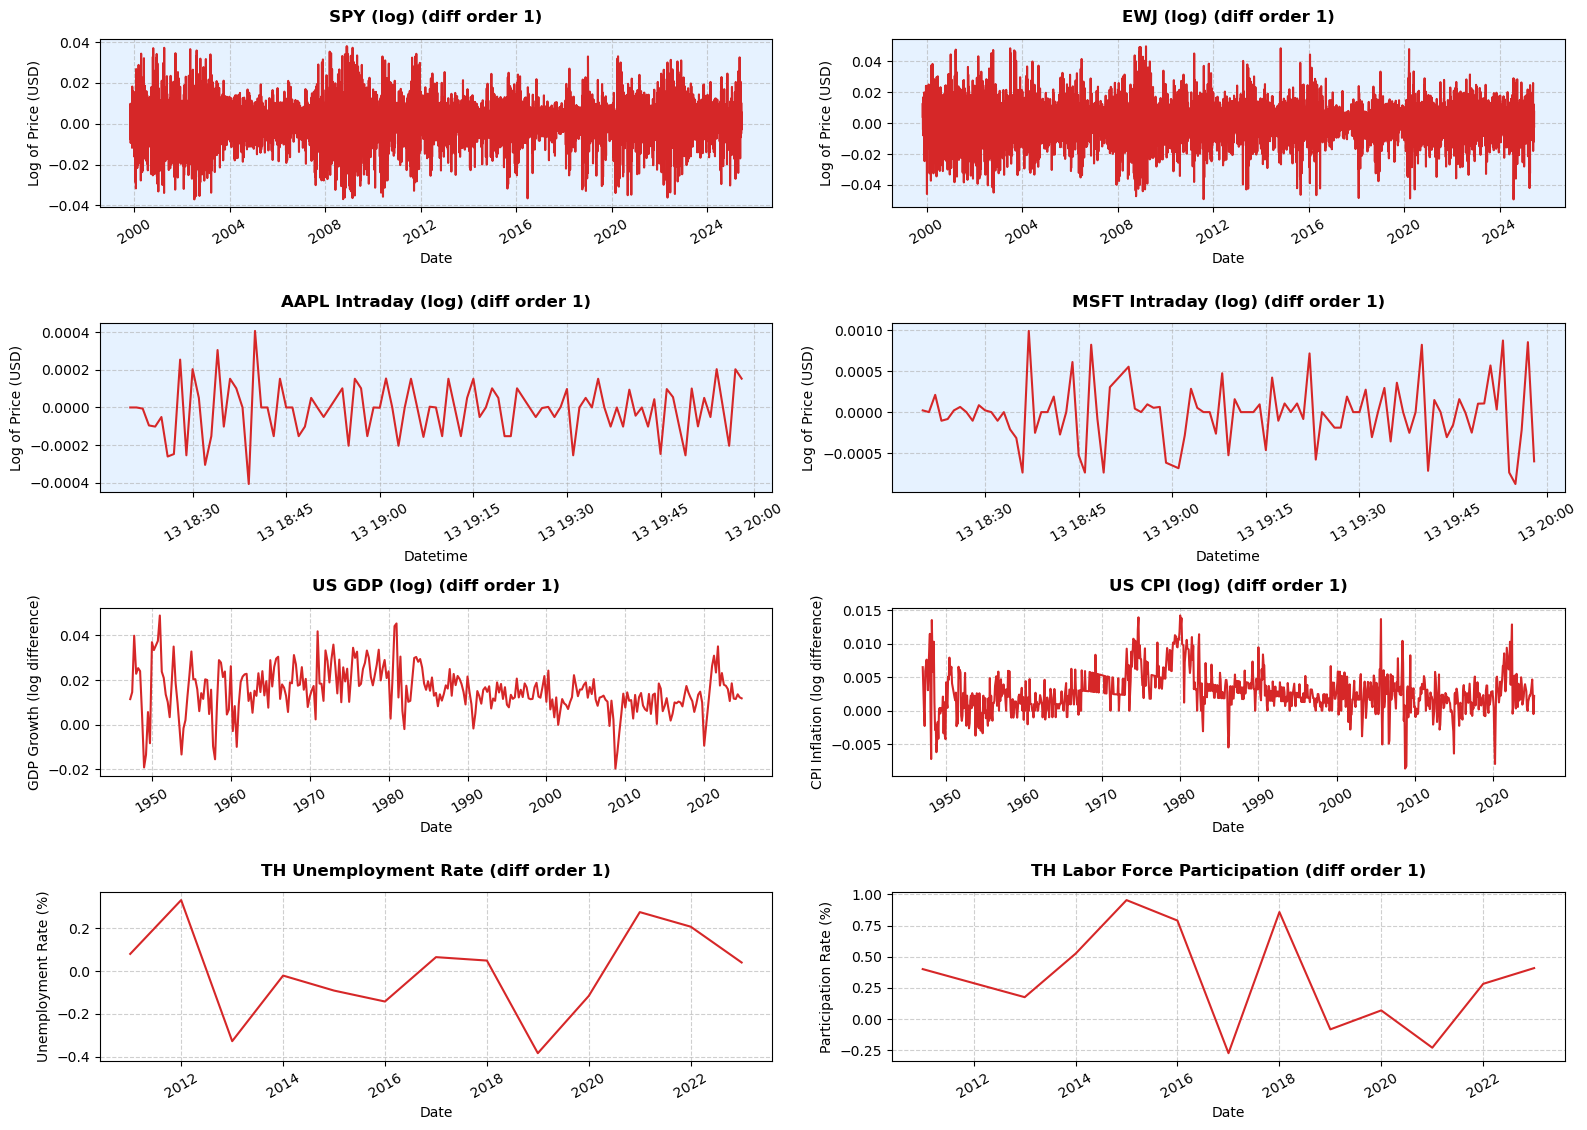

In [25]:
#| label: fig-2-processed-time-series-plot
#| fig-cap: "Line plots of the transformed training sets used for modeling and forecasting."

# --- Plot Processed Time Series
plot_time_series(all_train_series_preprocessed, y_axis_labels=y_axis_labels_preprocessed)

### Classical Forecasting Methods {#sec-classical-forecasting-methods}

In this section, four classical forecasting methods are explored, each providing a one-step-ahead forecast. These models are intentionally applied to raw, untransformed data, as they are designed for simplicity and do not account for structural features like trend or volatility:

* **Historical Average**: the historical average is a simple mean of all past observations.
* **Naive Method**: the forecasted value is equal to the previous observed value.
* **Random Walk with Drift**: similar to the Naive method, this approach includes a stochastic component and a drift parameter to account for an average increase or decrease over time.
* **Moving Average (Window Average)**: this method calculates the forecast as the mean of the most recent observations. In this specific case, an arbitrary window size of `3` is used.

The Seasonal Naive method was excluded from this analysis due to the lack of strong, consistent seasonality across all series, given their varying frequencies and domains. 

The accuracy of these methods is assessed using three standard metrics in time series forecasting: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE).

A summary of the results is presented in @tbl-classical-models-evaluation.

In [26]:
# Import StatsForecast and models
from statsforecast import StatsForecast
from statsforecast.models import HistoricAverage, Naive, RandomWalkWithDrift, WindowAverage

# Evaluation libraries (Nixtla, 2023)
from functools import partial
import utilsforecast.losses as ufl
from utilsforecast.evaluation import evaluate

# Ensures the model ID is included as a column in the prediction output,
# not as the index
import os
os.environ['NIXTLA_ID_AS_COL'] = '1'

# Define forecasting models
models_pt1 = [
    Naive(),
    HistoricAverage(),
    RandomWalkWithDrift(),
    WindowAverage(window_size=3)
]

In [27]:
# Define the frequency map
freq_map = {
    'SPY': 'D',
    'EWJ': 'D',
    'AAPL Intraday': 'min',
    'MSFT Intraday': 'min',
    'US GDP': 'QS',
    'US CPI': 'MS',
    'TH Unemployment Rate': 'YS',
    'TH Labor Force Participation': 'YS'
}

# 1-step ahead focus
test_set_size = 1

# Dictionaries to store results
all_forecasts_pt1_for_plotting = {}
all_evaluation_pt1_results_list = [] 

for series_name, raw_series in all_series:
    # Prepare DataFrame for StatsForecast
    sf_df = pd.DataFrame({
        'unique_id': series_name,
        'ds': raw_series.index,
        'y': raw_series.values
    })

    # Sort and reset index
    sf_df = sf_df.sort_values(by='ds').reset_index(drop=True)

    # Train/test split
    train_df = sf_df.iloc[:-test_set_size].copy()
    test_df = sf_df.iloc[-test_set_size:].copy()

    # Forecast horizon
    h_forecast = 1

    # Get frequency
    freq = freq_map.get(series_name)

    # Initialize StatsForecast
    sf = StatsForecast(
        models=models_pt1,
        freq=freq,
        n_jobs=-1
    )

    # Fit & predict
    sf.fit(train_df)
    forecasts_df = sf.predict(h=h_forecast)

    # Merge forecasts with actuals
    forecasts_df = forecasts_df.merge(test_df, on=['unique_id', 'ds'], how='left')

    # Store for plotting
    all_forecasts_pt1_for_plotting[series_name] = forecasts_df

    # Evaluate
    evaluation_df = evaluate(
        forecasts_df,
        metrics=[ufl.mae, ufl.mape, ufl.rmse],
        train_df=train_df,
        target_col='y'
    )

    all_evaluation_pt1_results_list.append(evaluation_df)

# Combine all evaluations into one DataFrame
combined_evaluation_classical_models_df = pd.concat(all_evaluation_pt1_results_list, 
                                                    ignore_index=True)

In [28]:
#| label: tbl-classical-models-evaluation
#| tbl-cap: "Evaluation metrics (MAE, MAPE and RMSE) for classical forecasting models"

# Display Summary Table
HTML(combined_evaluation_classical_models_df.to_html(index=False))

unique_id,metric,Naive,HistoricAverage,RWD,WindowAverage
SPY,mae,6.750000,380.062997,6.822677,5.730000
SPY,mape,0.011307,0.636621,0.011428,0.009598
SPY,rmse,6.750000,380.062997,6.822677,5.730000
EWJ,mae,0.610000,46.102891,0.619249,0.320000
EWJ,mape,0.008288,0.626398,0.008414,0.004348
EWJ,rmse,0.610000,46.102891,0.619249,0.320000
AAPL Intraday,mae,0.020000,0.046325,0.022222,0.053367
AAPL Intraday,mape,0.000102,0.000236,0.000113,0.000272
AAPL Intraday,rmse,0.020000,0.046325,0.022222,0.053367
MSFT Intraday,mae,0.010000,0.177587,0.013939,0.045000


The forecasting performance across evaluated methods reveals consistent patterns that correspond to the structural characteristics of each time series.

The Historic Average method consistently performs the worst, particularly on series with strong directional trends, such as SPY, EWJ, US GDP, US CPI and Thailand’s labor force participation. As shown in @fig-3-actual-vs-forecasts, this approach yields substantial forecast errors, most notably for US GDP, where the RMSE exceeds 22,500. This underperformance is expected, as the Historic Average simply projects the unconditional mean of past values, rendering it incapable of tracking time-varying trends or persistent movements. This results in large bias for non-stationary series, such as stock prices and macroeconomic aggregates.

By contrast, the Naive and Random Walk with Drift (RWD) methods perform significantly better on trending series. For example, the RWD model achieves the lowest MAE for US GDP (157.98) and US CPI (0.059), outperforming all others. Similarly, for SPY both Naive (MAE = 6.75) and RWD (MAE = 6.82) far surpass the Historical Average (MAE = 380.06). These models benefit from their simplicity and responsiveness: Naive forecasts the most recent value, while RWD incorporates a drift term, enabling it to capture gradual directional shifts more effectively.

High-frequency data, such as AAPL and MSFT intraday series, show much smaller absolute errors across all models, reflecting their scale. Here, differences between methods narrow: for AAPL Intraday, Naive and RWD yield nearly identical MAEs (0.02 and 0.022, respectively), and all models perform acceptably in line with expectations under the Efficient Market Hypothesis, which posits that price movements in liquid financial markets are largely unpredictable.

For more stable or mean-reverting series, such as the Thai Unemployment Rate, all models perform comparably well in absolute terms. The Naive method slightly outperforms the others (MAE = 0.040), while the Window Average performs worse (MAE = 0.269), suggesting over-responsiveness to short-term fluctuations in otherwise stable series.

The Window Average, which relies on a narrow window of three past values, shows mixed results. While it outperforms the Historic Average in trending series (e.g., SPY: MAE = 5.73 vs. 380.06), it remains less effective than Naive and RWD. Its high responsiveness allows it to adapt faster than a global mean, but its short memory fails to capture longer-term dynamics, leading to instability and higher errors in both trending and stable environments.

Overall, model performance is highly dependent on the data's underlying structure. Simpler models like Naive and RWD consistently outperform in dynamic or trending series, while more rigid or overly simplistic models like the Historic Average are unable to accommodate such behaviors.

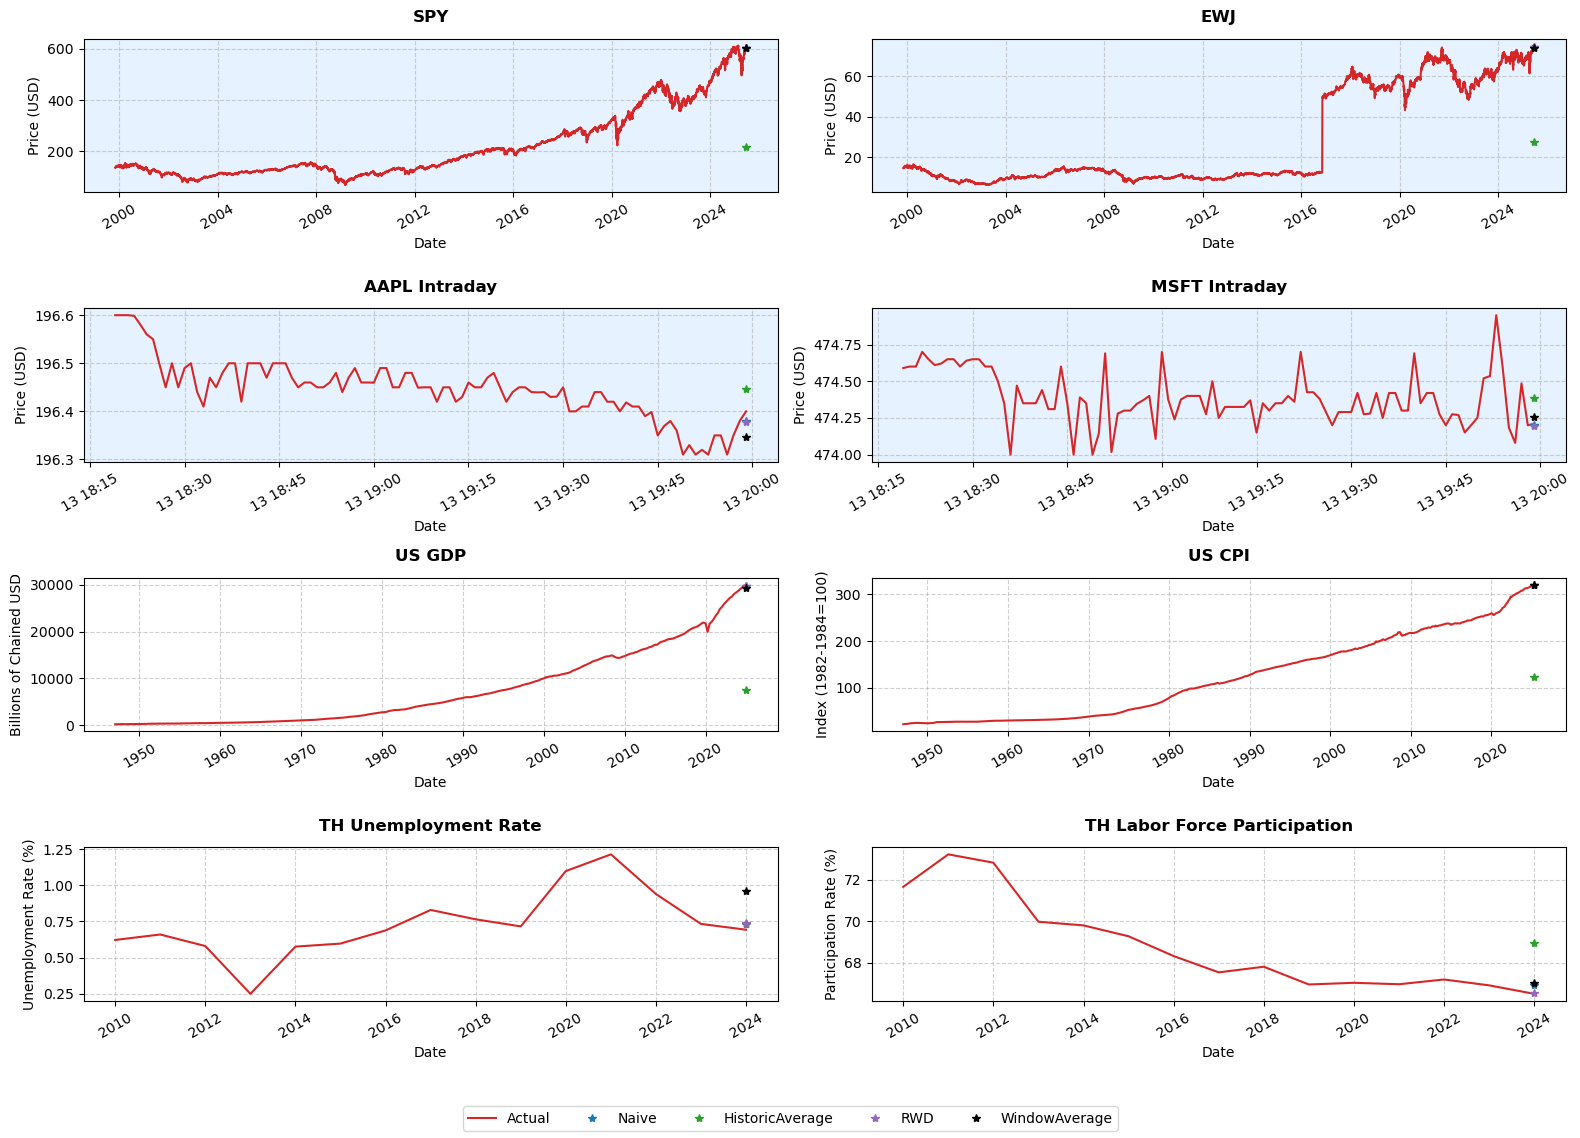

In [29]:
#| label: fig-3-actual-vs-forecasts
#| fig-cap: "Forecast accuracy comparison across models and selected time series."


# --- Plot Forecasts

# Define a list of distinct colors
colors = ['tab:blue', 'tab:green', 'tab:purple', 'black']
model_colors = {}

# Assign colors to models
for i, model in enumerate(models_pt1):
    model_name = model.__class__.__name__
    if model_name == "RandomWalkWithDrift":
        model_name = "RWD"
    if model_name not in model_colors:
        model_colors[model_name] = colors[i % len(colors)]

# Ensure dictionary access for actual series
all_series_dict = dict(all_series)

# Subplot layout
nrows, ncols = 4, 2
figsize = (16, 12)
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
axs = axs.flatten()

# Background highlight for financial series
financial_labels = ['SPY', 'EWJ', 'AAPL Intraday', 'MSFT Intraday']
financial_indices = [i for i, 
                     (label, _) in enumerate(all_series) if label in financial_labels]

# Legend tracking
legend_handles = []
legend_labels = []

# Plot loop
for i, (label, series) in enumerate(all_series):
    ax = axs[i]

    # Plot actual
    actual_line, = ax.plot(series.index, series.values, linewidth=1.5, 
                           color='tab:red', label='Actual')
    if i == 0:
        legend_handles.append(actual_line)
        legend_labels.append('Actual')

    # Plot forecasts
    forecast_df = all_forecasts_pt1_for_plotting.get(label)
    if forecast_df is not None:
        for model in models_pt1:
            model_name = model.__class__.__name__
            if model_name == "RandomWalkWithDrift":
                model_name = "RWD"
            if model_name in forecast_df.columns:
                forecast_line, = ax.plot(
                    forecast_df['ds'], forecast_df[model_name],
                    marker='*', linestyle='None',
                    color=model_colors[model_name], label=model_name
                )
                if i == 0 and model_name not in legend_labels:
                    legend_handles.append(forecast_line)
                    legend_labels.append(model_name)

    # Aesthetics
    ax.set_title(label, fontsize=12, fontweight='bold', pad=12)
    ax.grid(visible=True, which='major', linestyle='--', alpha=0.6)
    ax.tick_params(axis='x', rotation=30)
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel(y_axis_labels.get(label, 'Value'), fontsize=10)

# Highlight financial subplots
for i in financial_indices:
    axs[i].set_facecolor('#e6f2ff')

# Remove unused axes
for j in range(len(all_series), len(axs)):
    fig.delaxes(axs[j])

# Shared legend
fig.legend(
    handles=legend_handles,
    labels=legend_labels,
    loc='lower center',
    ncol=len(legend_labels),
    fontsize=10,
    frameon=True
)

# Layout
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

In conclusion, these results forcefully underscore the critical importance of accounting for trend when forecasting time series data. While simple methods like the Historic Average and a very short Window Average can serve as useful benchmarks and perform adequately on truly stationary or extremely stable series, they are fundamentally limited in their capacity to forecast series with complex patterns, particularly those exhibiting strong trends. For such series, models that inherently incorporate trend-following mechanisms, such as the Naive and Random Walk with Drift, prove to be far more effective, often serving as stronger benchmarks themselves due to their ability to capture underlying trends or random walk behavior. Ultimately, the insights gained from evaluating these foundational methods are invaluable, as they help to set performance expectations and highlight when more advanced time series techniques are necessary for capturing intricate data dynamics and achieving better forecasting performance.

### PACF and AR Modeling {#sec-part-1-pacf-ar-modelling}

This section delves into PACF analysis and AR(p) modeling. A key step before fitting autoregressive (AR) models is to examine the partial autocorrelation function (PACF) of the stationary time series to determine the appropriate lag order $p$. The PACF is computed using the Yule-Walker method (YWM) [@yule_1927; @walker_1931], which provides stable estimates for regularly spaced time series. As shown in @fig-4-pacf, six lags are used for comparison, chosen based on the typical length of the high-frequency series and to maintain consistency across assets.

In [30]:
#--- PACF Grid

# Import PACF from statsmodels
from statsmodels.graphics.tsaplots import plot_pacf

def plot_pacf_grid(series_list, lags=6, ncols=2, figsize=(14, 18), method='ywm'):
    """
    Plot PACF (Partial Autocorrelation Function) for multiple time series in a grid layout.

    Parameters:
        series_list (list of tuples): Each tuple should be (series_name, pd.Series).
        lags (int): Number of lags to include in the PACF plot.
        ncols (int): Number of columns in the subplot grid.
        figsize (tuple): Size of the entire figure (width, height).
        method (str): Method used to estimate the PACF (e.g., 'ywm', 'ols', etc.). Default is 'ywm'.

    Returns:
        None
    """
    # Determine the number of subplots needed and their layout
    nplots = len(series_list)
    nrows = (nplots + ncols - 1) // ncols  # Ensure enough rows

    # Create a grid of subplots
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axs = axs.flatten()  # Flatten in case of single row/column to simplify indexing

    # Plot PACF for each series
    for i, (name, series) in enumerate(series_list):
        ax = axs[i]
        plot_pacf(series, lags=lags, method=method, ax=ax, zero=False)
        ax.set_title(f'PACF of {name}', fontsize=12, fontweight='bold', pad=10)
        ax.grid(visible=True, which='major', linestyle='--', alpha=0.5)
        ax.set_xlabel('Lag', fontsize=10)
        ax.set_ylabel('Partial Autocorrelation', fontsize=10)

    # Remove any empty subplots if the number of plots < nrows * ncols
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    # Adjust layout to fit titles and labels nicely
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

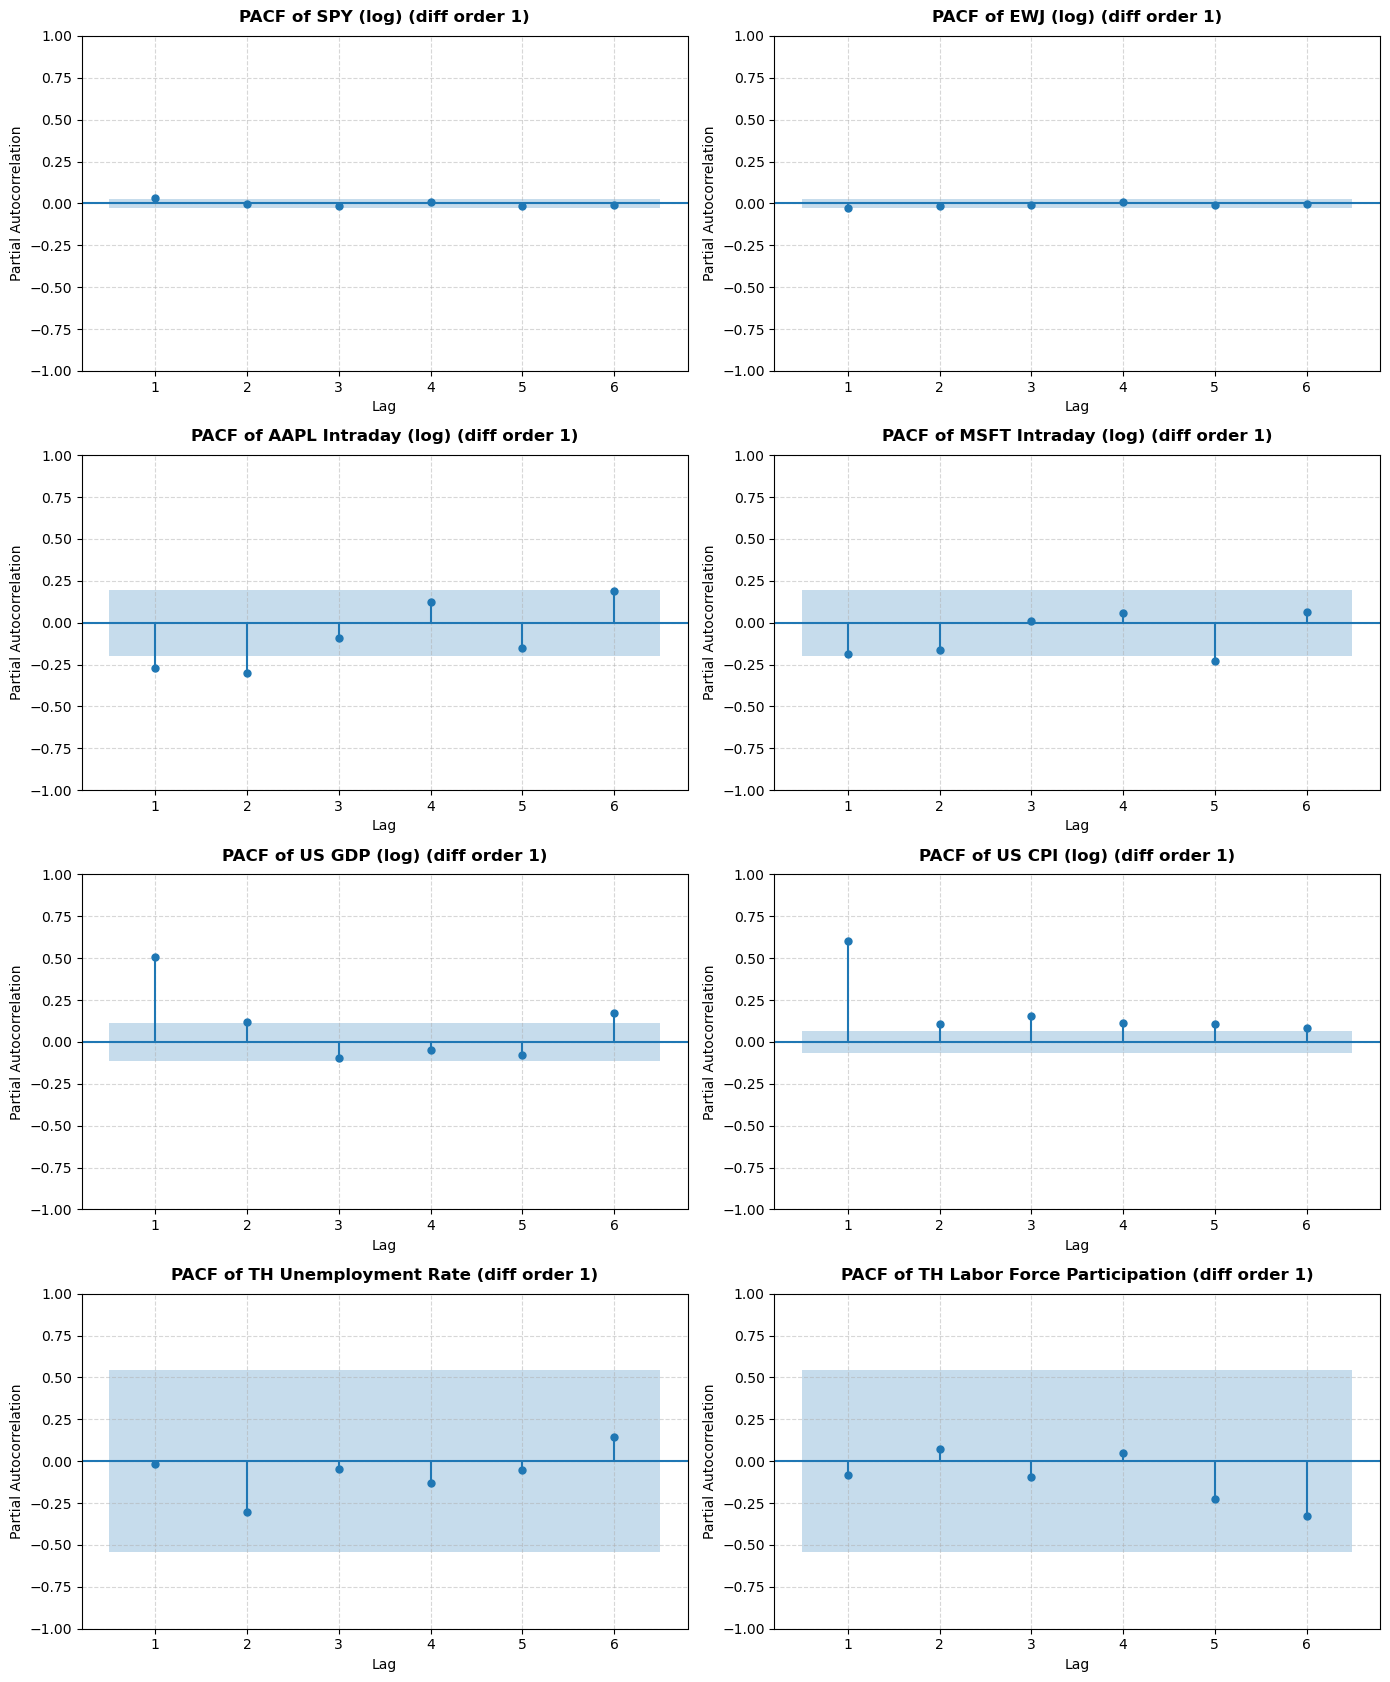

In [31]:
#| label: fig-4-pacf
#| fig-cap: "Partial Autocorrelation Function (PACF) of the training set for the selected time series"

#--- Plot PACF
plot_pacf_grid(all_train_series_preprocessed, lags=6, ncols=2)

Given the PACF plots in @fig-4-pacf, determining the AR order is more challenging than in idealized theoretical cases where the correlogram shows a clear cutoff, directly indicating the lag order $p$ of the AR model. In real-world time series, the PACF often decays gradually or exhibits ambiguous patterns, making visual identification difficult. Consequently, it is generally more reliable to fit AR models on a validation or test set and select the optimal lag order based on information criteria such as AIC, which penalizes model complexity, or forecast accuracy metrics like RMSE.

For example, the PACF of Thailand’s Unemployment Rate and Labor Force Participation suggests a lack of significant autocorrelations across lags, consistent with white noise or a weak autoregressive structure. In contrast, US GDP displays potential significant lags at 1, 2 and 6, while US CPI shows notable partial autocorrelations at lags 1 through 6. Stock indices such as SPY and EWJ resemble white noise patterns, with a possible lag at 1. For intraday data, AAPL indicates potential lags at 1 and 2, whereas MSFT’s PACF suggests lag 1 (borderline significant) and lag 5 as candidates.

Based on these observations, a simple AR(1) model was fitted to a subset of the eight time series and compared against the previously evaluated models. The choice of AR(1) was deliberate: as the most basic autoregressive model, it serves as a useful benchmark to assess improvements over classical approaches while avoiding unnecessary complexity. A summary of the AR(1) model evaluation results is presented in @tbl-ar-classical-models-evaluation.

In [32]:
# Import AR(p) from statsforecast
from statsforecast.models import AutoRegressive

In [33]:
# Take log of the full series excluding the test point (e.g., last value)
aapl_intraday_log_last = np.log(aapl_intraday.iloc[-2])
us_gdp_log_last = np.log(us_gdp.iloc[-2])
us_cpi_log_last = np.log(us_cpi.iloc[-2])
msft_intraday_log_last = np.log(msft_intraday.iloc[-2])
ewj_log_last = np.log(ewj.iloc[-2])
spy_log_last = np.log(spy.iloc[-2])

# Create a subset of the series for AR modelling
series_subset = [
    ('SPY', {
        'train_series': dict(all_train_series_preprocessed)['SPY (log) (diff order 1)'],
        'freq': 'D',
        'log_last': spy_log_last,
        'test_actual': spy.iloc[[-1]]
    }),
    ('EWJ', {
        'train_series': dict(all_train_series_preprocessed)['EWJ (log) (diff order 1)'],
        'freq': 'D',
        'log_last': ewj_log_last,
        'test_actual': ewj.iloc[[-1]]
    }),
    ('US GDP', {
        'train_series': dict(all_train_series_preprocessed)['US GDP (log) (diff order 1)'],
        'freq': 'QS',
        'log_last': us_gdp_log_last,
        'test_actual': us_gdp.iloc[[-1]]
    }),
    ('US CPI', {
        'train_series': dict(all_train_series_preprocessed)['US CPI (log) (diff order 1)'],
        'freq': 'MS',
        'log_last': us_cpi_log_last,
        'test_actual': us_cpi.iloc[[-1]]
    }),
    ('AAPL Intraday', {
        'train_series': dict(all_train_series_preprocessed)['AAPL Intraday (log) (diff order 1)'],
        'freq': 'min',
        'log_last': aapl_intraday_log_last,
        'test_actual': aapl_intraday.sort_index().iloc[[-1]]
    }),
    ('MSFT Intraday', {
        'train_series': dict(all_train_series_preprocessed)['MSFT Intraday (log) (diff order 1)'],
        'freq': 'min',
        'log_last': msft_intraday_log_last,
        'test_actual': msft_intraday.sort_index().iloc[[-1]]
    })
]

# Dictionaries to store results
all_forecasts_for_plotting = {}
all_evaluation_results_list = []
all_residuals = {}

# Set lags for AutoRegressive model
models = [AutoRegressive(lags=1, alias='AR(1)')]

# Iterate over series_subset
for series_name, data in series_subset:

    # Get individual series data
    train_series = data['train_series']
    freq = data['freq']
    log_last = data['log_last']
    test_series = data['test_actual']


    # Prepare Train/Test df for StatsForecast
    train_df = pd.DataFrame({
        'unique_id': series_name,
        'ds': train_series.index,
        'y': train_series.values
    }).sort_values('ds').reset_index(drop=True)


    test_df = pd.DataFrame({
        'unique_id': series_name,
        'ds': test_series.index,
        'y': test_series.values
    })

    
    # Initialize StatsForecast with AR(p)
    sf = StatsForecast(models=models, freq=freq, n_jobs=1) 

    # Fit the model and predict horizon=1
    sf.fit(train_df)
    forecasts_df = sf.predict(h=1)

    
    # Reconstruct the original forecast values
    forecasts_df['AR(1)'] = forecasts_df['AR(1)'] + log_last
    forecasts_df['AR(1)'] = np.exp(forecasts_df['AR(1)'])

    # Merge forecasts with actuals for evaluation
    forecasts_df = forecasts_df.merge(test_df, on=['unique_id', 'ds'], how='left')

    # Store for plotting
    all_forecasts_for_plotting[series_name] = forecasts_df

    # Evaluate forecasts using your evaluation method
    evaluation_df = evaluate(
        forecasts_df,
        metrics=[ufl.mae, ufl.mape, ufl.rmse],
        train_df=train_df,
        target_col='y'
    )

    all_evaluation_results_list.append(evaluation_df)

    # Get residuals
    result=sf.fitted_[0,0].model_
    residual=pd.DataFrame(result.get("residuals"), columns=["residual"])

    all_residuals[series_name] = residual

# Combine evaluation results
combined_evaluation_df_autoreg = pd.concat(all_evaluation_results_list, ignore_index=True)

# Merge the evaluation dafraframes
combined_all_models_df = pd.merge(
    combined_evaluation_classical_models_df,
    combined_evaluation_df_autoreg,
    on=['unique_id', 'metric'],
    how='outer'
).dropna()

In [34]:
#| label: tbl-ar-classical-models-evaluation
#| tbl-cap: "Evaluation metrics (MAE, MAPE and RMSE) for classical forecasting models and AR(1)"

# Display Summary Table
HTML(combined_all_models_df.to_html(index=False))

unique_id,metric,Naive,HistoricAverage,RWD,WindowAverage,AR(1)
AAPL Intraday,mae,0.020000,0.046325,0.022222,0.053367,0.031102
AAPL Intraday,mape,0.000102,0.000236,0.000113,0.000272,0.000158
AAPL Intraday,rmse,0.020000,0.046325,0.022222,0.053367,0.031102
EWJ,mae,0.610000,46.102891,0.619249,0.320000,0.599073
EWJ,mape,0.008288,0.626398,0.008414,0.004348,0.008140
EWJ,rmse,0.610000,46.102891,0.619249,0.320000,0.599073
MSFT Intraday,mae,0.010000,0.177587,0.013939,0.045000,0.035309
MSFT Intraday,mape,0.000021,0.000374,0.000029,0.000095,0.000074
MSFT Intraday,rmse,0.010000,0.177587,0.013939,0.045000,0.035309
SPY,mae,6.750000,380.062997,6.822677,5.730000,6.996739


As @tbl-ar-classical-models-evaluation suggests, across the majority of series and error metrics (MAE, MAPE, RMSE), the AR(1) model demonstrates competitive performance but does not consistently outperform the simpler benchmarks.

For high-frequency intraday series like AAPL and MSFT, the Naive and RWD methods achieve the lowest errors overall. The AR(1) model performs reasonably well, surpassing the Window Average method but falling short of former mentioned methods, which better capture the short-term persistence inherent in these series.

In the case of stock indices such as EWJ and SPY, the AR(1) model's performance is comparable to the Naive and RWD approaches but generally does not provide clear improvements. For example, in SPY, the Window Average method yields the lowest MAE and RMSE, suggesting that simple smoothing over recent observations might be more effective than a low-order AR model for this noisy financial data.

For macroeconomic series such as US GDP and US CPI, the AR(1) model offers notable improvements over the Naive and Historical Average methods. Specifically, for US GDP, the AR(1) model achieves the lowest RMSE and MAE values (151.58 and 151.58, respectively), outperforming even the RWD method. This indicates that the AR(1) structure can capture some of the persistence in these slower-moving series more effectively than simpler models. However, for US CPI, the AR(1) model performs worse than the RWD and Naive methods, suggesting that additional complexity or higher-order models might be necessary.

To further assess model adequacy, residual diagnostics were conducted using the Ljung-Box test [@ljung_box_1978] at `3` lags, as reported in @tbl-ljung-box. For most series, including SPY, EWJ and MSFT, the high p-values (p > 0.1) indicate no significant autocorrelation in the residuals, suggesting that the AR(1) model adequately captures the dynamics. However, for AAPL and US CPI, the test returns p-values below conventional significance thresholds (e.g., p < 0.05), implying that residuals still contain autocorrelation. This points to possible model misspecification, where a higher-order AR process or alternative modeling strategy may be more appropriate to fully capture the underlying structure.

In [35]:
# Import Ljung-box for testing the appropraiteness of the model
from statsmodels.stats.diagnostic import acorr_ljungbox

# Define the AR lags used for each model to adjust model_df for Ljung-Box test
model_ar_lags = {
    'US GDP (log) (diff order 1)': 1,
    'AAPL Intraday (log) (diff order 1)': 1,
    'MSFT Intraday (log) (diff order 1)': 1,
    'SPY (log) (diff order 1)': 1,
    'EWJ (log) (diff order 1)': 1,
    'US CPI (log) (diff order 1)': 1,
    
    
}

# Initiate ljung_box sumamry
ljung_box_summary = []

# Iterate over each seris
for series_name, residuals_df in all_residuals.items():
    residuals = residuals_df['residual']
    ar_lags_for_model = model_ar_lags.get(series_name, 0)

    # Ensure there are enough data points for the test with chosen lags
    if len(residuals) > max(10, ar_lags_for_model): 
        try:
            # Test at 3 lags
            lags_to_test = 3

            ljung_box_results = acorr_ljungbox(
                residuals,
                lags=lags_to_test,
                model_df=ar_lags_for_model, 
                return_df=True
            )
            ljung_box_results['Series'] = series_name
            ljung_box_summary.append(ljung_box_results)
        except ValueError as e:
            print(f"Warning: Ljung-Box test failed for {series_name} (lags {lags_to_test}, model_df {ar_lags_for_model}): {e}")
            print(f"Series length: {len(residuals)}")
    else:
        print(f"Skipping Ljung-Box test for {series_name}: Not enough data points ({len(residuals)}) for chosen lags.")

# Gert final_ljung_box_df
final_ljung_box_df = pd.concat(ljung_box_summary, ignore_index=True)

In [36]:
#| label: tbl-ljung-box
#| tbl-cap: "Ljung-Box test results for AR(1) residuals using 3 lags"

# Reorder columns: move 'Series' to be the first column
final_ljung_box_df = final_ljung_box_df[['Series', 'lb_stat', 'lb_pvalue']]

# Display final_ljung_box
HTML(final_ljung_box_df.to_html(index=False))

Series,lb_stat,lb_pvalue
SPY,0.000234,0.987802
SPY,0.160992,0.922659
SPY,1.437902,0.696675
EWJ,0.000822,0.977121
EWJ,1.187012,0.552387
EWJ,1.461101,0.691277
US GDP,1.136620,0.286368
US GDP,7.608279,0.022278
US GDP,7.699262,0.052654
US CPI,3.955548,0.046717


In summary, while the AR(1) model provides a useful baseline with modest improvements in some cases, especially for macroeconomic data, it does not universally outperform classical benchmarks. These results underscore the importance of model selection tailored to the specific characteristics of each time series, with simpler models sometimes providing robust and reliable forecasts, particularly for high-frequency or more volatile data. 

### Monte Carlo Simulation

This section utilizes a Monte Carlo simulation based on the geometric Brownian motion (GBM) model [@black_scholes_1973], a widely adopted framework for modeling stock prices, to project future price paths for SPY and EWJ. These assets are chosen due to their rich historical datasets, which support more reliable simulations.

I generate 1,000 simulated price trajectories spanning a 30-day horizon, based on historical log returns. The simulation assumes that log returns are normally distributed with parameters estimated from empirical mean and standard deviation of the historical series. The simulated log returns are cumulatively summed and exponentiated to produce price paths, scaled from the last observed price.

These simulated paths are shown in @fig-5-fan-chart-montecarlo-sim as fan charts depicting the 50% and 90% prediction intervals. The median path is highlighted as a robust measure of central tendency, preferred over the mean due to the potential skewness of simulated prices.

Furthermore, @fig-6-kde-montecarlo-sim displays the KDE of terminal prices, conveying the probability distribution of outcomes at the conclusion of the simulation period.

This probabilistic framework offers valuable insights into potential future price scenarios, laying the groundwork for subsequent analysis.

In [37]:
# Get SPY and EWJ returns
spy_returns = np.log(daily_df["SPY"]).diff().dropna()
ewj_returns = np.log(daily_df["EWJ"]).diff().dropna()

# Get Last Price of SPY and EWJ
last_spy_price = daily_df["SPY"].iloc[-1]
last_ewj_price = daily_df["EWJ"].iloc[-1]

In [38]:
# Define helper function for Monte Carlo Simulation
def monte_carlo_sim(log_returns, last_price, n_simulations=1000, n_days=30, seed=42):
    """
    Simulates future price paths using a geometric Brownian motion process
    based on historical log returns.

    Parameters:
        log_returns (pd.Series): Series of historical log returns.
        n_simulations (int): Number of simulated price paths to generate.
        n_days (int): Number of future time steps (e.g., trading days) to simulate.
        seed (int): Random seed for reproducibility.

    Returns:
        np.ndarray: A 2D array of shape (n_simulations, n_days) where each row
                    represents a simulated price path.
    """
    # Set random seed for reproducibility
    np.random.seed(seed)

    # Calculate the mean and standard deviation of log returns
    mu, sigma = log_returns.mean(), log_returns.std()

    # Initialize array to store simulated paths
    simulations = np.zeros((n_simulations, n_days))

    # Generate simulations
    for i in range(n_simulations):
        # Simulate future log returns using Gaussian Brownian Motion
        simulated_path = np.cumsum(np.random.normal(mu, sigma, n_days))

        # Convert log returns back to price and scale with last known price
        simulations[i] = last_price * np.exp(simulated_path)

    return simulations

In [39]:
# Import math
import math

# Define helper function for plotting fan charts
def plot_fan_chart(simulations_dict, titles, freq_minutes=None, ylabels=None):
    """
    Plots Monte Carlo fan charts for multiple simulated price paths using percentiles,
    adapting x-axis labels to the frequency of the data.

    Parameters:
        simulations_dict (dict): Dictionary where keys are identifiers 
        and values are 2D np.arrays (simulations).
        titles (list of str): Titles for each subplot.
        subtitle (str): Shared figure subtitle.
        freq_minutes (dict or None): Optional dict mapping keys in simulations_dict 
                                     to frequency in minutes. If None, defaults to 1 day per timestep.
        ylabels (str or dict or None): Optional y-axis label(s).
                                      If a string, applies same label to all subplots.
                                      If a dict, maps keys in simulations_dict to y-axis labels.
                                      If None, no y-axis label is set.

    Returns:
        None. Displays the fan charts.
    """
    n = len(simulations_dict)
    # Layout
    if n <= 2:
        rows, cols = 1, n
    else:
        cols = 2
        rows = math.ceil(n / 2)

    fig, axs = plt.subplots(rows, cols, figsize=(7 * cols, 4.5 * rows), sharey=True)
    axs = np.atleast_1d(axs).flatten()

    percentiles = [5, 25, 50, 75, 95]

    for ax, (key, simulations), title in zip(axs, simulations_dict.items(), titles):
        steps = simulations.shape[1]

        # Determine frequency for this key
        freq = None
        if isinstance(freq_minutes, dict):
            freq = freq_minutes.get(key)
        
        # Determine time labels and x-axis label
        if freq is None:
            time_labels = np.arange(1, steps + 1)
            xlabel = "Days Ahead"
        elif freq < 1440:
            time_labels = np.arange(1, steps + 1) * freq
            xlabel = "Minutes Ahead"
        else:
            time_labels = np.arange(1, steps + 1) * freq / 1440
            xlabel = "Days Ahead"

        # X ticks
        num_ticks = min(6, steps)
        tick_indices = np.linspace(0, steps - 1, num=num_ticks, dtype=int)
        x_ticks = time_labels[tick_indices]
        x_tick_labels = [f"{int(t)}" for t in x_ticks]

        # Percentile fan chart
        percentile_values = np.percentile(simulations, percentiles, axis=0)
        ax.plot(time_labels, percentile_values[2], color='black', label='Median Forecast')
        ax.fill_between(time_labels, percentile_values[1], percentile_values[3], 
                        color='blue', alpha=0.3, label='50% PI')
        ax.fill_between(time_labels, percentile_values[0], percentile_values[4], 
                        color='blue', alpha=0.1, label='90% PI')

        ax.set_title(title, fontsize=12)
        ax.set_xlabel(xlabel)
        ax.grid(True)

        if ylabels is not None:
            if isinstance(ylabels, str):
                ax.set_ylabel(ylabels)
            elif isinstance(ylabels, dict):
                ylabel = ylabels.get(key)
                if ylabel:
                    ax.set_ylabel(ylabel)

        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_tick_labels)

    # Shared title and legend
    lines = [
        plt.Line2D([0], [0], color='black', label='Median Forecast'),
        plt.Line2D([0], [0], color='blue', alpha=0.3, linewidth=10, label='50% PI'),
        plt.Line2D([0], [0], color='blue', alpha=0.1, linewidth=10, label='90% PI')
    ]
    fig.legend(handles=lines, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.02))
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

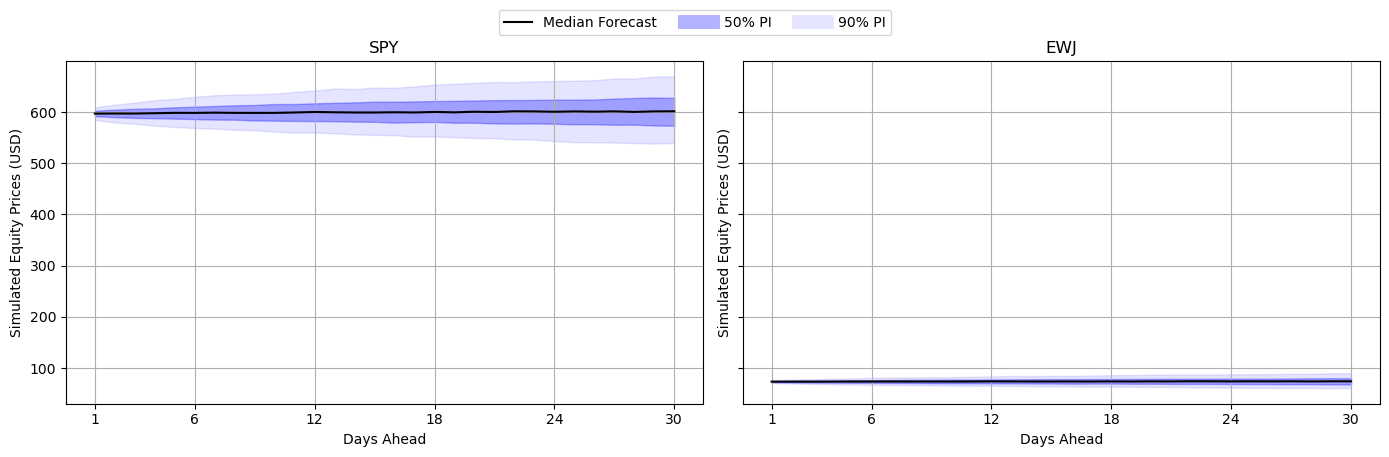

In [40]:
#| label: fig-5-fan-chart-montecarlo-sim
#| fig-cap: "Fan chart of 1,000 Monte Carlo simulated price paths for the next 30 days, showing the median forecast along with 50% and 90% prediction intervals."

# Get Simulations
sim_spy = monte_carlo_sim(spy_returns, last_spy_price)
sim_ewj = monte_carlo_sim(ewj_returns, last_ewj_price)

# Plot fan charts
simulations_dict = {'SPY': sim_spy, 'EWJ': sim_ewj}
titles=['SPY', 'EWJ']
plot_fan_chart(simulations_dict, titles=titles,
               freq_minutes=None, ylabels="Simulated Equity Prices (USD)")

The fan chart of the Monte Carlo simulations shows that projected future prices for EWJ exhibit less dispersion and narrower prediction intervals compared to SPY, indicating relatively higher stability and predictability for EWJ over the next 30 days.

Notably, the EWJ price series operates on a lower absolute price scale compared to SPY, which can make direct visual comparison more challenging. However, when adjusting for scale, it can be observed that the prediction intervals for EWJ are comparatively tighter relative to its price level. This suggests that, while EWJ prices fluctuate at a lower absolute level, their relative uncertainty in percentage terms may be smaller or similar, which adds nuance to the interpretation of volatility between the two assets. Furthermore, the observed linear growth in uncertainty over time reflects a key characteristic of GBM.

The KDEs display the right-skewed shape typical of lognormal price distributions under geometric Brownian motion and typical for financial asset prices. For SPY, the median terminal price is 601.48, with a 90% coverage interval ranging from 534.94 to 668.02. In the case of EWJ, the median is 74.23 and the 90% interval spans from 59.43 to 89.03. In both cases, current prices lie close to the respective medians.

The probability of the simulated future prices falling below the current observed price is approximately 50% for both assets, reflecting the martingale property of the price process assumed by the model, implying no directional bias in short-term price movements.

It is important to emphasize that these findings rely on the geometric Brownian motion framework, which assumes constant drift and volatility and does not capture features like volatility clustering, jumps, structural breaks or mean reversion that may exist in real market data.

In [41]:
# Import Seaborn for KDE
import seaborn as sns

# Define helper function to plot KDE
def plot_kde(simulations_dict, titles):
    """
    Plot KDEs of terminal simulated prices for multiple assets.

    Parameters:
        simulations_dict (dict): 
            Dictionary with keys as asset identifiers (e.g., 'SPY', 'EWJ') 
            and values as 2D numpy arrays of simulated price paths.
            Each array shape: (num_simulations, num_timesteps).
        titles (list of str): 
            List of titles corresponding to each asset plot, 
            used as subplot titles.

    Returns:
        None. Displays KDE plots with vertical lines showing 
        current price, median, and ±1.645 standard deviations.
    """
    n = len(simulations_dict)  # Number of assets to plot

    # Dynamic layout
    if n <= 2:
        rows, cols = 1, n
    else:
        cols = 2
        rows = math.ceil(n / cols)
        
    fig, axs = plt.subplots(rows, cols, figsize=(7 * cols, 4.5 * rows), sharex=False)
    axs = np.atleast_1d(axs).flatten()

    for ax, (key, simulations), title in zip(axs, simulations_dict.items(), titles):
        # Extract terminal prices (last timestep) from simulated paths
        terminal_values = simulations[:, -1]

        # Estimate current price from terminal values by correcting for average log-return
        avg_log_return = np.mean(np.diff(np.log(terminal_values)))
        current_price = terminal_values.mean() / np.exp(avg_log_return)
        # Calculate median and standard deviation
        median_price = np.median(terminal_values)
        std_price = np.std(terminal_values)
        lower_1645std = median_price - 1.645 * std_price
        upper_1645std = median_price + 1.645 * std_price

        # Plot Kernel Density Estimate of terminal values
        sns.kdeplot(terminal_values, fill=True, ax=ax, label="KDE")

        # Add vertical lines
        ax.axvline(current_price, color="red", linestyle="--", label="Current Price")
        ax.axvline(median_price, color="black", linestyle=":", label="Median Price")
        ax.axvline(lower_1645std, color="gray", linestyle="--", alpha=0.7, label="-1.645 Std Dev")
        ax.axvline(upper_1645std, color="gray", linestyle="--", alpha=0.7, label="+1.645 Std Dev")

        # Set titles and labels
        ax.set_title(f"{title}")
        ax.set_xlabel("Terminal Price")
        ax.set_ylabel("Density")
        ax.grid(True)

    # Custom legend (shared across subplots)
    proxy_kde = plt.Line2D([0], [0], color=sns.color_palette()[0], lw=4, label='KDE')
    proxy_current = plt.Line2D([0], [0], color='red', lw=2, linestyle='--', label='Current Price')
    proxy_median = plt.Line2D([0], [0], color='black', lw=2, linestyle=':', label='Median Price')
    proxy_std = plt.Line2D([0], [0], color='gray', lw=2, linestyle='--', alpha=0.7, 
                           label='±1.645 Std Dev (90% Coverage)')

    fig.legend(handles=[proxy_kde, proxy_current, proxy_median, proxy_std],
               loc='upper center', ncol=4, frameon=False,
               bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()



# Define helper function to print probabilities
def print_probabilities(simulations_dict, titles):
    """
    Calculate and print the probability that the terminal price
    is below the current price for each asset.

    Args:
        simulations_dict (dict): 
            Dictionary with keys as asset identifiers (e.g., 'SPY', 'EWJ') 
            and values as 2D numpy arrays of simulated price paths.
        titles (list of str): 
            List of titles corresponding to each asset.

    Returns:
        None. Prints the downside probability for each asset.
    """
    for key, simulations, title in zip(simulations_dict.keys(), simulations_dict.values(), titles):
        # Extract terminal prices from simulated paths
        terminal_values = simulations[:, -1]

        # Estimate current price as in the plotting function
        avg_log_return = np.mean(np.diff(np.log(terminal_values)))
        current_price = terminal_values.mean() / np.exp(avg_log_return)

        # Calculate the probability that terminal price < current price
        prob_downside = np.mean(terminal_values < current_price)

        # Print nicely formatted probability
        print(f"Probability that {title} ends below current price in 30 days: {prob_downside:.2%}")

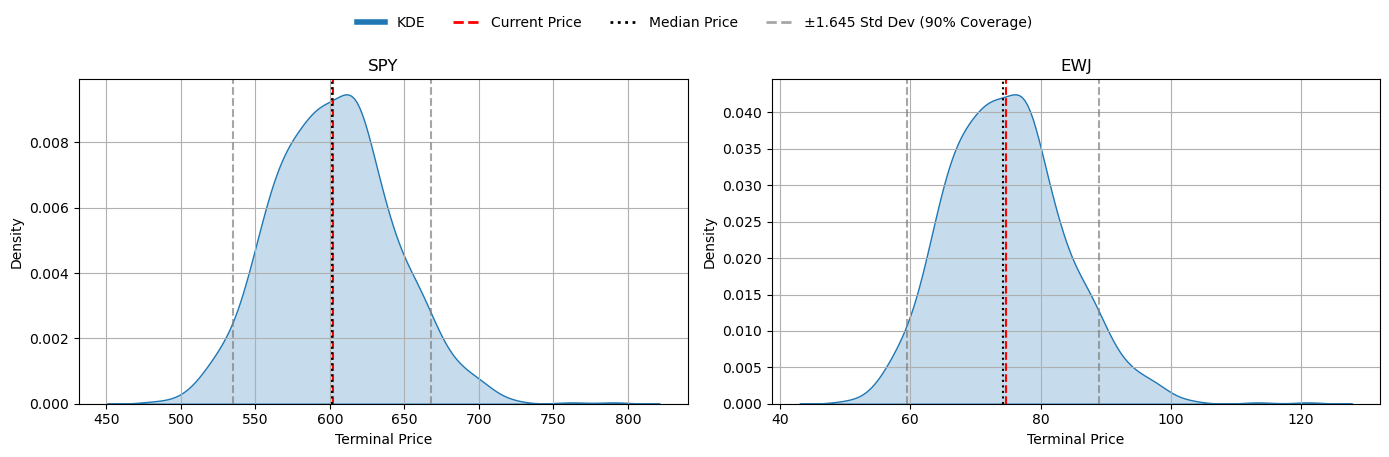

In [42]:
#| label: fig-6-kde-montecarlo-sim
#| fig-cap: "Kernel density estimate (KDE) of the simulated terminal prices after 30 days, illustrating the probability distribution of possible outcomes from the Monte Carlo simulation."

# Plot KDEs
plot_kde(simulations_dict, titles)

In [43]:
#| output: false
# Print downside probabilities
print_probabilities(simulations_dict, titles)

Probability that SPY ends below current price in 30 days: 50.50%
Probability that EWJ ends below current price in 30 days: 51.50%


In summary, Monte Carlo simulation provides a valuable framework for understanding the distribution of potential future price paths under the assumption of GBM. It enables intuitive visualization of uncertainty, through fan charts and density plots, and supports key functions in risk management and expectation setting.

Nevertheless, GBM is grounded in several simplifying assumptions, as previously noted. While useful for illustrating baseline dynamics, these assumptions may oversimplify real-world behavior, as hinted in @fig-1-time-series-plot and evident in the symmetric spread of outcomes shown in @fig-5-fan-chart-montecarlo-sim.

To address these limitations and incorporate time-dependence and memory effects observed in high-frequency data, @sec-part-2 extends the simulation framework by replacing the random walk assumption with a more flexible AR(p) process. This approach allows for serial correlation in returns while preserving the Monte Carlo framework, making it more suitable for short-term forecasting on high-frequency datasets such as currency pairs like CHF/USD and AUD/USD.

Finally, in @sec-part-3, I benchmark the performance of ARIMA, applied automatically and systematically to the chosen set of indicators. In addition, GARCH/ARCH models are introduced to specifically capture volatility dynamics in high frequency data presented in @sec-part-2, acknowledging the importance of time-varying risk and conditional heteroskedasticity in financial returns.

## Part 2 {#sec-part-2}

In this section, two high-frequency datasets, AUD/USD and CHF/USD exchange rates from January 1, 2013 to December 31, 2013, are analyzed. Autoregressive AR(p) models are fitted to the data and 25-path Monte Carlo simulations are generated to explore potential future dynamics.

#### Datasets and Visualisation

The datasets are sourced from CSV files downloaded from the University of London’s VLE. Although three years of data are available, only the most recent year was used due to local computational constraints. The data were resampled to 5-minute and 10-minute intervals for comparative analysis. As shown in @fig-7-time-series-plot, there is no visually significant difference between the two sampling frequencies for either series. Both exhibit strong trends, potential seasonality and fluctuations that require further processing and transformations to achieve stationarity.

In [44]:
# Load Datasets
aud = pd.read_csv('./AUD 07042014 2011.csv')
chf = pd.read_csv('./CHF 07042014 2011.csv')

In [45]:
# --- Initial Preprocessing for AUD and CHF minute-level datasets ---

# Combine 'Date' and 'Time' columns into a single datetime column and parse it
aud['Datetime'] = pd.to_datetime(aud['Date'] + ' ' + aud['Time'], dayfirst=True)
chf['Datetime'] = pd.to_datetime(chf['Date'] + ' ' + chf['Time'], dayfirst=True)

# Set the new datetime column as the index
aud.set_index('Datetime', inplace=True)
chf.set_index('Datetime', inplace=True)

# Sort by datetime index to ensure proper time ordering
aud = aud.sort_index()
chf = chf.sort_index()

# Keep only the 'Close' price column
aud = aud[['Close']]
chf = chf[['Close']]

# Filter data to one full calendar year for analysis (2013)
aud = aud.loc['2013-01-01':'2013-12-31']
chf = chf.loc['2013-01-01':'2013-12-31']

In [46]:
# Resample FX data to regular 5-minute and 10-minute intervals
aud_5min = aud.resample('5min').asfreq()
aud_10min = aud.resample('10min').asfreq()

chf_5min = chf.resample('5min').asfreq()
chf_10min = chf.resample('10min').asfreq()

# Linearly interpolate missing values
aud_5min = aud_5min.interpolate(method='linear')
aud_10min = aud_10min.interpolate(method='linear')

chf_5min = chf_5min.interpolate(method='linear')
chf_10min = chf_10min.interpolate(method='linear')

# Backward fill any remaining NaNs at the start
chf_5min = chf_5min.bfill()
chf_10min = chf_10min.bfill()

# Convert DataFrames to Series
aud_5min = aud_5min.squeeze()
aud_10min = aud_10min.squeeze()

chf_5min = chf_5min.squeeze()
chf_10min = chf_10min.squeeze()

In [47]:
# Get High Frequency series
high_freq_series = [
    ('AUD/USD 5-min', aud_5min),
    ('CHF/USD 5-min', chf_5min),
    ('AUD/USD 10-min', aud_10min),
    ('CHF/USD 10-min', chf_10min)
]

# Define y-axis labels specific to each series
y_axis_labels = {
    'AUD/USD 5-min': 'Exchange Rate (USD per AUD)',
    'CHF/USD 5-min': 'Exchange Rate (CHF per USD)',
    'AUD/USD 10-min': 'Exchange Rate (USD per AUD)',
    'CHF/USD 10-min': 'Exchange Rate (CHF per USD)'
}

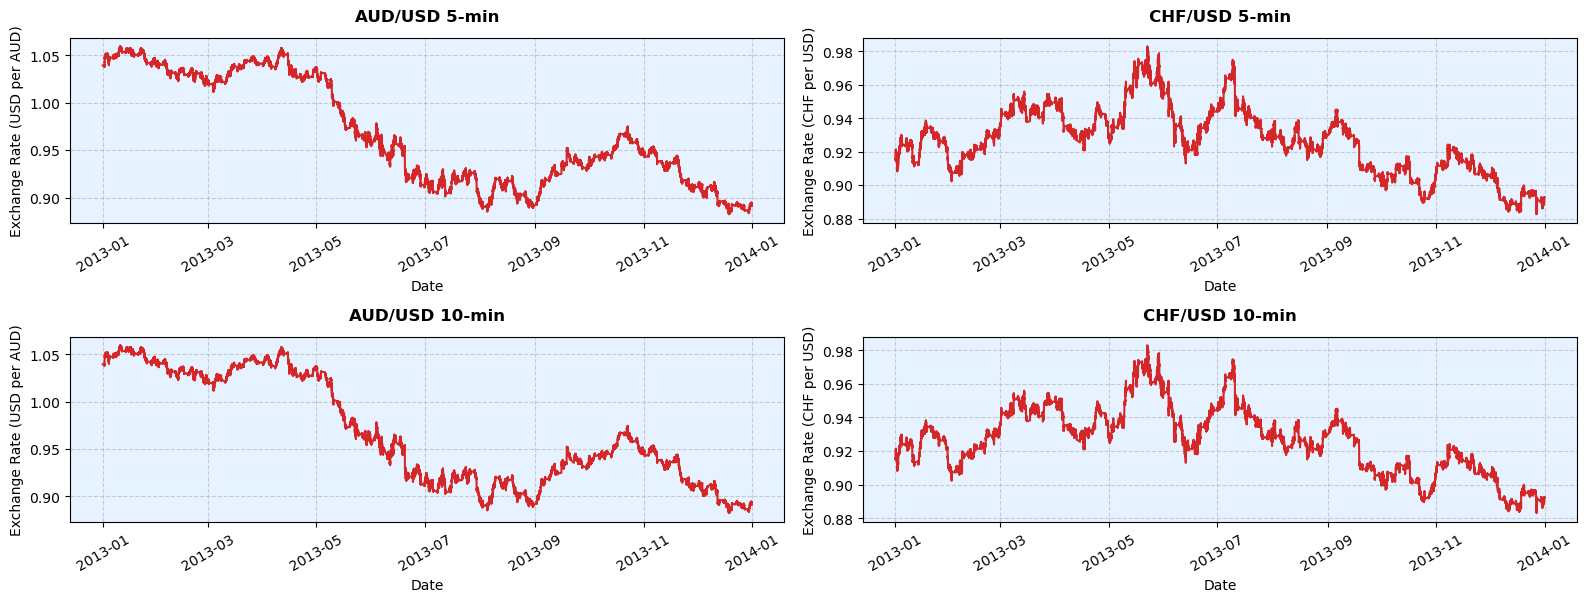

In [48]:
#| label: fig-7-time-series-plot
#| fig-cap: "Line plot of high-frequency exchange rate series for both AUD/USD and CHF/USD."


# --- Plot High Frequency Time Series

plot_time_series(high_freq_series, y_axis_labels=y_axis_labels)

### Data Preprocessing

The data are first split into training and test sets. To satisfy the assumptions of AR(p) models, the series are transformed to achieve stationarity by applying the natural logarithm followed by first-order differencing. The ADF test confirms stationarity, consistent with the approach used previously in @sec-seadj-trans-stat. A summary of the preprocessing steps is provided in @tbl-hf-stationary-summary.

In [49]:
# Split Series
all_train_hf_series, all_test_hf_series = split_series_train_test(high_freq_series,
                                                                  forecast_horizon=1)

In [50]:
# Run preprocessing
all_train_series_preprocessed_hf, stationarity_summary_hf, y_axis_labels_preprocessed_hf = process_all_series(
    all_series=all_train_hf_series,
    log_excluded=None,
    force_diff=None,
    never_diff = None,
    tight_multiplier=None,
    base_labels=y_axis_labels
)

In [51]:
#| label: tbl-hf-stationary-summary
#| tbl-cap: Summary of Stationarity and Transformation Results for High Frequency Time Series

# Display summary
HTML(stationarity_summary_hf.to_html(index=False))

Series,Log Applied,Differenced,Diff Order,Final Stationary?
AUD/USD 5-min,True,True,1,True
CHF/USD 5-min,True,True,1,True
AUD/USD 10-min,True,True,1,True
CHF/USD 10-min,True,True,1,True


Stationarity is also visually supported by the transformed series shown in @fig-8-processed-time-series-plot.

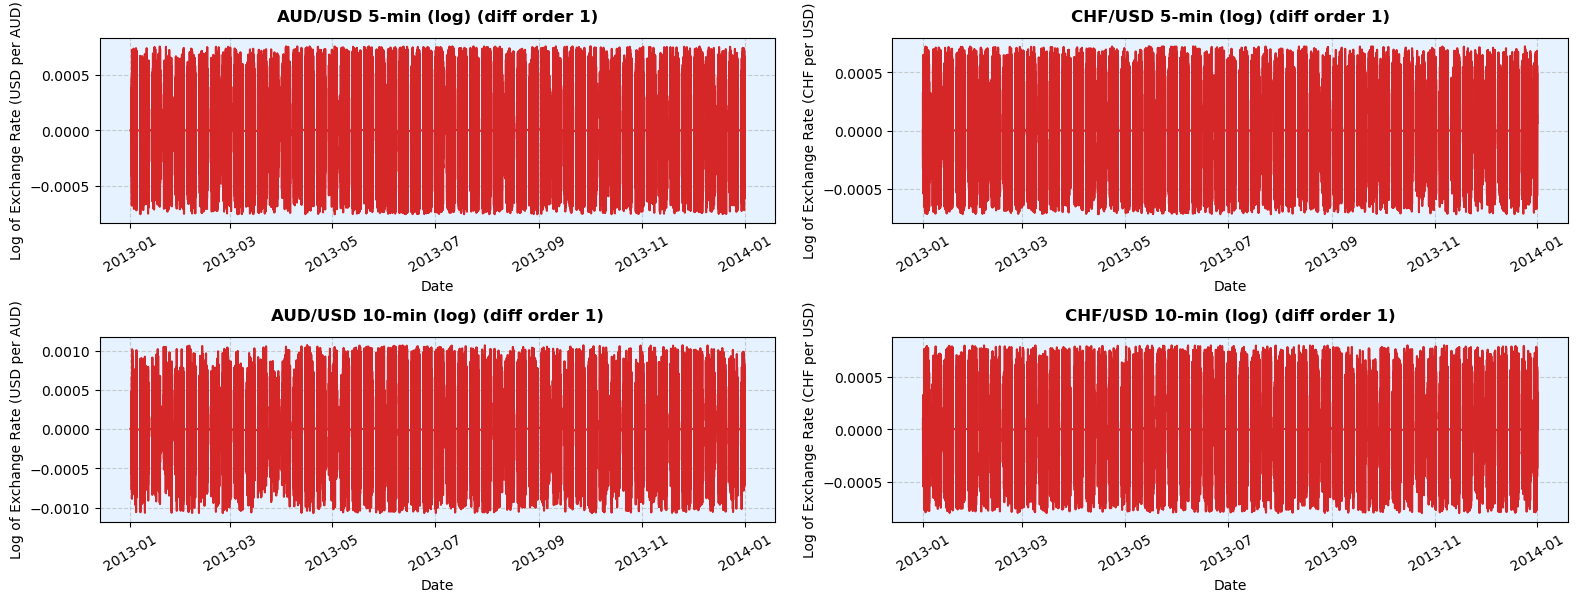

In [52]:
#| label: fig-8-processed-time-series-plot
#| fig-cap: "Line plots of the transformed training sets for AUD/USD and CHF/USD."

# --- Plot High Frequency Time Series

plot_time_series(all_train_series_preprocessed_hf, y_axis_labels=y_axis_labels_preprocessed_hf)

### PACF, ACF and AR Modeling

@fig-9-pacf and @fig-10-acf display the partial autocorrelation and autocorrelation functions for the last `10` lags. In addition to the previously discussed PACF, this section includes the autocorrelation function (ACF), which typically exhibits a gradual decay in autoregressive processes.

In [53]:
#--- ACF Grid

from statsmodels.graphics.tsaplots import plot_acf

def plot_acf_grid(series_list, lags=6, ncols=2, figsize=(14, 18)):
    """
    Plot ACF (Autocorrelation Function) for multiple time series in a grid layout.

    Parameters:
        series_list (list of tuples): Each tuple should be (series_name, pd.Series).
        lags (int): Number of lags to include in the ACF plot.
        ncols (int): Number of columns in the subplot grid.
        figsize (tuple): Size of the entire figure (width, height).

    Returns:
        None
    """
    # Calculate the number of rows needed for the subplot grid
    nplots = len(series_list)
    nrows = (nplots + ncols - 1) // ncols  # Ensures enough rows for all plots

    # Create the subplot grid
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axs = axs.flatten()  # Flatten in case of single row or column

    # Generate ACF plots for each series
    for i, (name, series) in enumerate(series_list):
        ax = axs[i]
        plot_acf(series, lags=lags, ax=ax, zero=False)  # Plot ACF
        ax.set_title(f'ACF of {name}', fontsize=12, fontweight='bold', pad=10)
        ax.grid(visible=True, which='major', linestyle='--', alpha=0.5)
        ax.set_xlabel('Lag', fontsize=10)
        ax.set_ylabel('Autocorrelation', fontsize=10)

    # Delete any unused subplot axes 
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

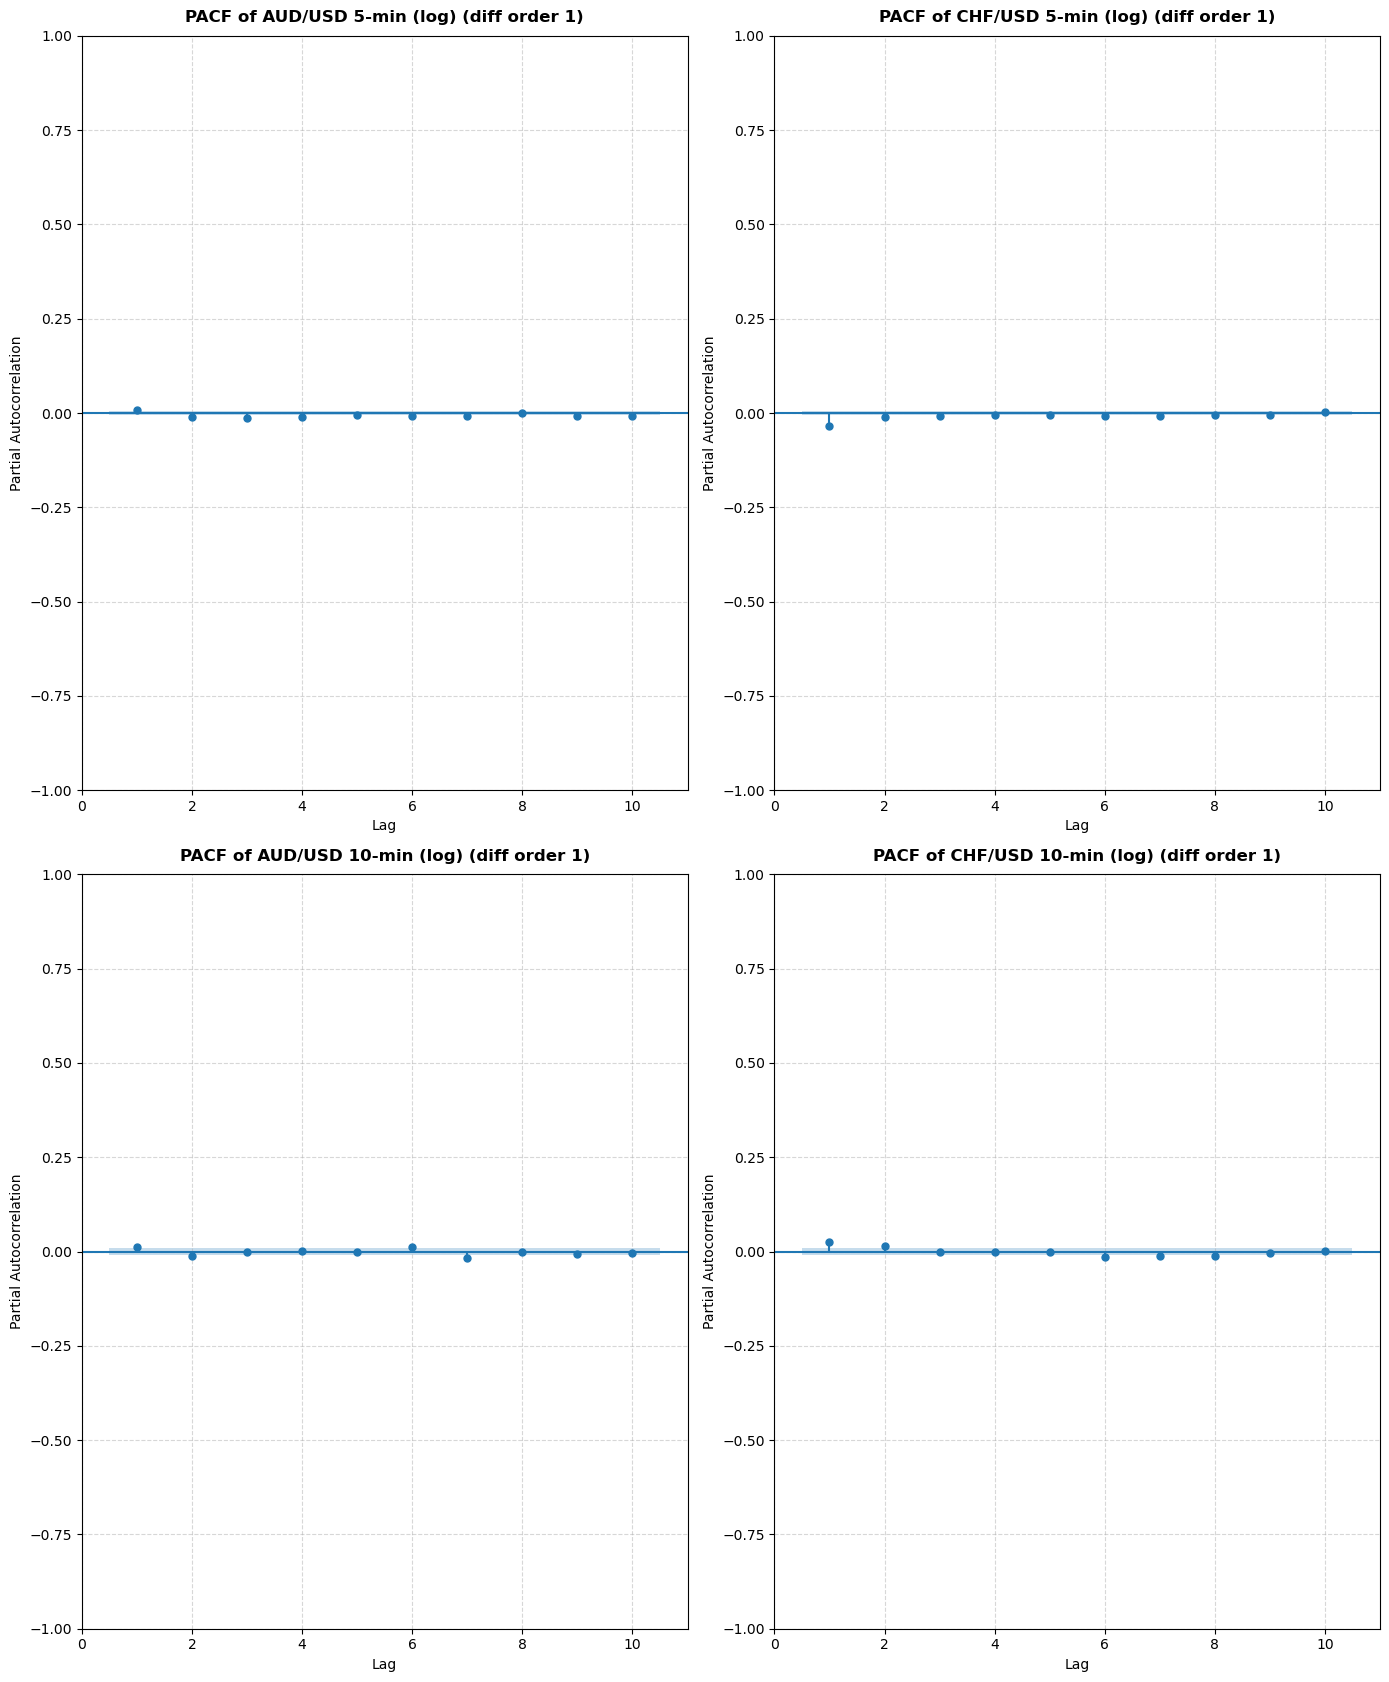

In [54]:
#| label: fig-9-pacf
#| fig-cap: "Partial Autocorrelation Function (PACF) plots for AUD/USD and CHF/USD with 10 lags."

# Plot PACF grid
plot_pacf_grid(all_train_series_preprocessed_hf, lags=10, ncols=2)

Similar to the analysis presented in @sec-part-1-pacf-ar-modelling, the PACFs of all series across both sampling frequencies do not exhibit distinct cut-offs, as would be expected in ideal AR processes. For AUD/USD at the 5-minute frequency, the PACF shows potential some degree of influence at multiple lags between 1 and 10, excluding lag 8. At the 10-minute frequency, the PACF shows near-threshold signals at lags 1, 2, 6, 7, 9 and 10. In contrast, the CHF/USD PACF at 5 minutes presents a pronounced spike at lag 1, with additional signals from lags 2 to 9, while the 10-minute series shows spikes at lags 1 and faint indications at 6, 7, 8 and 9.

These results reinforce the idea that visually determining the optimal lag length is challenging, especially in noisy high-frequency financial data. This effect is particularly notable in exchange rate series, which are known to follow near-random walk dynamics and exhibit weak, short-lived serial correlations.

Regarding the ACFs, although they more closely resemble the gradual decay expected in AR(p) processes, they still deviate from textbook examples. For instance, the AUD/USD ACF at both 5-minute and 10-minute frequencies does not exhibit a clear decay pattern but instead fluctuates near zero. In contrast, the CHF/USD ACF at 5 minutes shows a more consistent decline across lags, though not all lags approach zero, with similar behavior at the 10-minute frequency. 

These observations further emphasize that changes in sampling frequency can impact the correlation structure of the series, affecting both model identification and interpretation.

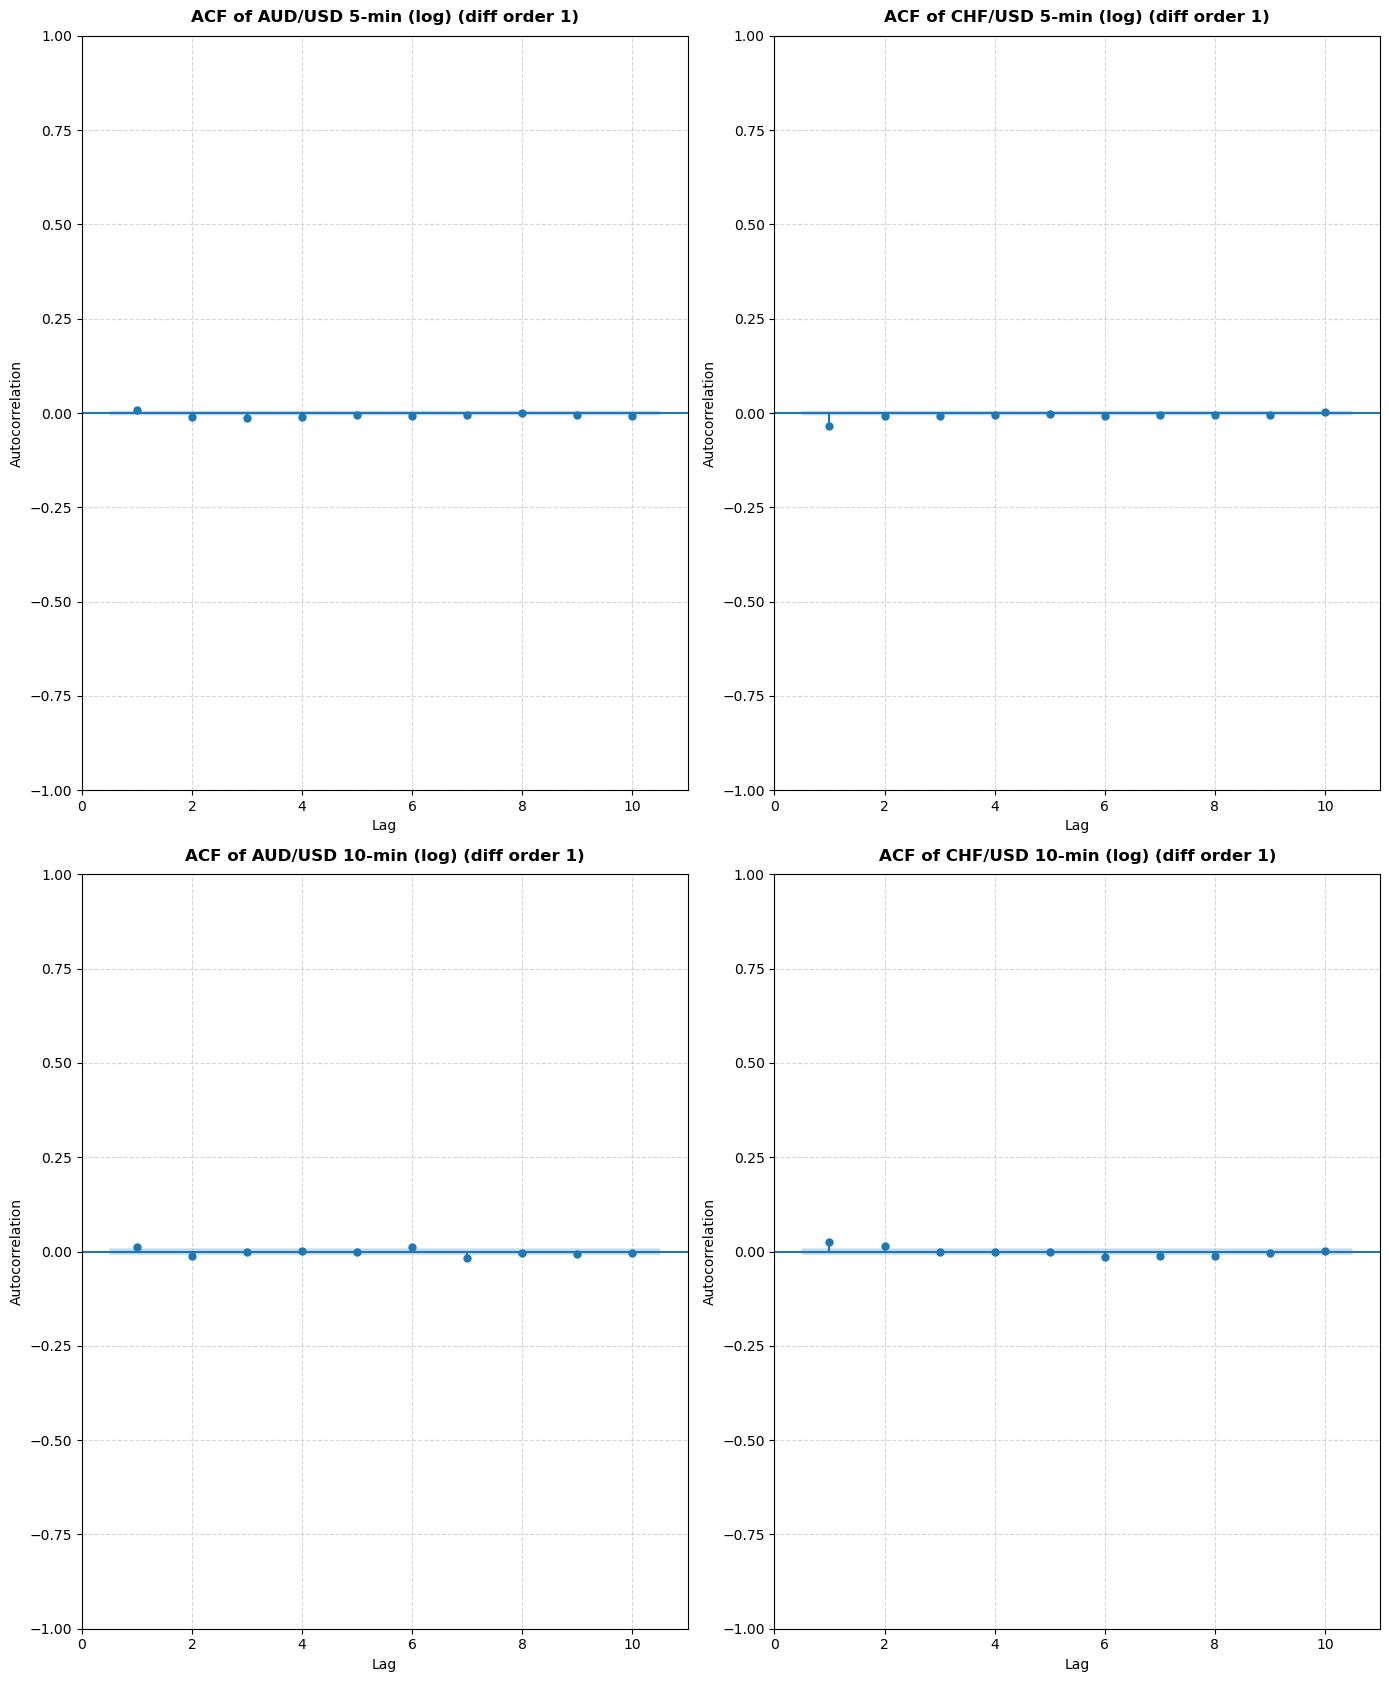

In [55]:
#| label: fig-10-acf
#| fig-cap: "Autocorrelation Function (ACF) plots for AUD/USD and CHF/USD with 10 lags."

# Plot ACF grid
plot_acf_grid(all_train_series_preprocessed_hf, lags=10, ncols=2)

### Forecasting and Evaluation

Following the visual inspection of partial autocorrelation structures, four autoregressive models, AR(1), AR(2), AR(3) and AR(4), are estimated and evaluated. These models were selected due to the generally weak autocorrelations observed across the series and based on Occam’s Razor, favoring simpler lag structures (one to four lags) to reduce the risk of overfitting. Additionally, experimental results indicated no meaningful improvement beyond three lags. Forecast accuracy is assessed using the same metrics described in @sec-classical-forecasting-methods. Model selection is based on the lowest RMSE, which penalizes larger forecast errors.

As shown in @tbl-hf-ar-evaluation, for AUD/USD at the 5-minute frequency, AR(1), AR(2) and AR(3) models perform equivalently across all metrics, each achieving an RMSE of 0.000300 and substantially outperforming the AR(4) model, which shows an high RMSE of 0.891200. At the 10-minute frequency, AR(2) slightly outperforms AR(1) and AR(3) with the lowest RMSE of 0.001419, whereas AR(4) again performs poorly.

For CHF/USD, the AR(1), AR(2) and AR(3) models yield nearly identical and very low forecast errors at both 5- and 10-minute frequencies, with RMSE values around 0.000056 and 0.000003, respectively. The AR(4) model, however, exhibits markedly worse performance, with RMSE values close to 0.89, indicating poor fit.

In [56]:
# Take log of the full series excluding the test point
aud_5min_log_last = np.log(aud_5min.iloc[:-1]).iloc[-1]
aud_10min_log_last = np.log(aud_10min.iloc[:-1]).iloc[-1]
chf_5min_log_last = np.log(chf_5min.iloc[:-1]).iloc[-1]
chf_10min_log_last = np.log(chf_10min.iloc[:-1]).iloc[-1]


# Subset the series to model
series_subset = [
    ('AUD/USD 5-min', {
        'train_series': dict(all_train_series_preprocessed_hf)['AUD/USD 5-min (log) (diff order 1)'],
        'freq': '5min',
        'log_applied': True,
        'differenced': True,
        'log_last': aud_5min_log_last,
        'test_actual': aud_5min.sort_index().iloc[[-1]]
    }),
    ('AUD/USD 10-min', {
        'train_series': dict(all_train_series_preprocessed_hf)['AUD/USD 10-min (log) (diff order 1)'],
        'freq': '10min',
        'log_applied': True,
        'differenced': True,
        'log_last': aud_10min_log_last,
        'test_actual': aud_10min.sort_index().iloc[[-1]]
    }),
    ('CHF/USD 5-min', {
        'train_series': dict(all_train_series_preprocessed_hf)['CHF/USD 5-min (log) (diff order 1)'],
        'freq': '5min',
        'log_applied': True,
        'differenced': True,
        'log_last': chf_5min_log_last,
        'test_actual': chf_5min.sort_index().iloc[[-1]]
    }),
    ('CHF/USD 10-min', {
        'train_series': dict(all_train_series_preprocessed_hf)['CHF/USD 10-min (log) (diff order 1)'],
        'freq': '10min',
        'log_applied': True,
        'differenced': True,
        'log_last': chf_10min_log_last,
        'test_actual': chf_10min.sort_index().iloc[[-1]]
    })
]

# Dictionaries to store results
all_forecasts_hf_for_plotting = {}
all_evaluation_hf_results_list = []
all_residuals = {}

# Define models
models_hf = [
    AutoRegressive(lags=1, alias='AR(1)'),  
    AutoRegressive(lags=2, alias='AR(2)'),  
    AutoRegressive(lags=3, alias='AR(3)'),
    AutoRegressive(lags=4, alias='AR(4)')
]

# Iterate over series_subset
for series_name, data in series_subset:

    # Get individual series data
    train_series = data['train_series']
    freq = data['freq']
    log_last = data['log_last']
    test_series = data['test_actual']


    # Prepare Train/Test df for StatsForecast
    train_df = pd.DataFrame({
        'unique_id': series_name,
        'ds': train_series.index,
        'y': train_series.values
    }).sort_values('ds').reset_index(drop=True)


    test_df = pd.DataFrame({
        'unique_id': series_name,
        'ds': test_series.index,
        'y': test_series.values
    })

    
    # Initialize StatsForecast
    sf = StatsForecast(models=models_hf, freq=freq, n_jobs=1) 

    # Fit the models and predict horizon=1
    sf.fit(train_df)
    forecasts_df = sf.predict(h=1)

    
    # Reconstruct the original forecast values
    for col in ['AR(1)', 'AR(2)', 'AR(3)']:
        forecast_vals = forecasts_df[col]
    
        if data.get('differenced', False) and data.get('log_applied', False):
            # log + diff
            forecasts_df[col] = np.exp(forecast_vals + data['log_last'])
    
        elif not data.get('differenced', False) and data.get('log_applied', False):
            # log only
            forecasts_df[col] = np.exp(forecast_vals)
    
        elif data.get('differenced', False) and not data.get('log_applied', False):
            # diff only
            # you need to store 'last_value' instead of 'log_last' in this case
            forecasts_df[col] = forecast_vals + data['last_value']
    
        else:
            # raw forecast
            forecasts_df[col] = forecast_vals

    # Merge forecasts with actuals for evaluation
    forecasts_df = forecasts_df.merge(test_df, on=['unique_id', 'ds'], how='left')


    # Store for plotting
    all_forecasts_hf_for_plotting[series_name] = forecasts_df

    # Evaluate forecasts using your evaluation method
    evaluation_df = evaluate(
        forecasts_df,
        metrics=[ufl.mae, ufl.mape, ufl.rmse],
        train_df=train_df,
        target_col='y'
    )

    all_evaluation_hf_results_list.append(evaluation_df)

    # Get all AR model results
    all_ar_model_results = {}
    
    for series_name, data in series_subset:
        
        # Initialize dict to hold results per model for this series
        all_ar_model_results[series_name] = {}
        
        for model_idx, model in enumerate(models_hf):
            model_name = model.alias if hasattr(model, 'alias') else model.__class__.__name__
    
            try:
                # Extract result
                fitted_model = sf.fitted_[0, model_idx].model_
    
                # Extract residuals
                residuals = pd.DataFrame(fitted_model.get("residuals"), columns=["residual"])
    
                # Extract coefficients
                coef = fitted_model.get("coef")
    
                # Extract sigma²
                sigma2 = fitted_model.get("sigma2")

    
                # Store in dictionary
                all_ar_model_results[series_name][model_name] = {
                    'coef': coef,
                    'sigma2': sigma2,
                    'residuals': residuals
                }
    
            except Exception as e:
                print(f"Failed to extract results for {series_name} with model {model_name}: {e}")
                all_ar_model_results[series_name][model_name] = None


# Combine evaluation results
combined_evaluation_df_pt2 = pd.concat(all_evaluation_hf_results_list, ignore_index=True)

In [57]:
#| label: tbl-hf-ar-evaluation
#| tbl-cap: "Evaluation of AR(1) to AR(4) models for all high-frequency series."

# Display Evaluation table
HTML(combined_evaluation_df_pt2.to_html(index=False))

unique_id,metric,AR(1),AR(2),AR(3),AR(4)
AUD/USD 5-min,mae,0.000300,0.000300,0.000300,0.891200
AUD/USD 5-min,mape,0.000336,0.000336,0.000336,1.000000
AUD/USD 5-min,rmse,0.000300,0.000300,0.000300,0.891200
AUD/USD 10-min,mae,0.001431,0.001419,0.001420,0.891211
AUD/USD 10-min,mape,0.001606,0.001592,0.001593,1.000012
AUD/USD 10-min,rmse,0.001431,0.001419,0.001420,0.891211
CHF/USD 5-min,mae,0.000056,0.000056,0.000056,0.892799
CHF/USD 5-min,mape,0.000063,0.000063,0.000063,0.999999
CHF/USD 5-min,rmse,0.000056,0.000056,0.000056,0.892799
CHF/USD 10-min,mae,0.000003,0.000003,0.000003,0.892397


Based on RMSE, the best-performing models are:

* AUD/USD 5-min: AR(1), AR(2), or AR(3) (all equivalent, with AR(1) preferred for its simpler parameterization).
* AUD/USD 10-min: AR(2).
* CHF/USD 5-min: AR(1).
* CHF/USD 10-min: AR(3).

In [58]:
# Filter for RMSE only
rmse_df = combined_evaluation_df_pt2[combined_evaluation_df_pt2['metric'] == 'rmse']

# Exclude RWD column for model selection
model_cols = ['AR(1)', 'AR(2)', 'AR(3)', 'AR(4)']

best_models = {}

for uid in rmse_df['unique_id'].unique():
    row = rmse_df[rmse_df['unique_id'] == uid]
    # Get model with lowest RMSE
    best_model = row[model_cols].idxmin(axis=1).values[0]
    best_models[uid] = best_model

@fig-11-best-ar-residuals shows diagnostic plots for the selected AR(p) models using `35` lags. Residuals appear random over time, roughly normally distributed and show no significant autocorrelation. These results confirm the models fit well and are suitable for further analysis.

In [59]:
# Import stats from scipy
from scipy import stats

# Define helper function to plot residuals
def plot_residual_diagnostics(residuals, series_name='', model_name='', lags=35):
    """
    Generate a 2x2 grid of diagnostic plots for residuals of a time series model.

    Parameters:
        residuals (pd.Series or pd.DataFrame): Residual values from a time series model.
        series_name (str): Optional. Name of the time series being analyzed (for title).
        model_name (str): Optional. Name of the model used (for title).
        lags (int): Maximum number of lags to use in the ACF plot.

    Returns:
        None
    """
    # Ensure input is a Series (squeeze in case of single-column DataFrame)
    if isinstance(residuals, pd.DataFrame):
        residuals = residuals.squeeze()

    # Set up a 2x2 grid for diagnostic plots
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    # 1. Plot residuals over time to check for non-random patterns
    residuals.plot(ax=axs[0, 0])
    axs[0, 0].set_title("Residuals over Time")
    axs[0, 0].set_xlabel("Time")
    axs[0, 0].set_ylabel("Residual")

    # 2. Plot distribution and KDE of residuals to assess normality
    sns.histplot(residuals, kde=True, ax=axs[0, 1], color='skyblue')
    axs[0, 1].set_title("Density Plot of Residuals")

    # 3. Q-Q plot to visually check for normality
    stats.probplot(residuals, dist="norm", plot=axs[1, 0])
    axs[1, 0].set_title("Q-Q Plot")

    # 4. Autocorrelation plot to check for serial correlation in residuals
    max_lags = min(lags, len(residuals) - 1)  # Ensure lags do not exceed data length
    plot_acf(residuals, lags=max_lags, ax=axs[1, 1], color="fuchsia")
    axs[1, 1].set_title("Autocorrelation (ACF)")

    # Adjust layout to prevent overlap and ensure a nice fit
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

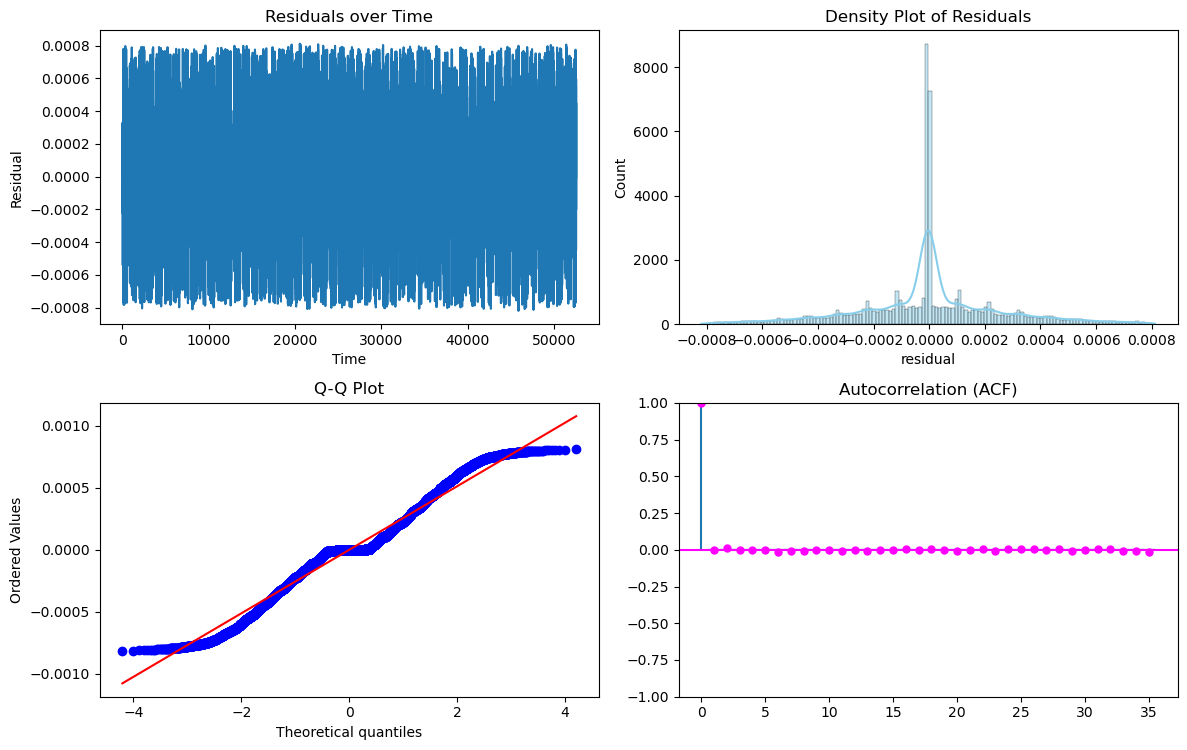

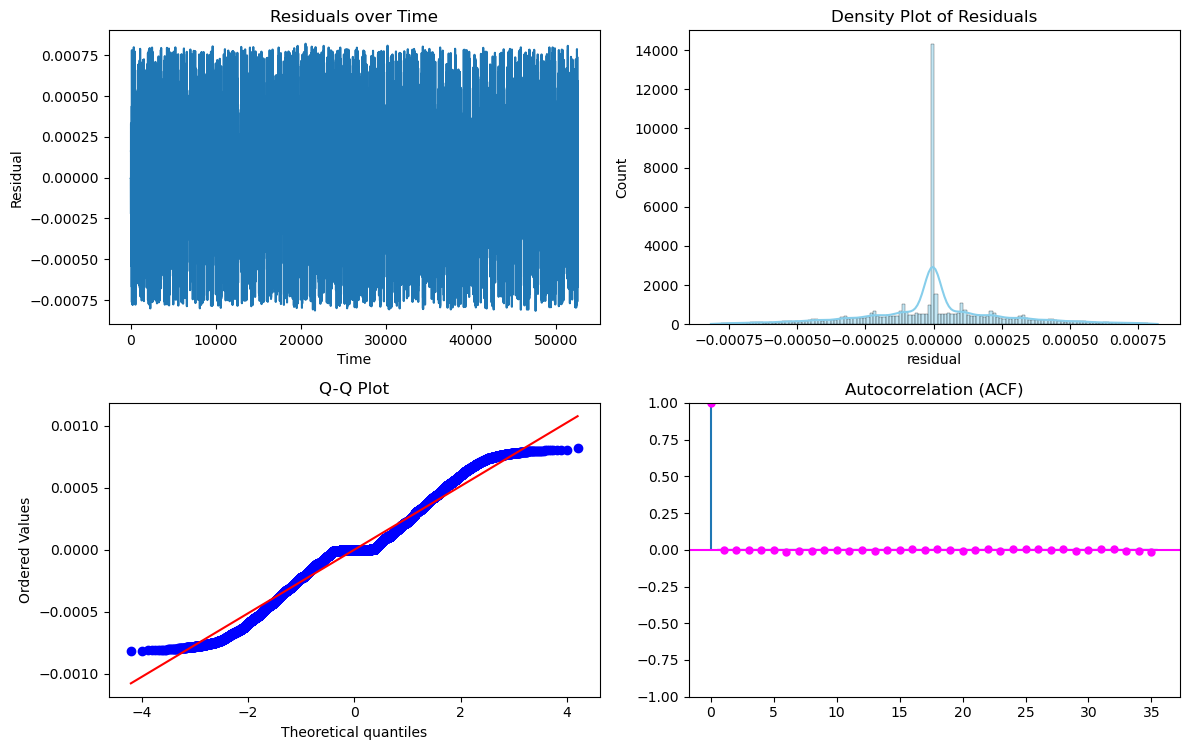

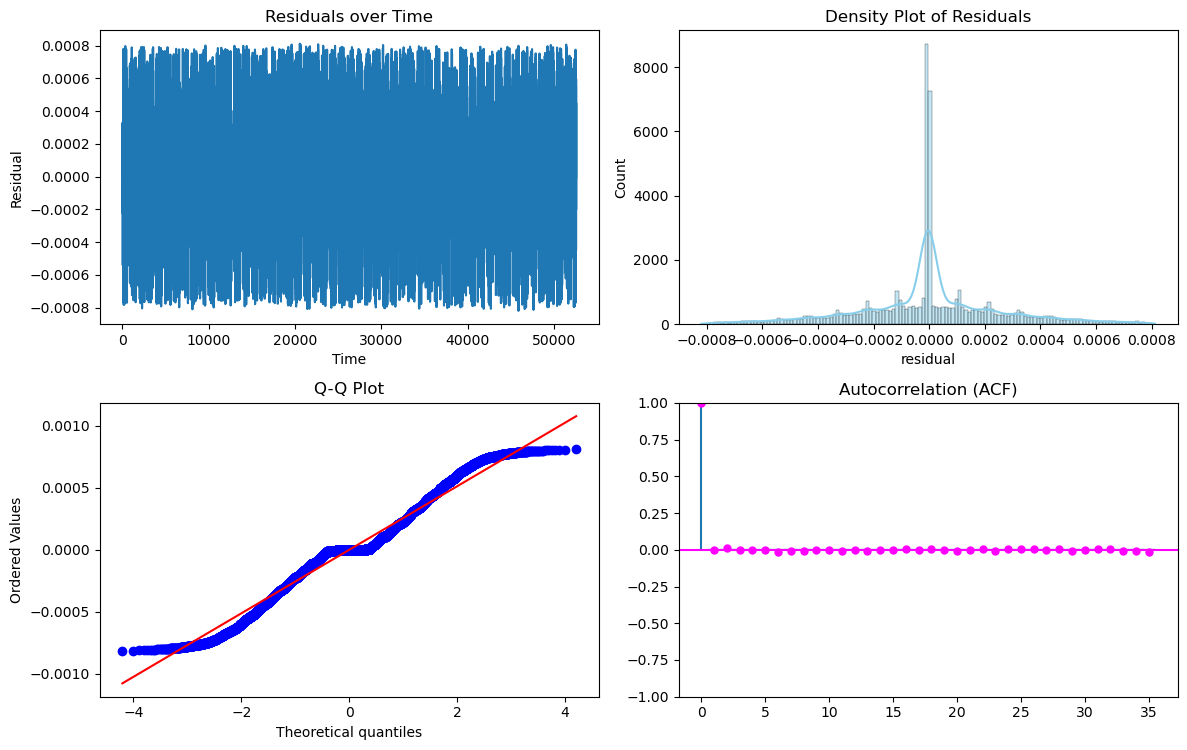

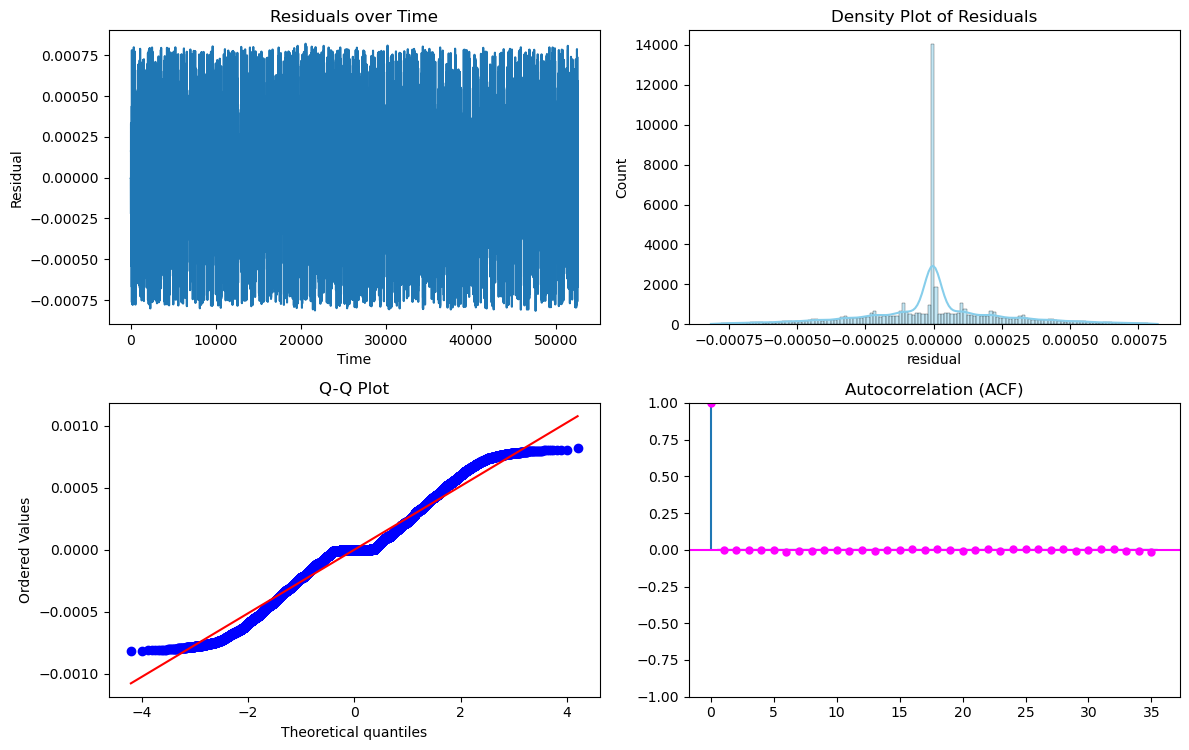

In [60]:
#| label: fig-11-best-ar-residuals
#| fig-cap: "AR Residual Diagnostics."
#| fig-subcap: 
#|   - "AUD/USD 5-min." 
#|   - "AUD/USD 10-min." 
#|   - "CHF/USD 5-min."  
#|   - "CHF/USD 10-min."

# Iterate over the best model for each series
for series_name, model_name in best_models.items():
    # Retrieve the model results (including residuals) for the current series and model
    result = all_ar_model_results[series_name][model_name]
    
    # Extract residuals from the model result
    residual_df = result['residuals']

    # Plot diagnostic charts for the residuals of the current model and series
    plot_residual_diagnostics(residual_df, series_name=series_name, model_name=model_name)

### Monte Carlo Simulation Forecasting and KDE

The final section of Part 2 presents `25` Monte Carlo simulations for all series, along with KDE plots of the simulated terminal prices. These plots provide insight into the empirical distribution of future prices and their associated risk profiles.

In [61]:
# --- Monte Carlo Simulation using Autoregressive (AR) model

def monte_carlo_ar_sim(coefs, intercept, sigma2, start_values, n_simulations=25, n_steps=15, seed=42):
    """
    Simulate multiple paths of an AR(p) process using Monte Carlo simulation.

    Parameters:
        coefs (list or array-like): Coefficients of the AR(p) model (length = p).
        intercept (float): Intercept term in the AR model.
        sigma2 (float): Variance of the white noise (innovation) term.
        start_values (list or array-like): Initial values to start the AR process (length >= p).
        n_simulations (int): Number of Monte Carlo simulation paths to generate. Default is 25.
        n_steps (int): Number of time steps to simulate for each path. Default is 15.
        seed (int): Random seed for reproducibility. Default is 42.

    Returns:
        simulations (ndarray): A 2D NumPy array of shape (n_simulations, n_steps),
                               where each row is a simulated AR(p) path.
    """
    np.random.seed(seed)  # Set seed for reproducibility

    p = len(coefs)  # Order of the AR model
    simulations = np.zeros((n_simulations, n_steps))  # Initialize output array

    # Run Monte Carlo simulations
    for sim in range(n_simulations):
        history = list(start_values.copy())  # Initialize history with starting values
        for step in range(n_steps):
            # Compute lagged terms using AR coefficients
            lagged_terms = sum(coefs[i] * history[-(i + 1)] for i in range(p))
            # Generate a random shock from normal distribution
            innovation = np.random.normal(loc=0, scale=np.sqrt(sigma2))
            # Compute next value using AR equation
            next_value = intercept + lagged_terms + innovation
            # Store the value in the simulation matrix
            simulations[sim, step] = next_value
            # Append new value to history for future lags
            history.append(next_value)

    return simulations

In [62]:
#| output: false

# Create a dictionary to map series names to their corresponding data series
series_lookup = {name: df for name, df in high_freq_series}

# Initialize a dictionary to store simulation results for each high-frequency series
simulations_hf_dict = {}

# Loop over each series and its best model to perform Monte Carlo AR simulations
for series_name, model_name in best_models.items():
    try:
        # Retrieve the fitted model results for the given series and model
        model_result = all_ar_model_results[series_name][model_name]
        
        # Extract the coefficient dictionary from the model result
        coefs_dict = model_result['coef']
        
        # Parse AR coefficients in order, filtering keys that start with 'ar'
        coefs = np.array([v for k, v in sorted(coefs_dict.items()) if k.startswith('ar')])
        intercept = coefs_dict.get('intercept', 0.0)  # Get intercept or default to 0
        sigma2 = model_result['sigma2']  # Variance of the noise term
        p = len(coefs)  # Order of the AR model

        # Retrieve the full time series from lookup and truncate last observation (training set)
        full_series = series_lookup[series_name]
        train_series = full_series.iloc[:-1]

        # Take logarithm of training data to stabilize variance
        log_train_series = np.log(train_series.dropna())
        # Take the log-returns for simulations
        log_train_returns = log_train_series.diff().dropna()
        
        # Use the last p values as starting values for AR simulation
        start_values = log_train_returns[-p:].values

        # Run Monte Carlo simulations of the AR process:
        # 25 simulation paths, each with 10 time steps
        simulations = monte_carlo_ar_sim(
            coefs=coefs,
            intercept=intercept,
            sigma2=sigma2,
            start_values=start_values,
            n_simulations=25,
            n_steps=10,
            seed=42
        )

        # Get last price
        last_price = train_series.iloc[-1]

        # Get price back from log returns
        simulated_price = last_price * np.exp(np.cumsum(simulations, axis=1))

        # Store the simulated price paths in the results dictionary
        simulations_hf_dict[series_name] = simulated_price

        print(f"Simulated AR({p}) for '{series_name}'.")

    except Exception as e:
        # Catch and print any errors during processing to continue with other series
        print(f"Error processing {series_name}: {e}")

Simulated AR(1) for 'AUD/USD 5-min'.
Simulated AR(2) for 'AUD/USD 10-min'.
Simulated AR(1) for 'CHF/USD 5-min'.
Simulated AR(3) for 'CHF/USD 10-min'.


In [63]:
# Define Frequency Map for Fan Chart
freq_map = {
    'AUD/USD 5-min': 5,
    'AUD/USD 10-min': 10,
    'CHF/USD 5-min': 5,
    'CHF/USD 10-min': 10
}

@fig-12-montecarlo-simulations-ar displays `25` Monte Carlo simulation paths generated from the fitted AR(p) models for the AUD/USD and CHF/USD exchange rates, at both 5-minute and 10-minute frequencies. Each panel displays 50% and 90% prediction intervals (PIs) derived from the simulated distributions. The median is reported as a more robust measure of central tendency than the mean, particularly in the presence of skewed distributions. Simulations are initialized at recent median price levels—approximately 0.8909 for the 5-minute AUD/USD and 0.8928 for CHF/USD, with corresponding 10-minute medians at 0.8926 and 0.8924, respectively. Across all series, the median forecast path evolves gradually, with limited directional movement, reflecting the low persistence typically observed in high-frequency FX data. The 50% PIs remain relatively narrow over the forecast horizon, while the 90% PIs expand more substantially, illustrating the compounding of uncertainty over time. Despite the change in sampling frequency, the qualitative behavior of the simulations remains consistent: the paths reflect weak autocorrelation structures and high volatility, characteristic of currency markets.

Notably, while the AR(p) models employed are stationary, the simulated medians visually resemble a drift-like evolution, which is often interpreted as weak predictability in systems with near-zero autocorrelation. The close similarity between results at the two frequencies suggests that temporal aggregation at this scale has minimal impact on forecast dynamics. Overall, the findings support the notion that even simple linear models can produce plausible short-term scenarios in FX markets, despite the underlying stochastic processes offering limited predictive content.

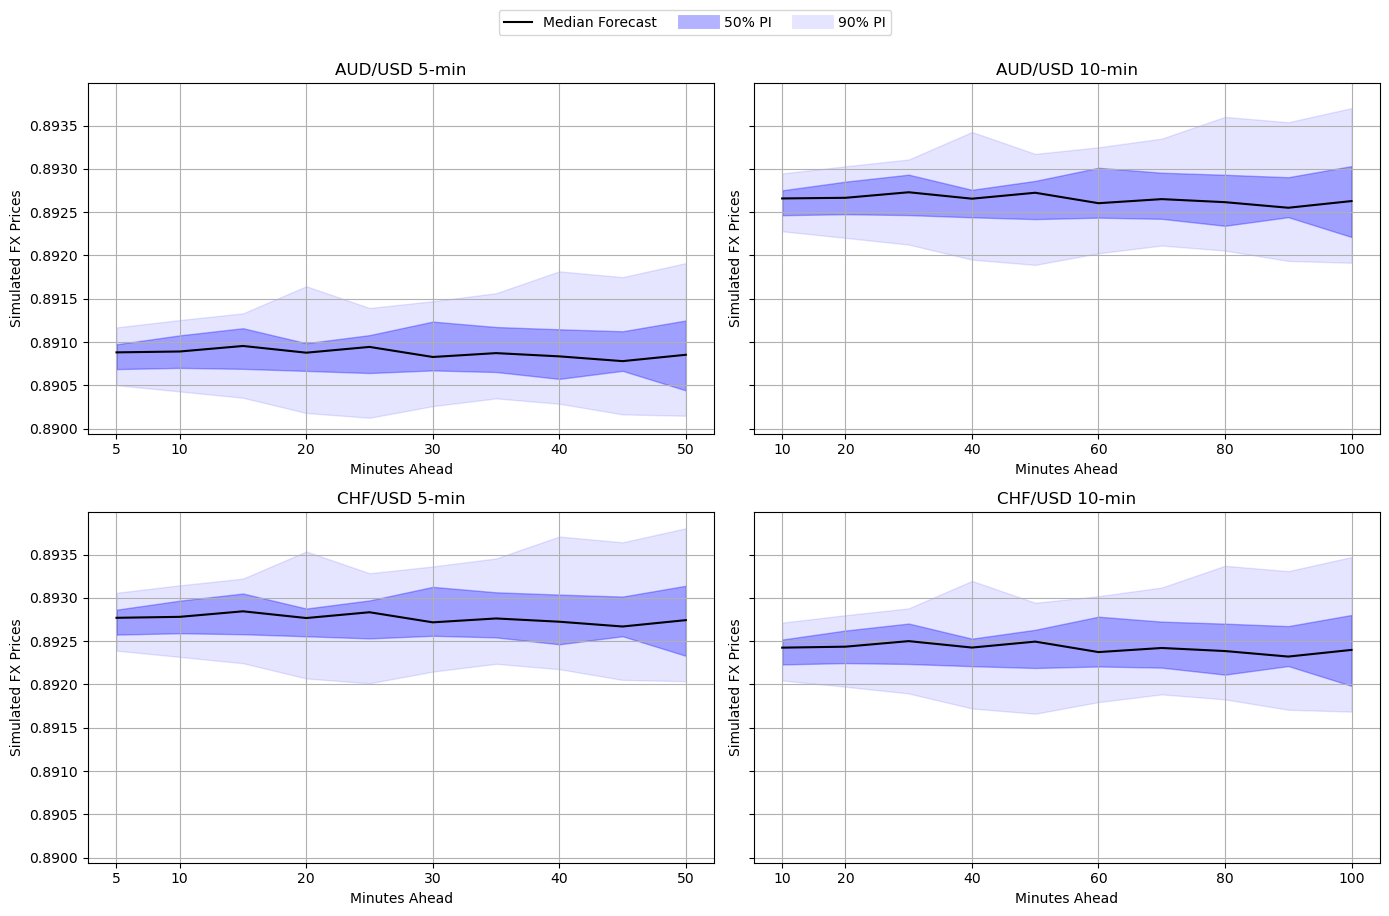

In [64]:
#| label: fig-12-montecarlo-simulations-ar
#| fig-cap: "Monte Carlo simulation paths (25) generated using AR models."

# Plot fan chart with simulated FX prices for each series
plot_fan_chart(simulations_hf_dict, 
               titles=list(simulations_hf_dict.keys()),
               freq_minutes=freq_map, 
               ylabels="Simulated FX Prices")

Moreover, @fig-13-kde-fx displays nearly identical KDE shapes across different frequencies and series. Values are approximately bounded between 0.890 and 0.892 for the AUD/USD 5-minute series, with similar ranges observed for the AUD/USD 10-minute series and CHF/USD at both frequencies, typically falling between 0.891 and 0.894. The distributions exhibit slight left skewness and minor secondary modes near the lower bound, just outside the 90% coverage interval, indicating subtle multimodality. These features reflect the uncertainty in terminal prices captured by the Monte Carlo simulations shown in @fig-12-montecarlo-simulations-ar, illustrating the inherent variability and clustering of possible future FX price outcomes. The fact that current prices lie very close to the median of these distributions reinforces both the short forecasting horizon of `15` steps and the typically mean-reverting, low-volatility nature of currency movements over short intervals.

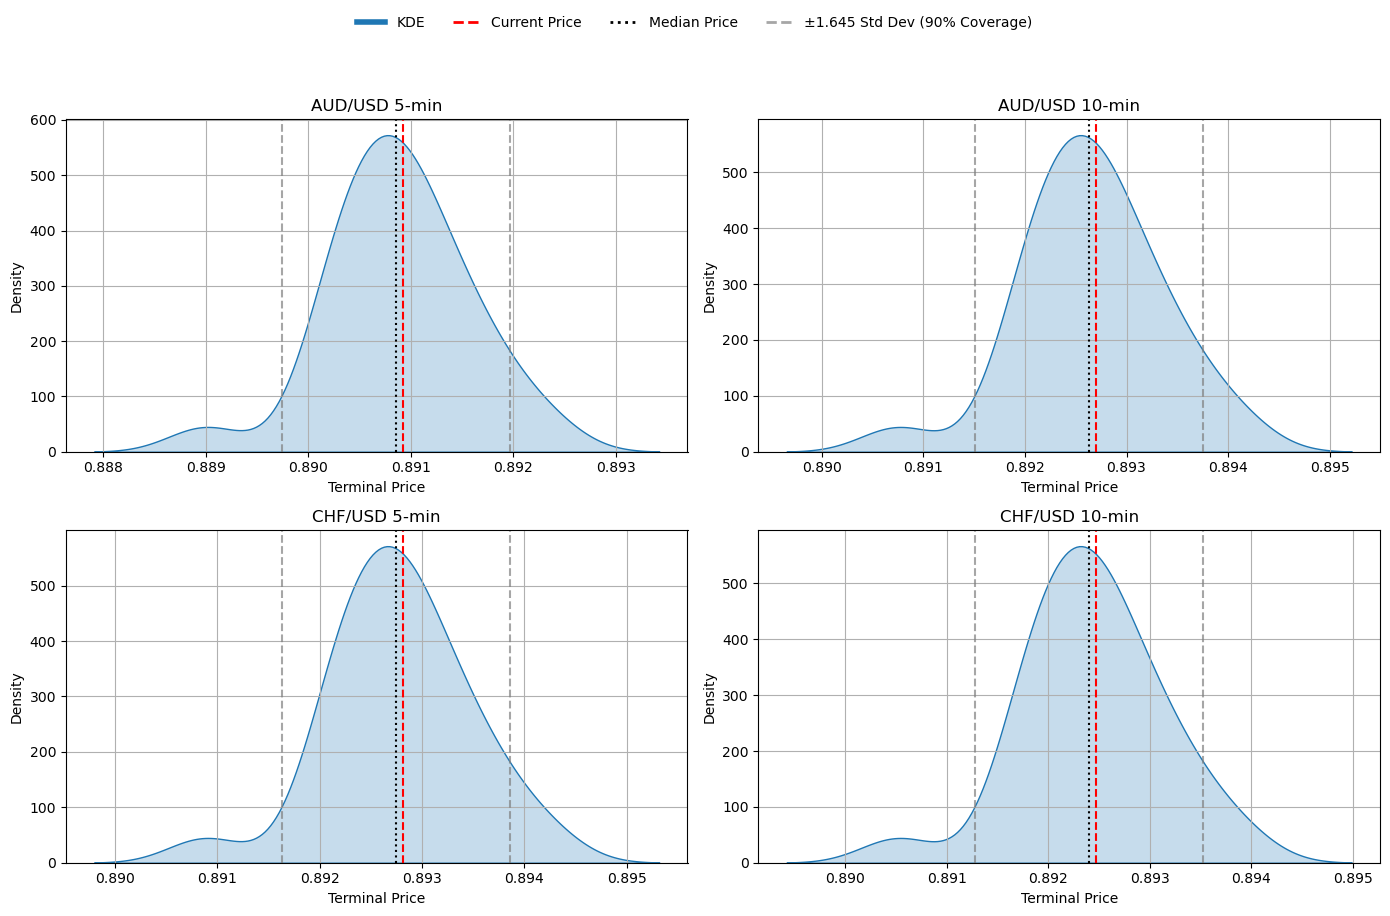

In [65]:
#| label: fig-13-kde-fx
#| fig-cap: "Kernel density estimate of terminal simulated FX prices from Monte Carlo AR simulations."

# Plot kernel density estimate (KDE) of simulated terminal prices
plot_kde(simulations_hf_dict, titles=list(simulations_hf_dict.keys()))

In conclusion, while the AR(p) models provide a useful and computationally efficient framework for short-term FX price simulation, several limitations should be noted. The simplicity of the models, linear with few lags and no volatility dynamics, means they cannot capture important FX market features such as volatility clustering or sudden regime shifts. Additionally, the relatively low number of Monte Carlo paths might limits the granularity of the estimated price distributions, especially in the tails. Finally, the stationarity assumption and the short simulation horizon mean that these results should be interpreted cautiously for longer-term forecasting or risk management purposes.

## Part 3 {#sec-part-3}

In this section, we fit AutoRegressive Integrated Moving Average (ARIMA) models [@box_jenkins_1970] to the previously used datasets, excluding the annual socio-economic series and compare their performance with the forecasting methods discussed in @sec-part-1. I then evaluate ARCH/GARCH models [@engle_1982; @bollerslev_1986], applying the best-performing specifications to enhance the simulation of 5-minute frequency data for AUD/USD and CHF/USD, as introduced in @sec-part-2.

### ARIMA Forecasting and Evaluation

ARIMA models are estimated using the automatic procedure proposed by Hyndman and Khandakar [-@hyndman_khandakar_2008], implemented via the `StatsForecast` library, which replicates the original R implementation. The procedure selects the optimal autoregressive ($p$), differencing ($d$) and moving average ($q$) orders, as well as the seasonal orders ($P,D,Q$), by minimizing the corrected Akaike Information Criterion (AICc) [@akaike_1974], using conditional sums-of-squares followed by maximum likelihood estimation (MLE). Stationarity is assessed through the ADF test.

The resulting ARIMA models are used to produce one-step-ahead forecasts. Their predictive performance is reported and compared in @tbl-arima-evaluation.

In [66]:
# Import ARIMA from StatsForecast
from statsforecast.models import AutoARIMA


# split into train set and apply log transformation if needed
spy_log_train = np.log(spy.iloc[:-1])
ewj_log_train = np.log(ewj.iloc[:-1])
us_gdp_log_train = np.log(us_gdp.iloc[:-1])
us_cpi_log_train = np.log(us_cpi.iloc[:-1])
aapl_intraday_log_train = np.log(aapl_intraday.iloc[:-1])
msft_intraday_log_train = np.log(msft_intraday.iloc[:-1])


# Create a subset of the series for ARIMA Modeling
all_series_dict = [
    ('SPY', {
        'train_series': spy_log_train,
        'freq': 'D',
        'log_applied': True,
        'log_last': spy_log_last,
        'test_actual': spy.iloc[[-1]]
    }),
    ('EWJ', {
        'train_series': ewj_log_train,
        'freq': 'D',
        'log_applied': True,
        'test_actual': ewj.iloc[[-1]]
    }),
    ('US GDP', {
        'train_series': us_gdp_log_train,
        'freq': 'QS',
        'log_applied': True,
        'test_actual': us_gdp.iloc[[-1]]
    }),
    ('US CPI', {
        'train_series': us_cpi_log_train,
        'freq': 'MS',
        'log_applied': True,
        'test_actual': us_cpi.iloc[[-1]]
    }),
    ('AAPL Intraday', {
        'train_series': aapl_intraday_log_train,
        'freq': 'min',
        'log_applied': True,
        'test_actual': aapl_intraday.sort_index().iloc[[-1]]
    }),
    ('MSFT Intraday', {
        'train_series': msft_intraday_log_train,
        'freq': 'min',
        'log_applied': True,
        'test_actual': msft_intraday.sort_index().iloc[[-1]]
    })
]

In [67]:
# Initialize containers for forecasts, evaluation metrics and residuals
all_forecasts_for_plotting = {}
all_evaluation_results_list = []
all_residuals = {}

# Initialize ARIMA parameters
arima_parameters = []

# Set Auto.ARIMA
auto_arima = [AutoARIMA(
    max_d=1,
    max_D=1,
    max_p = 3,
    seasonal=False,
    stationary=True,
    ic='aicc',
    stepwise=True,
    allowdrift=True,
    allowmean=False,
    test = 'adf',
    approximation = True,
    alias = 'AutoARIMA'
)]

# Iterate over all_series
for series_name, data in all_series_dict:

    # Get individual series data
    train_series = data['train_series']
    freq = data['freq']
    test_series = data['test_actual']
    log_applied = data['log_applied']


    # Prepare Train/Test df for StatsForecast
    train_df = pd.DataFrame({
        'unique_id': series_name,
        'ds': train_series.index,
        'y': train_series.values
    }).sort_values('ds').reset_index(drop=True)


    test_df = pd.DataFrame({
        'unique_id': series_name,
        'ds': test_series.index,
        'y': test_series.values
    })
    
    # Initialize StatsForecast
    sf = StatsForecast(models=auto_arima, freq=freq, n_jobs=1) 

    # Fit the models and predict horizon=1
    sf.fit(train_df)
    forecasts_df = sf.predict(h=1)

    # revert back to original if log applied
    if log_applied is True:
        forecasts_df['AutoARIMA'] = np.exp(forecasts_df['AutoARIMA'])
    else:
        continue

     # Get ARIMA parameters
    params = sf.fitted_[0, 0].model_['arma']

    # Append parameters to list as dict
    arima_parameters.append({
        'series_name': series_name,
        'p': params[0],
        'd': params[1],
        'q': params[2],
        'P': params[3],
        'D': params[4],
        'Q': params[5]
    })

    # Get ARIMA df
    arima_params_df = pd.DataFrame(arima_parameters)

    # Merge forecasts with actuals for evaluation
    forecasts_df = forecasts_df.merge(test_df, on=['unique_id', 'ds'], how='left')

    # Store for plotting
    all_forecasts_for_plotting[series_name] = forecasts_df

    # Evaluate forecasts using your evaluation method
    evaluation_df = evaluate(
        forecasts_df,
        metrics=[ufl.mae, ufl.mape, ufl.rmse],
        train_df=train_df,
        target_col='y'
    )

    all_evaluation_results_list.append(evaluation_df)


# Combine evaluation results
combined_evaluation_df_arima = pd.concat(all_evaluation_results_list, ignore_index=True)

# Merge the evaluation dafraframes
combined_all_project_models_df = pd.merge(
    combined_all_models_df,
    combined_evaluation_df_arima,
    on=['unique_id', 'metric'],
    how='outer'
).dropna()

/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/statsforecast/arim

In [68]:
#| label: tbl-arima-evaluation
#| tbl-cap: "Comparison of ARIMA model performance with classical forecasting methods."

# Display Evaluation table
HTML(combined_all_project_models_df.to_html(index=False))

unique_id,metric,Naive,HistoricAverage,RWD,WindowAverage,AR(1),AutoARIMA
AAPL Intraday,mae,0.020000,0.046325,0.022222,0.053367,0.031102,0.042781
AAPL Intraday,mape,0.000102,0.000236,0.000113,0.000272,0.000158,0.000218
AAPL Intraday,rmse,0.020000,0.046325,0.022222,0.053367,0.031102,0.042781
EWJ,mae,0.610000,46.102891,0.619249,0.320000,0.599073,0.591019
EWJ,mape,0.008288,0.626398,0.008414,0.004348,0.008140,0.008030
EWJ,rmse,0.610000,46.102891,0.619249,0.320000,0.599073,0.591019
MSFT Intraday,mae,0.010000,0.177587,0.013939,0.045000,0.035309,0.136820
MSFT Intraday,mape,0.000021,0.000374,0.000029,0.000095,0.000074,0.000289
MSFT Intraday,rmse,0.010000,0.177587,0.013939,0.045000,0.035309,0.136820
SPY,mae,6.750000,380.062997,6.822677,5.730000,6.996739,6.749996


The evaluation results show that automatically configured ARIMA models provide limited improvement over simpler benchmark methods across the datasets tested. In addition, examining the parameters in @tbl-arima-best-parameters helps explain this outcome:

* ARIMA does not consistently outperform Naive or RWD models in important metrics like MAE and RMSE. For example, on the AAPL Intraday and MSFT Intraday datasets, ARIMA’s forecast errors are noticeably higher, indicating challenges in capturing rapid fluctuations and noise in high-frequency financial data.
* For macroeconomic series such as US GDP and US CPI, the performance of ARIMA models is comparable to, or slightly worse than, simple benchmark models. This may reflect the inherent complexity of these series. As illustrated in @fig-2-processed-time-series-plot, even after standard transformations and despite passing the ADF test for stationarity, the series still appear to contain underlying trends or signals. This raises concerns about potential false positives from the stationarity tests, which can challenge both automated model selection procedures and the ARIMA framework more broadly, given its reliance on stationarity assumptions. It is surprising that for both US GDP and US CPI, which are already seasonally adjusted, the seasonal differencing parameter is still set to `D=1`. This suggests potential over-differencing, which can introduce unnecessary complexity and distort the underlying signal.
* The ARIMA models selected by the automatic procedure mostly rely on simple structures, with `p=1`, `d=0` or `1`, and `q=0`, and seasonal orders fixed at `(P,D,Q) = (0,1,0)`. These closely resemble simple first-order autoregressive (AR(1)) or seasonal random walk processes [@box_jenkins_1970], thereby limiting their capacity to capture more complex temporal dependencies or nonlinear dynamics beyond basic autoregressive structures.
* Automatic selection criteria like AICc and ADF tests may not always identify the best model, especially in volatile or noisy datasets. This can lead to underfitting or overfitting, reducing generalization performance.
* The poor ARIMA results on intraday financial data suggest instability in parameter estimation due to noise and rapid changes. ARIMA models lack robustness to such characteristics without further tuning or regularization.

In [69]:
#| label: tbl-arima-best-parameters
#| tbl-cap: "ARIMA model best-fit parameters"


# Display ARIMA parameters table
HTML(arima_params_df.to_html(index=False))

series_name,p,d,q,P,D,Q
SPY,1,0,0,0,1,0
EWJ,1,2,0,0,1,0
US GDP,1,0,0,0,1,0
US CPI,1,0,0,0,1,0
AAPL Intraday,1,1,0,0,1,0
MSFT Intraday,1,1,0,0,1,0


In summary, while `AutoARIMA` is fast and simple to implement and does not require much technical expertise, the results suggest that applying ARIMA out-of-the-box with automatic parameter selection is often inadequate for datasets exhibiting complex dynamics or high levels of noise. 

As a result, meaningful improvements may require:

* Careful preprocessing steps such as variance stabilization and manual deseasonalization to improve model interpretability and stationarity.
* Incorporation of exogenous variables to capture structural drivers not accounted for by univariate ARIMA models.
* For high-frequency data, combining ARIMA with volatility models like GARCH or adopting alternative models better suited to handle rapid fluctuations and noise.

### Extended Analysis: Volatility Modeling and Simulation in High-Frequency Data

Building on the AR(p) modeling and simulation in @sec-part-2, the analysis is extended by fitting ARCH and GARCH models to 5-minute AUD/USD and CHF/USD data. A hybrid AR(1)-GARCH(1,1) model is then constructed to simulate `25` future FX paths. This type of hybrid model is commonly used in real-world applications to simulate currency movements under volatility clustering.

Although `StatsForecast` provides ARCH/GARCH functionality, issues were encountered during simulation, specifically, the estimated $\omega$ parameter was too large, leading to explosive future price paths (up to 5 times the original level). To address this, the arch package [@sheppard_arch_2023] is used instead, resulting in more stable and realistic simulations.

As shown in @tbl-arch-garch-evaluation, various ARCH and GARCH specifications with parameters $p$ and $q$ up to `2` are evaluated.

In [70]:
# Subset the series to model
series_subset = [
    ('AUD/USD 5-min', {
        'train_series': dict(all_train_series_preprocessed_hf)['AUD/USD 5-min (log) (diff order 1)'],
        'freq': '5min',
        'log_applied': True,
        'differenced': True,
        'log_last': aud_5min_log_last,
        'test_actual': aud_5min.sort_index().iloc[[-1]]
    }),
    ('CHF/USD 5-min', {
        'train_series': dict(all_train_series_preprocessed_hf)['CHF/USD 5-min (log) (diff order 1)'],
        'freq': '5min',
        'log_applied': True,
        'differenced': True,
        'log_last': chf_5min_log_last,
        'test_actual': chf_5min.sort_index().iloc[[-1]]
    })
]

In [71]:
# Import arch library
from arch import arch_model

# Define your model configurations manually (p, q) tuples
arch_garch_configs = [
    {'name': 'ARCH(1)', 'p': 1, 'q': 0},
    {'name': 'ARCH(2)', 'p': 2, 'q': 0},
    {'name': 'GARCH(1,1)', 'p': 1, 'q': 1},
    {'name': 'GARCH(2,1)', 'p': 2, 'q': 1},
    {'name': 'GARCH(2,2)', 'p': 2, 'q': 2},
]

# Dictionaries to store results
all_forecasts_vol_for_plotting = {}
all_evaluation_vol_results_list = []
arch_garch_parameters = {}

for series_name, data in series_subset:

    arch_garch_parameters[series_name] = {}

    train_series = data['train_series']
    test_series = data['test_actual']
    log_last = data.get('log_last', None)
    last_value = data.get('last_value', None)

    # Container to store forecasts for all models for this series
    series_forecast_data = []

    # Save actual test value (this is constant for a given series)
    test_idx = test_series.index[0]
    test_val = test_series.values[0]

    for config in arch_garch_configs:
        model_name = config['name']
        p = config['p']
        q = config['q']

        # Prepare model - assume zero mean for returns since you are modeling volatility
        model = arch_model(train_series, 
                           mean='Zero', # assume zero mean for returns
                           vol='Garch', 
                           p=p, 
                           q=q, 
                           dist='normal', 
                           rescale=False
                          )

        # Fit model
        try:
            res = model.fit(disp='off')
        except Exception as e:
            print(f"Error fitting {model_name} for {series_name}: {e}")
            # If fitting fails, append NaN or skip this model
            cond_vol_forecast = np.nan
            arch_garch_parameters[series_name][model_name] = {
                'p': p, 'q': q, 'coeff': {}, 'residuals': pd.Series([])
            }
            continue 


        # Forecast 1-step ahead variance
        forecast = res.forecast(horizon=1)

        # Get forecasted conditional variance for the last observation's next step
        cond_var_forecast = forecast.variance.iloc[-1, 0]

        # Take sqrt to get volatility forecast (std dev)
        cond_vol_forecast = np.sqrt(cond_var_forecast)

        # Store model parameters and residuals
        arch_garch_parameters[series_name][model_name] = {
            'p': p,
            'q': q,
            'coeff': res.params.to_dict(),
            'residuals': res.resid,
            'std residuals': res.std_resid
        }

        # Store forecast, date, actual for this model and series
        series_forecast_data.append({
            'unique_id': series_name,
            'ds': test_idx,
            'y': test_val,
            'model': model_name,
            'forecast': cond_vol_forecast
        })

    # After all models for the current series, create DataFrame
    forecast_df = pd.DataFrame(series_forecast_data)
    
    # Pivot forecasts only
    forecast_df = forecast_df.pivot_table(
        index=['unique_id', 'ds', 'y'],
        columns='model',
        values='forecast'
    ).reset_index()

    print

    # Store for plotting
    all_forecasts_vol_for_plotting[series_name] = forecast_df

    # Evaluate using your evaluate function
    # Ensure 'model' and 'forecast' columns are present for evaluation
    evaluation_df = evaluate( 
        forecast_df,
        metrics=[ufl.mae, ufl.mape, ufl.rmse],
        train_df=train_series, 
        target_col='y'
    )
    all_evaluation_vol_results_list.append(evaluation_df)

# Combine all evaluation results after loop
combined_evaluation_df_vol = pd.concat(all_evaluation_vol_results_list, ignore_index=True)

/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints

In [72]:
#| label: tbl-arch-garch-evaluation
#| tbl-cap: "ARCH/GARCH evaluation table with different (p, q) parameter combinations"

# Display ARCH/GARCH evaluation table
HTML(combined_evaluation_df_vol.to_html(index=False))

model,unique_id,metric,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(2,1)","GARCH(2,2)"
,AUD/USD 5-min,mae,0.891009,0.891009,0.890919,0.890909,0.890911
,AUD/USD 5-min,mape,0.999786,0.999786,0.999684,0.999673,0.999675
,AUD/USD 5-min,rmse,0.891009,0.891009,0.890919,0.890909,0.890911
,CHF/USD 5-min,mae,0.892642,0.892642,0.892642,0.892634,0.892608
,CHF/USD 5-min,mape,0.999823,0.999823,0.999823,0.999814,0.999784
,CHF/USD 5-min,rmse,0.892642,0.892642,0.892642,0.892634,0.892608


The evaluation of ARCH and GARCH models on AUD/USD and CHF/USD 5-minute data shows very similar performance across all metrics, MAE, MAPE and RMSE, indicating limited gains from increasing model complexity.

For AUD/USD, RMSE slightly improves from 0.891009 with ARCH(1) and ARCH(2) to 0.890909 with GARCH(2,1), while MAE remains nearly identical and MAPE decreases marginally from 0.999786 to 0.999673. Similarly, CHF/USD exhibits minimal RMSE improvement from 0.892642 (ARCH(1) and ARCH(2)) to 0.892608 (GARCH(2,2)), with equally negligible changes in MAE and MAPE.

The consistent closeness of these metrics across models suggests that more complex specifications like GARCH(2,1) or GARCH(2,2) provide only marginal accuracy gains on unseen data. Given that RMSE is the preferred metric due to its sensitivity to larger errors, these improvements are minimal and likely do not justify the added model complexity.

Therefore, choosing a simpler model such as GARCH(1,1) strikes a favorable balance, delivering comparable accuracy with better parsimony, increased stability and interpretability, especially important for simulation and forecasting purposes in high-frequency FX volatility modeling.

Before proceeding with the simulation, @fig-14-best-garch-residuals presents the raw residuals, histogram of standardized residuals, ACF of standardized residuals and ACF of squared standardized residuals for the GARCH(1,1) model.

In [73]:
# Define helper function for plotting ARCH/GARCH residuals
def plot_garch_arch_diagnostics(data_dict, asset_name, model):
    """
    Plot diagnostic charts for residuals of an ARCH or GARCH model for a specified asset.

    This function produces the following diagnostic plots:
    - Raw residuals over time
    - Standardized residuals over time
    - Histogram with KDE of standardized residuals to visualize distribution
    - Q-Q plot to assess normality of standardized residuals
    - Autocorrelation function (ACF) of standardized residuals to detect autocorrelation
    - ACF of squared standardized residuals to detect remaining ARCH effects 
      (volatility clustering)

    Parameters:
        data_dict (dict): 
            Dictionary containing model results, keyed by asset names. 
            Each asset entry should include a sub-dictionary for the specified model
            (e.g., 'GARCH(1,1)' or 'ARCH(1)') with keys:
                - 'residuals': Raw residuals from the model
                - 'std residuals': Standardized residuals from the model
        asset_name (str): 
            The key identifying the asset in data_dict for which to plot diagnostics.
        model (str): 
            The model key (e.g., 'GARCH(1,1)', 'ARCH(1)') corresponding 
            to the desired residuals.

    Returns:
        None
        Displays diagnostic plots for model residuals.
    """
    # Extract GARCH(1,1) results for the specified asset
    garch_data = data_dict[asset_name][model]
    resid = garch_data['residuals']             # Raw residuals from the model
    std_resid = garch_data['std residuals']     # Standardized residuals
    
    # Set up a 3x2 grid of subplots
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    
    # Plot raw residuals over time
    axes[0, 0].plot(resid)
    axes[0, 0].set_title("Raw Residuals")
    axes[0, 0].grid(True)
    
    # Plot standardized residuals over time
    axes[0, 1].plot(std_resid)
    axes[0, 1].set_title("Standardized Residuals")
    axes[0, 1].grid(True)
    
    # Histogram and KDE of standardized residuals
    sns.histplot(std_resid, kde=True, ax=axes[1, 0], bins=50)
    axes[1, 0].set_title("Histogram of Standardized Residuals")
    
    # Q-Q plot to check for normality of standardized residuals
    stats.probplot(std_resid, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title("Q-Q Plot")
    
    # ACF standardized residuals to detect serial correlation
    plot_acf(std_resid, ax=axes[2, 0], lags=40)
    axes[2, 0].set_title("ACF of Standardized Residuals")
    
    # ACF of squared standardized residuals to detect remaining ARCH effects 
    plot_acf(std_resid**2, ax=axes[2, 1], lags=40)
    axes[2, 1].set_title("ACF of Squared Standardized Residuals")
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

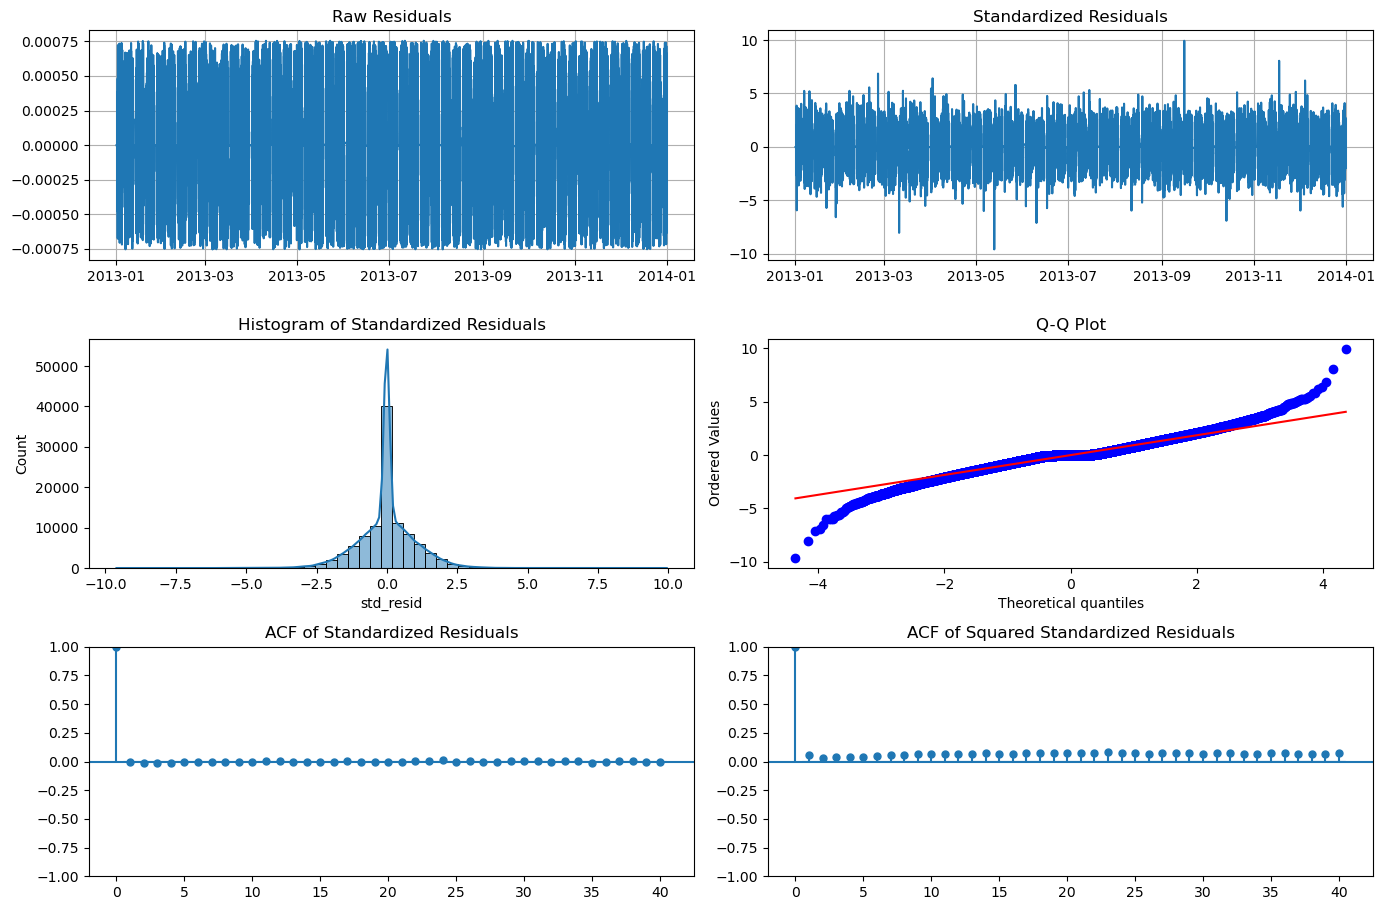

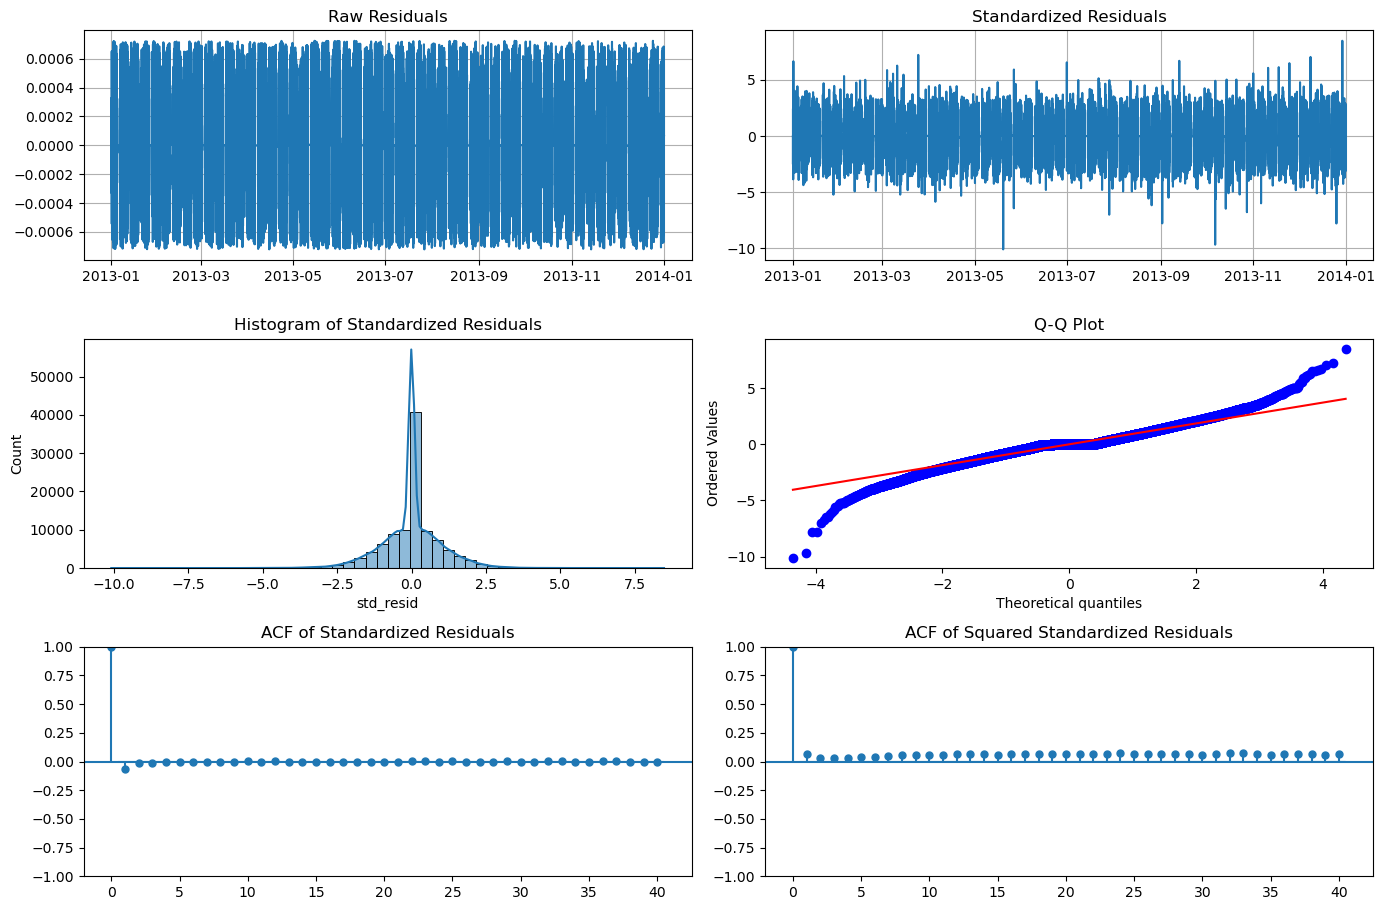

In [74]:
#| label: fig-14-best-garch-residuals
#| fig-cap: "GARCH(1,1) Residual Diagnostics."
#| fig-subcap: 
#|   - "AUD/USD 5-min." 
#|   - "CHF/USD 5-min."

# List of the two relevant series
selected_series = ['AUD/USD 5-min', 'CHF/USD 5-min']

# Loop through the series and generate diagnostic plots
for series in selected_series:
    plot_garch_arch_diagnostics(arch_garch_parameters, asset_name=series, model='GARCH(1,1)')

The diagnostic plots indicate that both raw and standardized residuals exhibit properties broadly consistent with white noise. The Q-Q plots display an approximately linear shape, suggesting that the standardized residuals are reasonably normally distributed. Histograms further support this impression, showing near-Gaussian forms. While the ACF of both standardized residuals and their squares generally show low values, the latter display mild autocorrelations at certain lags that may be marginally significant. Nonetheless, these deviations are limited and the overall diagnostics support the GARCH(1,1) model as an adequate specification for both exchange rate series, with a slightly better fit observed for AUD/USD than for CHF/USD.

In [75]:
# Define helper function for running Monte Carlo simulations using AR-GARCH models
def monte_carlo_ar_garch_sim(ar_coefs, ar_intercept, omega, alpha, beta,
                              start_values, start_eps, start_h,
                              n_simulations=25, n_steps=15, seed=42):
    """
    Simulate AR(p)-GARCH(p,q) paths using Monte Carlo.
    
    Parameters:
        ar_coefs (array-like): AR coefficients (phi1, phi2, ..., phip).
        ar_intercept (float): Intercept of AR model.
        omega (float): GARCH omega parameter (constant term).
        alpha (list): GARCH alpha parameters (ARCH terms).
        beta (list): GARCH beta parameters (GARCH terms).
        start_values (list or array-like): Starting values for AR lags (length >= p).
        start_eps (list or array-like): Starting residuals (length >= max(q, 1)).
        start_h (list or array-like): Starting conditional variances (length >= max(p_garch, 1)).
        n_simulations (int): Number of simulated paths.
        n_steps (int): Number of time steps to simulate.
        seed (int): Random seed.

    Returns:
        np.ndarray: shape (n_simulations, n_steps), simulated values.
    """
    np.random.seed(seed)
    
    ar_order = len(ar_coefs)
    p_garch = len(beta)
    q_arch = len(alpha)

    sims = np.zeros((n_simulations, n_steps))

    for sim in range(n_simulations):
        ar_hist = list(start_values.copy())
        eps_hist = list(start_eps.copy())
        h_hist = list(start_h.copy())

        for t in range(n_steps):
            # Compute current conditional variance
            arch_term = sum(alpha[i] * (eps_hist[-(i+1)] ** 2) for i in range(q_arch))
            garch_term = sum(beta[i] * h_hist[-(i+1)] for i in range(p_garch))
            h_t = omega + arch_term + garch_term

            # Innovation
            eps_t = np.random.normal(0, np.sqrt(h_t))

            # AR(p) component
            ar_term = sum(ar_coefs[i] * ar_hist[-(i+1)] for i in range(ar_order))
            y_t = ar_intercept + ar_term + eps_t

            # Store simulated value
            sims[sim, t] = y_t

            # Update histories
            ar_hist.append(y_t)
            eps_hist.append(eps_t)
            h_hist.append(h_t)

    return sims

In [76]:
# Define rules for specific series
series = ['AUD/USD 5-min', 'CHF/USD 5-min']
best_ar = ['AR(1)', 'AR(1)']           
best_arch_garch = ['GARCH(1,1)', 'GARCH(1,1)'] 
initial_eps = 0.001 # Set initial epsilon 

# Store AR-GARCH simulations
all_archgarch_simulations = {}

for series_name, ar_model, garch_model in zip(series, best_ar, best_arch_garch):
    try:
        # Get AR model coefficients
        model_result = all_ar_model_results[series_name][ar_model]
        coefs_dict = model_result['coef']
        coefs = np.array([v for k, v in sorted(coefs_dict.items()) if k.startswith('ar')])
        intercept = coefs_dict.get('intercept', 0.0)
        p_ar = len(coefs)

        # Get GARCH parameters
        garch_params = arch_garch_parameters[series_name][garch_model]['coeff']
        omega = garch_params['omega']
        alpha = [v for k, v in garch_params.items() if 'alpha' in k]
        beta = [v for k, v in garch_params.items() if 'beta' in k]
        p_garch = len(beta)
        q_arch = len(alpha)
        max_lag = max(p_garch, q_arch)

        # Prepare data
        full_series = series_lookup[series_name]
        train_series = full_series.iloc[:-1]
        log_train_series = np.log(train_series.dropna())
        log_train_returns = log_train_series.diff().dropna()

        # Start values
        start_values = log_train_returns[-p_ar:].values.tolist()
        start_eps_list = [initial_eps] * max(q_arch, 1)
        start_h = [(omega / (1 - sum(alpha) - sum(beta))) if (sum(alpha) + sum(beta)) < 1 else 1e-6] * max(p_garch, 1)

        # Run simulation
        sims = monte_carlo_ar_garch_sim(
            ar_coefs=coefs,
            ar_intercept=intercept,
            omega=omega,
            alpha=alpha,
            beta=beta,
            start_values=start_values,
            start_eps=start_eps_list,
            start_h=start_h,
            n_simulations=25,
            n_steps=15,
            seed=42
        )

        # Back to price level
        last_price = train_series.iloc[-1]
        simulated_price = last_price * np.exp(np.cumsum(sims, axis=1))
        all_archgarch_simulations[series_name] = simulated_price

    except Exception as e:
        print(f"Error processing series {series_name}: {e}")

Finally, @fig-15-montecarlo-simulations-ar-garch and @fig-16-kde-fx present the Monte Carlo simulations and the corresponding KDE of terminal exchange rate prices for both series. As illustrated in the former, the hybrid AR(1)-GARCH(1,1) model outperforms the AR(1) model alone by producing richer dynamics and more realistic uncertainty bands, particularly at the 50% and 90% prediction intervals. Compared to the AR(1), only simulations in @fig-12-montecarlo-simulations-ar, the hybrid model captures wider and more nuanced distributions, suggesting improved modeling power, an advantage that may translate well into applications such as risk modeling and the development of trading strategies.

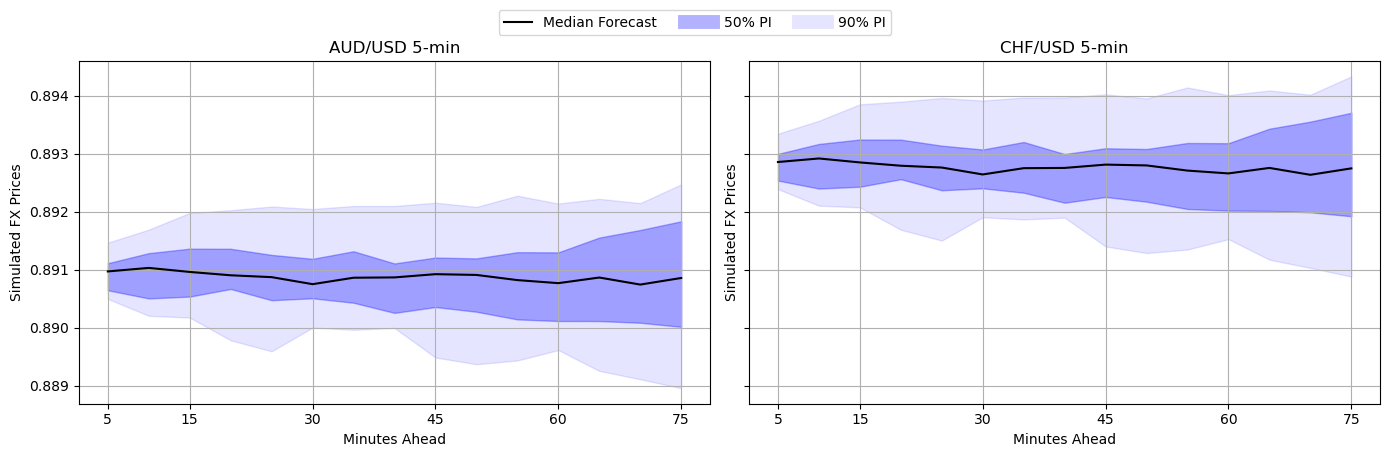

In [77]:
#| label: fig-15-montecarlo-simulations-ar-garch
#| fig-cap: "Monte Carlo simulation paths (25) generated using AR-GARCH models."

# Plot fan chart with simulated FX prices for each series
plot_fan_chart(all_archgarch_simulations, 
               titles=list(all_archgarch_simulations.keys()),
               freq_minutes=freq_map, 
               ylabels="Simulated FX Prices")

Moreover, the KDE plots in @fig-16-kde-fx reveal that the terminal prices generated by the AR-GARCH simulations are closer to a normal distribution and exhibit a slight right skew. This contrasts with the heavier distortions observed in @fig-13-kde-fx under the AR-only specification, further supporting the benefit of incorporating GARCH(1,1) dynamics even with a limited number of simulated paths.

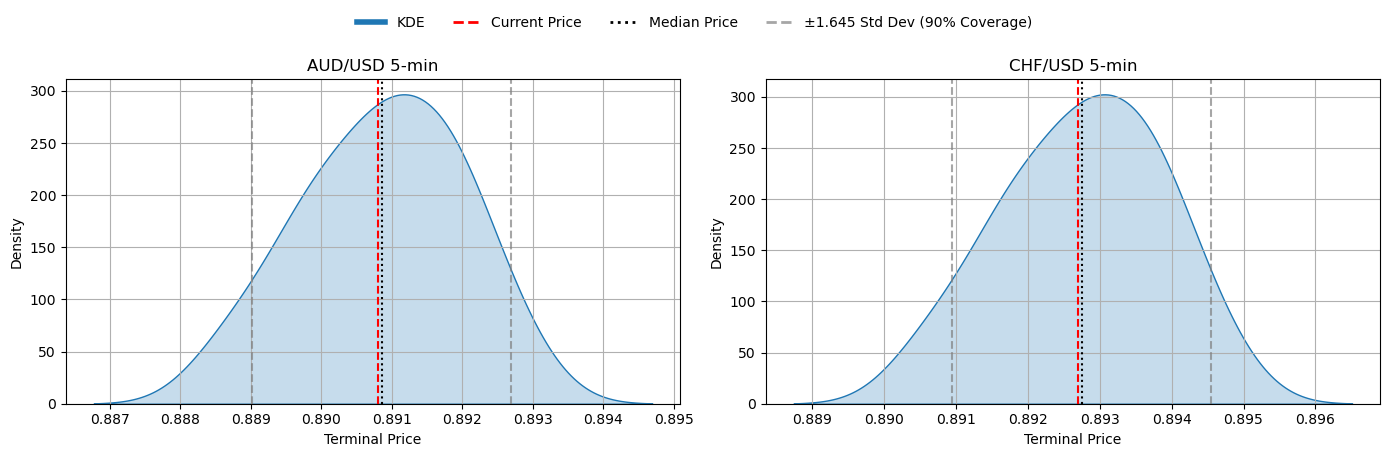

In [78]:
#| label: fig-16-kde-fx
#| fig-cap: "Kernel density estimate of terminal simulated FX prices from Monte Carlo AR-GARCH simulations."

plot_kde(all_archgarch_simulations, titles=list(all_archgarch_simulations.keys()))

In summary, the results demonstrate that incorporating volatility dynamics through the GARCH(1,1) component markedly improves the realism and robustness of exchange rate simulations compared to simpler AR models.

Nonetheless, several limitations should be noted. The relatively small number of simulation paths may constrain the model’s capacity to capture tail risks and extreme events comprehensively. Additionally, the assumption of stationarity may reduce effectiveness in the presence of structural breaks or regime shifts frequently observed in FX markets, particularly over longer forecasting horizons or with different training datasets. Future research could focus on scaling up simulations and extending the framework to include regime-switching or stochastic volatility models to better address these complexities.

## Conclusion

This project systematically evaluated statistical time series models across a range of real-world datasets. The findings confirm that even parsimonious models such as the Naive and Random Walk with Drift can perform remarkably well in specific domains, notably in financial and economic forecasting where short-term persistence dominates.

Autoregressive models, including AR and ARIMA, demonstrated solid performance but also revealed limitations when applied to complex or noisy datasets. The integration of Monte Carlo simulations and KDE proved to be effective for visualizing the distribution of terminal price outcomes and quantifying forecast uncertainty. However, the uncertainty bounds generated by different models were inherently shaped by their underlying assumptions. For example, while Geometric Brownian Motion offered a simple linear framework, it lacked responsiveness to changing volatility, unlike AR-GARCH models which provided more adaptive, state-dependent uncertainty estimates.

The focus on one-step-ahead forecasts ensured a consistent and controlled evaluation framework, though it inherently limits insight into longer-term dynamics, an area warranting further exploration. Additional limitations include sensitivity to structural breaks and the relatively low number of Monte Carlo paths, which may underrepresent tail risk and extreme event scenarios.

In conclusion, the study underscores both the strengths and constraints of classical statistical models, providing a robust foundation for future research. It also highlights the potential for more flexible and adaptive methodologies, such as machine learning, to better accommodate the nonlinear and regime-dependent behaviors often observed in real-world time series data.

## References

::: {#refs}
:::